## CUNY DATA698
### Topic Modeling for Forensics Analysis of Text-Based Conversations
#### Michael Ippolito
#### May 2024

This is part of a series of Python Jupyter notebooks in support of my master's capstone project. The aim of the project is to study various methods of preprocessing, topic modeling, and postprocessing text-based conversation data often extracted from electronic devices recovered during criminal or cybersecurity investigations.

The Jupyter notebooks used in this project are as follows:

| Module | Purpose |
|--------|---------|
| eda1.ipynb | Exploratory data analysis of the four datasets used in the study. |
| modeling1.ipynb | Loads and preprocesses the datasets, performs various topic models, postprocesses the topic representations. |
| survey1.ipynb | Generates conversation text and topic representations to submit to Mechanical Turk. It later parses the results and incorporates them into my own hand-labeled results. |
| survey2.ipynb | Loads Mechanical Turk survey results and evaluates them for quality based on reading speed and attention questinos. |
| eval1.ipynb | Evaluates the topic modeling and survey results based on topic coherence, semantic quality, and topic relevance. |

The study uses the following four datasets:

1. Chitchat
2. Topical Chat
3. Ubuntu Dialogue
4. Enron Email

For further details and attribution, see my paper in this github repo.


### Results Evaluation
#### eval1.ipynb

The code in this module evaluates the topic modeling and survey results in three ways:

1. Topic coherence metrics (Cv, UCI, NPMI, and UMass).
2. Semantic quality of survey results.
3. Relevance of topic representations.


### Initialization

This section does the following:

1. Loads required libraries
2. Sets module-wide parameters
3. initializes the sentence transformer model used to perform cosine similarity scorin on human-labeled data.
4. Loads helper functions


In [797]:
# Load libraries
import os
import re
import json
import numpy as np
import pandas as pd
import random
from collections import Counter
import html
import csv
from IPython.display import display, HTML
from sentence_transformers import SentenceTransformer, util
from plotnine import ggplot, ggtitle, aes, theme, theme_minimal, coord_flip, xlab, ylab, facet_grid, facet_wrap
from plotnine import geom_line, geom_point, geom_bar, geom_histogram, geom_boxplot, geom_jitter, geom_abline, geom_hline, geom_vline
from plotnine import scale_fill_discrete, scale_fill_grey, scale_fill_manual, scale_fill_brewer, scale_fill_hue
from plotnine import scale_colour_discrete, scale_colour_grey, scale_colour_manual, scale_colour_brewer, scale_colour_hue
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import f_oneway


In [2]:
# Params
capstone_dir = 'C:/Users/micha/Box Sync/cuny/698-Capstone'
pickle_dir = 'C:/tmp/pickles'
transmodeldir = 'C:/Users/micha/Documents/698/transformers/'
transmodel = 'all-MiniLM-L6-v2'


In [3]:
# Init sentence embedding model
print(f'loading sentence transformer model {transmodel}')
sentence_model = SentenceTransformer(transmodeldir + transmodel)
print('\t', sentence_model)


loading sentence transformer model all-MiniLM-L6-v2
	 SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [736]:
# Function to run anova and return a dictionary element containing the keyname, test stat, and p-value
def run_anova(keyname, q):
    """
    Purpose:             To run an analysis of variance model against a set of means.
    Parameters:
        keyname          The key of the dictionary that will contain the anova results.
        q                Quality scores to compare; this needs to be a list of lists.
    Returns:
        None             The dictionary 'd' that will contain the results is a global variable.
    """

    # This is the dictionary that we'll be adding this result to
    global d
    
    # scipy's f_oneway function requires each array to be entered as a separate parameter,
    # so need to built the statement as a string, then evaluate it
    ct_arrays = 0
    s = 'f_oneway('
    for e in q:
        if len(e) > 0:
            ct_arrays += 1
            s += str(e) + ', '
    if s[-2:] == ', ': s = s[0:-2]  # remove trailing comma
    s += ')'

    # Make sure there is more than one list of values; you so totally can't compare a single list to itself!
    if ct_arrays == 1:
        print("\tonly one array of values, can't run ANOVA on a single array")
    else:

        # Run the anova calculation
        o = eval(s)
        print(type(q), len(q), o)

        # Add the results to the dict
        d[keyname].append(r)
        d['Test_statistic'].append(o[0])
        d['p-value'].append(o[1])


In [4]:
# Function to load the last pickle file of the specified type (bow, word2vec, or transformer)
def load_last_pickle(model_type):
    """
    Purpose:                     To load the last dataframe saved in pandas pickle format.
    Parameters:
        model_type               The model type to load, which basically just points to a certain directory to load the pickle from.
    Returns:
        dftmp                    The dataframe loaded from the pickle file.
    """

    d = os.listdir(f'{pickle_dir}/{model_type}')
    last_pickle = sorted(d, reverse=True)[0]
    dftmp = pd.read_pickle(f'{pickle_dir}/{model_type}/{last_pickle}')
    return dftmp


In [149]:
# Function to add a friendly model description to the results df
def friendly_model(model_params, opt):
    """
    Purpose:                     To add a friendly model name based on the model family and specific model type.
    Parameters:
        model_params             The model-specific parameters used.
        opt                      Output option: 1=longer name, otherwise short name.
    Returns:
        r                        Friendly model name.
    """

    # opt: 0=less specific, 1=more specific

    model_params = str(model_params)
    if model_params == "{'embeddings': 'fasttext', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 'eps': 0.1, 'min_samples': 3}":
        if opt == 1:
            return 'fasttext/dbscan (eps=0.1/min_samp=3)'
        else:
            return 'fasttext/dbscan'
    elif model_params == "{'embeddings': 'fasttext', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 'eps': 1, 'min_samples': 2}":
        if opt == 1:
            return 'fasttext/dbscan (eps=1/min_samp=2)'
        else:
            return 'fasttext/dbscan'
    elif model_params == "{'embeddings': 'fasttext', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 'n_clusters': 15, 'max_iter': 300, 'tol': 0.0001}":
        if opt == 1:
            return 'fasttext/kmeans (clusters=15)'
        else:
            return 'fasttext/kmeans'
    elif model_params == "{'embeddings': 'fasttext', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 'n_clusters': 30, 'max_iter': 300, 'tol': 0.0001}":
        if opt == 1:
            return 'fasttext/kmeans (clusters=30)'
        else:
            return 'fasttext/kmeans'
    elif model_params == "{'embeddings': 'glove', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 'eps': 0.1, 'min_samples': 3}":
        if opt == 1:
            return 'glove/dbscan (eps=0.1/min_samp=3)'
        else:
            return 'glove/dbscan'
    elif model_params == "{'embeddings': 'glove', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 'eps': 1, 'min_samples': 2}":
        if opt == 1:
            return 'glove/dbscan (eps=1/min_samp=2)'
        else:
            return 'glove/dbscan'
    elif model_params == "{'embeddings': 'glove', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 'n_clusters': 15, 'max_iter': 300, 'tol': 0.0001}":
        if opt == 1:
            return 'glove/kmeans (clusters=15)'
        else:
            return 'glove/kmeans'
    elif model_params == "{'embeddings': 'glove', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 'n_clusters': 30, 'max_iter': 300, 'tol': 0.0001}":
        if opt == 1:
            return 'glove/kmeans (clusters=30)'
        else:
            return 'glove/kmeans'
    elif model_params == "{'embeddings': 'word2vec', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 'eps': 0.1, 'min_samples': 3}":
        if opt == 1:
            return 'word2vec/dbscan (eps=0.1/min_samp=3)'
        else:
            return 'word2vec/dbscan'
    elif model_params == "{'embeddings': 'word2vec', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 'eps': 1, 'min_samples': 2}":
        if opt == 1:
            return 'word2vec/dbscan (eps=1/min_samp=2)'
        else:
            return 'word2vec/dbscan'
    elif model_params == "{'embeddings': 'word2vec', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 'n_clusters': 15, 'max_iter': 300, 'tol': 0.0001}":
        if opt == 1:
            return 'word2vec/kmeans (clusters=15)'
        else:
            return 'word2vec/kmeans'
    elif model_params == "{'embeddings': 'word2vec', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 'n_clusters': 30, 'max_iter': 300, 'tol': 0.0001}":
        if opt == 1:
            return 'word2vec/kmeans (clusters=30)'
        else:
            return 'word2vec/kmeans'
    elif model_params == "{'num_topics': 15, 'num_passes': 15}":
        if opt == 1:
            return 'nmf (topics=15)'
        else:
            return 'nmf'
    elif model_params == "{'num_topics': 15, 'num_passes': 25}":
        if opt == 1:
            return 'lda (topics=15)'
        else:
            return 'lda'
    elif model_params == "{'num_topics': 15}":
        if opt == 1:
            return 'lsi (topics=15)'
        else:
            return 'lsi'
    elif model_params == "{'num_topics': 30, 'num_passes': 15}":
        if opt == 1:
            return 'nmf (topics=30)'
        else:
            return 'nmf'
    elif model_params == "{'num_topics': 30, 'num_passes': 25}":
        if opt == 1:
            return 'lda (topics=30)'
        else:
            return 'lda'
    elif model_params == "{'num_topics': 30}":
        if opt == 1:
            return 'lsi (topics=30)'
        else:
            return 'lsi'
    elif model_params == "{'repr_model': 'keybert'}":
        if opt == 1:
            return 'bertopic (keybert)'
        else:
            return 'bertopic (keybert)'
    elif model_params == "{'repr_model': 'none'}":
        if opt == 1:
            return 'bertopic'
        else:
            return 'bertopic'


### Load dataframes

This section loads the following dataframes into memory:

1. Hand-labeled keyword dataset
2. Mechanical Turk survey results
3. Hand-labeled relevance dataset
4. Topic modeling resultset


In [ ]:
# Load keywords
dfkw = pd.read_excel('C:/Users/micha/Box Sync/cuny/698-Capstone/keywords.xlsx', sheet_name='human')
display(dfkw.head(1))


In [551]:
# Load survey results
dfsr = pd.read_pickle(f"{capstone_dir}/mturk_results.pkl")
print(dfsr.shape)
display(dfsr.head(1))
print(list(dfsr.columns))
print(Counter(dfsr['AssignmentStatus']))
print(Counter(dfsr['Answer.relevance.label']))


(891, 40)


,index,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,...,Answer.relevance.label,Approve,Reject,rowid,setid,dataset,docnum,docid,wordct,quality
0,1,3XEIP58NMJ7N4WYIKUQFPJFMW7SZLF,3U2Q8YJASS9X6MVGG7Q77MB02CJT5L,How relevant is the conversation to the given ...,How relevant is the conversation to the given ...,"text, conversation, relevance",$0.22,Thu Apr 18 11:35:34 PDT 2024,4,BatchId:5211639;OriginalHitTemplateId:928390850;,...,4,NaN,NaN,9999,Human_keywords,cc,12.0,2276.0,290.0,good


['index', 'HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward', 'CreationTime', 'MaxAssignments', 'RequesterAnnotation', 'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds', 'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds', 'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime', 'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime', 'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate', 'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input.conversation', 'Input.topic', 'Answer.relevance.label', 'Approve', 'Reject', 'rowid', 'setid', 'dataset', 'docnum', 'docid', 'wordct', 'quality']
Counter({'Approved': 523, 'Submitted': 368})
Counter({4: 269, 3: 201, 5: 177, 1: 141, 2: 103})


In [558]:
# Load relevance results
dfrel = load_last_pickle('relevance')
print(dfrel.shape)
display(dfrel.head(6))
print(Counter(dfrel['Source']))
print(Counter(dfrel['Row_id']))


(1347, 11)


,Dataset,Doc_num,Row_id,Set_id,Quality,Source,Doc_id,Relevant,Topic_words,Cosine_similarity,Conv
0,ee,70.0,72,Topic_words,3,Author,287.0,1.0,"HOU,forward,iSubject,ECT,John,Enron,Phillip,te...",0.251097,"Tim,\nmike grigsby is having problems with acc..."
1,ee,70.0,72,Flan_topic,1,Author,287.0,0.0,iSubject,0.016811,"Tim,\nmike grigsby is having problems with acc..."
2,ee,70.0,72,Flan_topic2,1,Author,287.0,0.0,Electrical healing,0.062604,"Tim,\nmike grigsby is having problems with acc..."
3,ee,235.0,242,Topic_words,1,Author,1881.0,0.0,"pass,realise,realize,sustain,catch,bear,genera...",0.055758,"Phillip,\nBarry had said that you were asking ..."
4,ee,235.0,242,Flan_topic,1,Author,1881.0,0.0,Science/Tech,-0.000527,"Phillip,\nBarry had said that you were asking ..."
5,ee,235.0,242,Flan_topic2,3,Author,1881.0,1.0,Business,-0.055280,"Phillip,\nBarry had said that you were asking ..."


Counter({'MTurk': 891, 'Author': 456})
Counter({9999: 48, 300: 24, 256: 21, 312: 21, 240: 21, 19: 21, 99: 21, 115: 21, 112: 21, 288: 21, 211: 21, 163: 21, 16: 18, 195: 18, 304: 18, 308: 18, 96: 18, 192: 18, 292: 18, 88: 18, 91: 18, 243: 18, 259: 18, 316: 18, 40: 18, 43: 18, 144: 18, 147: 18, 160: 18, 296: 18, 64: 18, 67: 18, 208: 18, 324: 18, 344: 18, 348: 18, 342: 18, 380: 18, 384: 18, 330: 18, 356: 18, 360: 18, 394: 18, 336: 18, 368: 18, 372: 18, 396: 18, 392: 15, 313: 9, 242: 6, 262: 6, 281: 6, 253: 6, 254: 6, 280: 6, 275: 6, 263: 6, 87: 6, 132: 6, 113: 6, 295: 6, 130: 6, 108: 6, 134: 6, 14: 6, 123: 6, 127: 6, 50: 6, 58: 6, 166: 6, 161: 6, 180: 6, 165: 6, 24: 6, 72: 3, 75: 3, 278: 3, 252: 3, 248: 3, 245: 3, 269: 3, 273: 3, 250: 3, 287: 3, 314: 3, 244: 3, 85: 3, 283: 3, 274: 3, 84: 3, 90: 3, 81: 3, 270: 3, 89: 3, 251: 3, 255: 3, 257: 3, 21: 3, 109: 3, 136: 3, 133: 3, 124: 3, 289: 3, 5: 3, 293: 3, 291: 3, 111: 3, 138: 3, 110: 3, 10: 3, 18: 3, 2: 3, 101: 3, 126: 3, 100: 3, 121: 3, 98: 

In [559]:
# Load modeling results
dfr = load_last_pickle('sim')
dfr['Num_topics'] = dfr['Num_topics'].astype(int)
print(dfr.shape)
display(dfr.head(1))
print(dfr.columns)


(400, 27)


,index,Dataset,Num_docs,Rnd_seed,Model,Num_topics,Model_params,Cv_score,Cuci_score,Cnpmi_score,...,Topic_words,Doc_topics,Flan_topic,Cosine_similarity,Model_family,Topic_words2,Flan_topic2,Keyphrases,Cosine_similarity_flan,Cosine_similarity_flan2
0,0,chitchat,250,77,lsi,8,{'num_topics': 15},0.256103,-12.5412,-0.44286,...,"[(0, [('tear', 0.1492861747332724), ('eye', 0....","{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[[0, ""People""], [1, ""People""], [2, ""Science/Te...","{""0"": [[0, 0.19291281700134277], [1, 0.0759510...",bow,"[[0, [[""job"", 0], [""work"", 0], [""eros"", 0], [""...","[[0, ""eros""], [1, ""eros""], [2, ""Brazil""], [3, ...",False,"{""0"": [[0, 0.08827038109302521], [1, 0.0368935...","{""0"": [[0, 0.0584552064538002], [1, -0.0289450..."


Index(['index', 'Dataset', 'Num_docs', 'Rnd_seed', 'Model', 'Num_topics',
       'Model_params', 'Cv_score', 'Cuci_score', 'Cnpmi_score', 'Umass_score',
       'Spell_checked', 'Text_speak', 'Synonyms', 'Hypernyms', 'Runtime',
       'Timestamp', 'Topic_words', 'Doc_topics', 'Flan_topic',
       'Cosine_similarity', 'Model_family', 'Topic_words2', 'Flan_topic2',
       'Keyphrases', 'Cosine_similarity_flan', 'Cosine_similarity_flan2'],
      dtype='object')


In [560]:
# Check for NAs
print('NAs:')
print(dfr.isna().sum())
print()


NAs:
index                        0
Dataset                      0
Num_docs                     0
Rnd_seed                     0
Model                        0
Num_topics                   0
Model_params                 0
Cv_score                    78
Cuci_score                 102
Cnpmi_score                102
Umass_score                102
Spell_checked                0
Text_speak                   0
Synonyms                     0
Hypernyms                    0
Runtime                      0
Timestamp                    0
Topic_words                  0
Doc_topics                   0
Flan_topic                   0
Cosine_similarity            0
Model_family                 0
Topic_words2                 0
Flan_topic2                  0
Keyphrases                   0
Cosine_similarity_flan       0
Cosine_similarity_flan2      0
dtype: int64



In [561]:
# Set preprocessing indicator
dfr['Preproc'] = pd.NA
dfr.loc[dfr['Keyphrases'] == True, 'Preproc'] = 'Keyphrases'
dfr.loc[((dfr['Synonyms'] == True) | (dfr['Hypernyms'] == True)) & (dfr['Keyphrases'] == False), 'Preproc'] = 'Syn/Hyper'
dfr.loc[(dfr['Synonyms'] == False) & (dfr['Hypernyms'] == False) & (dfr['Keyphrases'] == False), 'Preproc'] = 'None'

# Verify there are no NAs
print(dfr[pd.isna(dfr['Preproc'])].shape)
print(np.unique(dfr['Preproc']))


(0, 28)
['Keyphrases' 'None' 'Syn/Hyper']


In [562]:
# Get friendly model name
print(np.unique(dfr['Model']))
print()
print(np.unique(dfr['Model_params'].astype(str)))
print()
dfr['Model_run'] = dfr['Model_params'].apply(friendly_model, opt=0)
print(np.unique(dfr['Model_run']))


['bertopic' 'lda' 'lsi' 'nmf' 'word2vec']

["{'embeddings': 'fasttext', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 'eps': 0.1, 'min_samples': 3}"
 "{'embeddings': 'fasttext', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 'eps': 1, 'min_samples': 2}"
 "{'embeddings': 'fasttext', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 'n_clusters': 15, 'max_iter': 300, 'tol': 0.0001}"
 "{'embeddings': 'fasttext', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 'n_clusters': 30, 'max_iter': 300, 'tol': 0.0001}"
 "{'embeddings': 'glove', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 'eps': 0.1, 'min_samples': 3}"
 "{'embeddings': 'glove', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'dbscan', 'eps': 1, 'min_samples': 2}"
 "{'embeddings': 'glove', 'vector_size': 200, 'min_count': 1, 'cluster_alg': 'kmeans', 'n_clusters': 15, 'max_iter': 300, 'tol': 0.0001}"
 "{'embeddings': 'glove', 'vector_size': 200, 'min_count': 1, '

### Topic Coherence

This section evaluates topic coherence metrics.


In [12]:
#########################################
# Coherence
#########################################

# Function to show coherence score by dataset and model
def plot_coh(coh_score):
    p = ggplot(dfr[~pd.isna(dfr[coh_score])]) + \
        aes(x='Model_family', y=coh_score, color='Model_run') + \
        geom_point(stat='identity') + \
        geom_jitter(width=0.2) + \
        theme_minimal() + \
        scale_colour_hue(l=0.5) + \
        facet_wrap('Dataset')
    return p
    

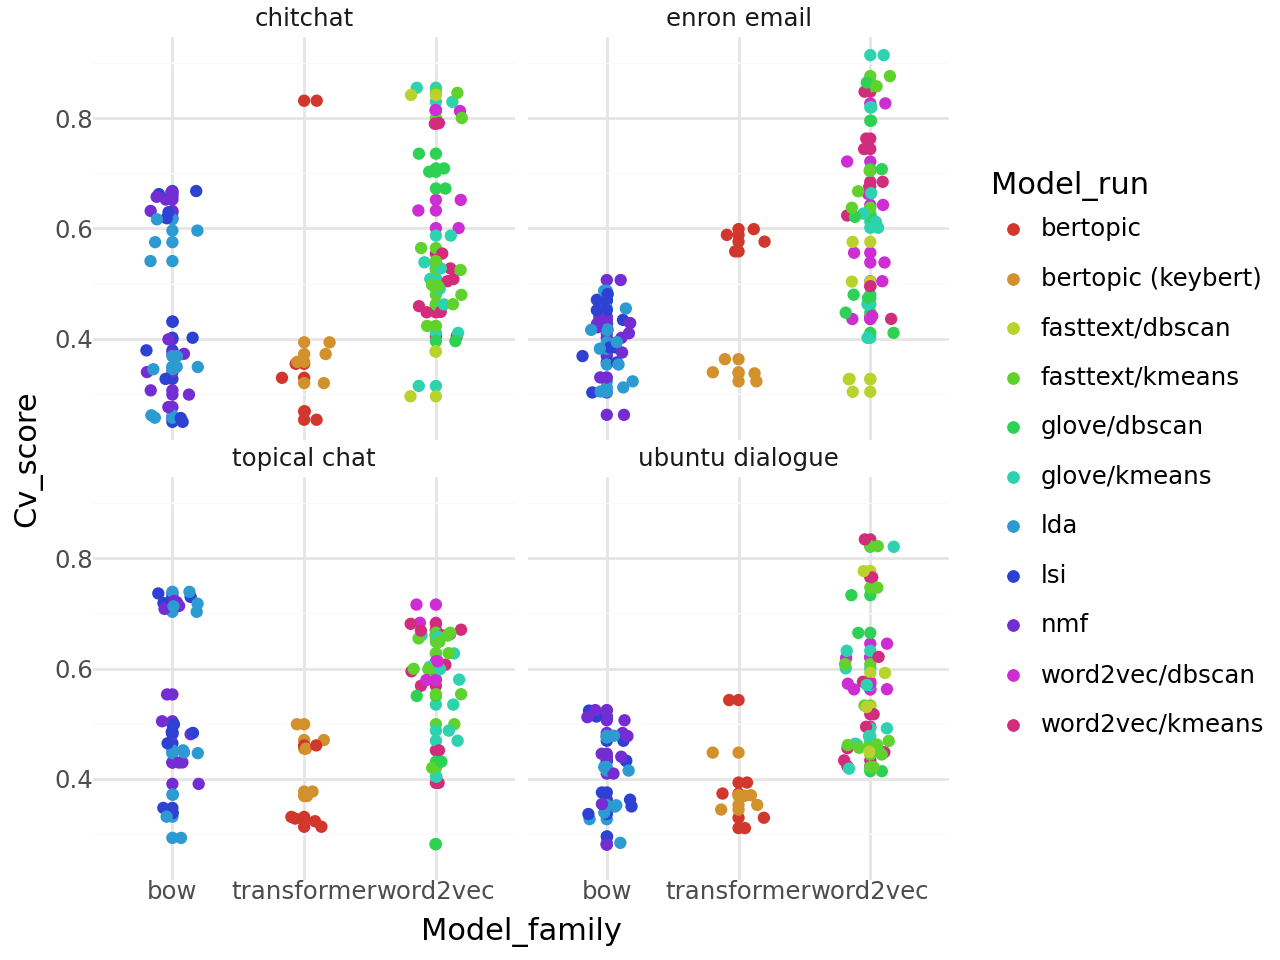

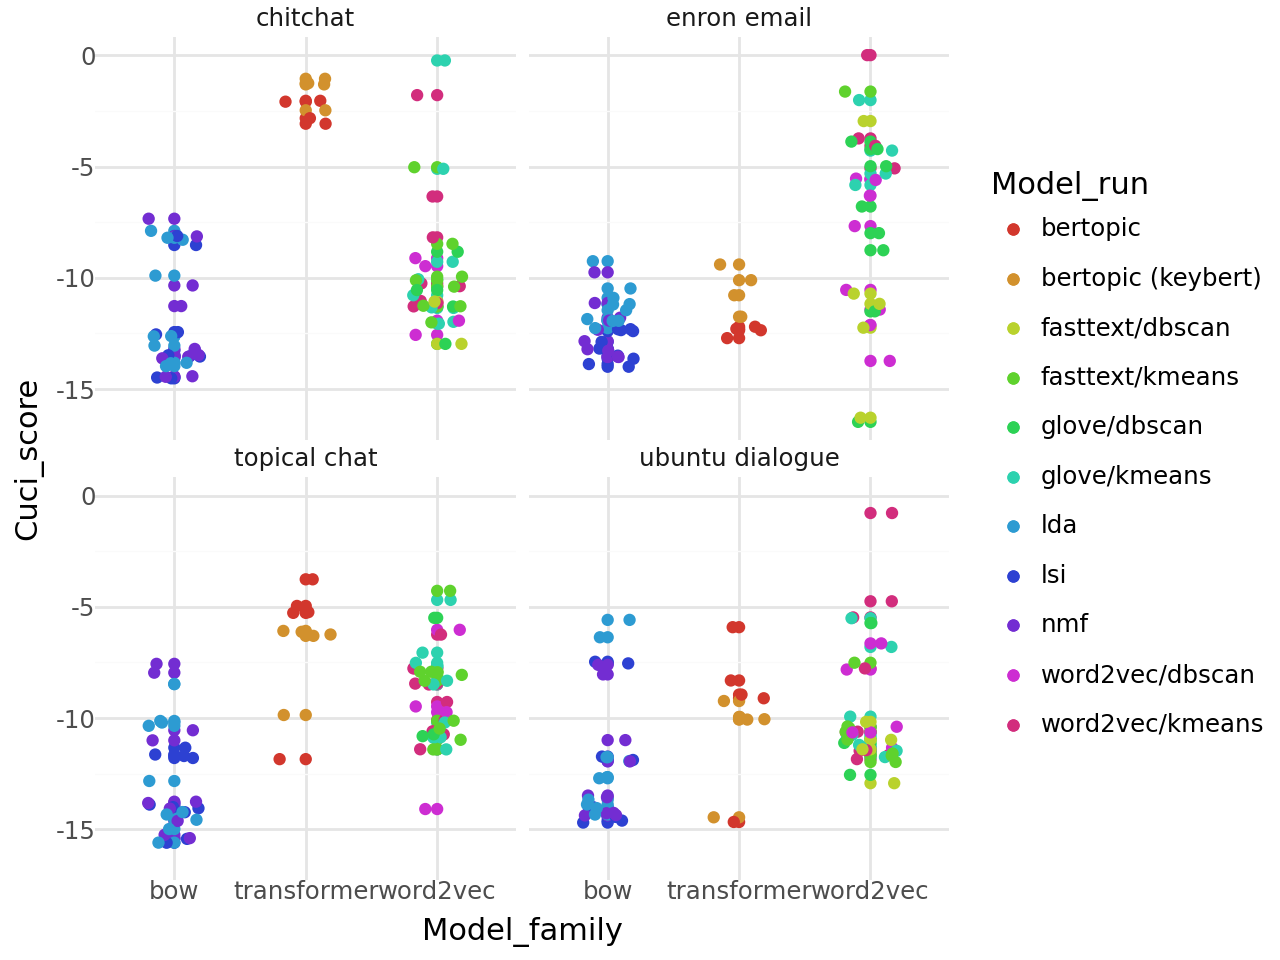

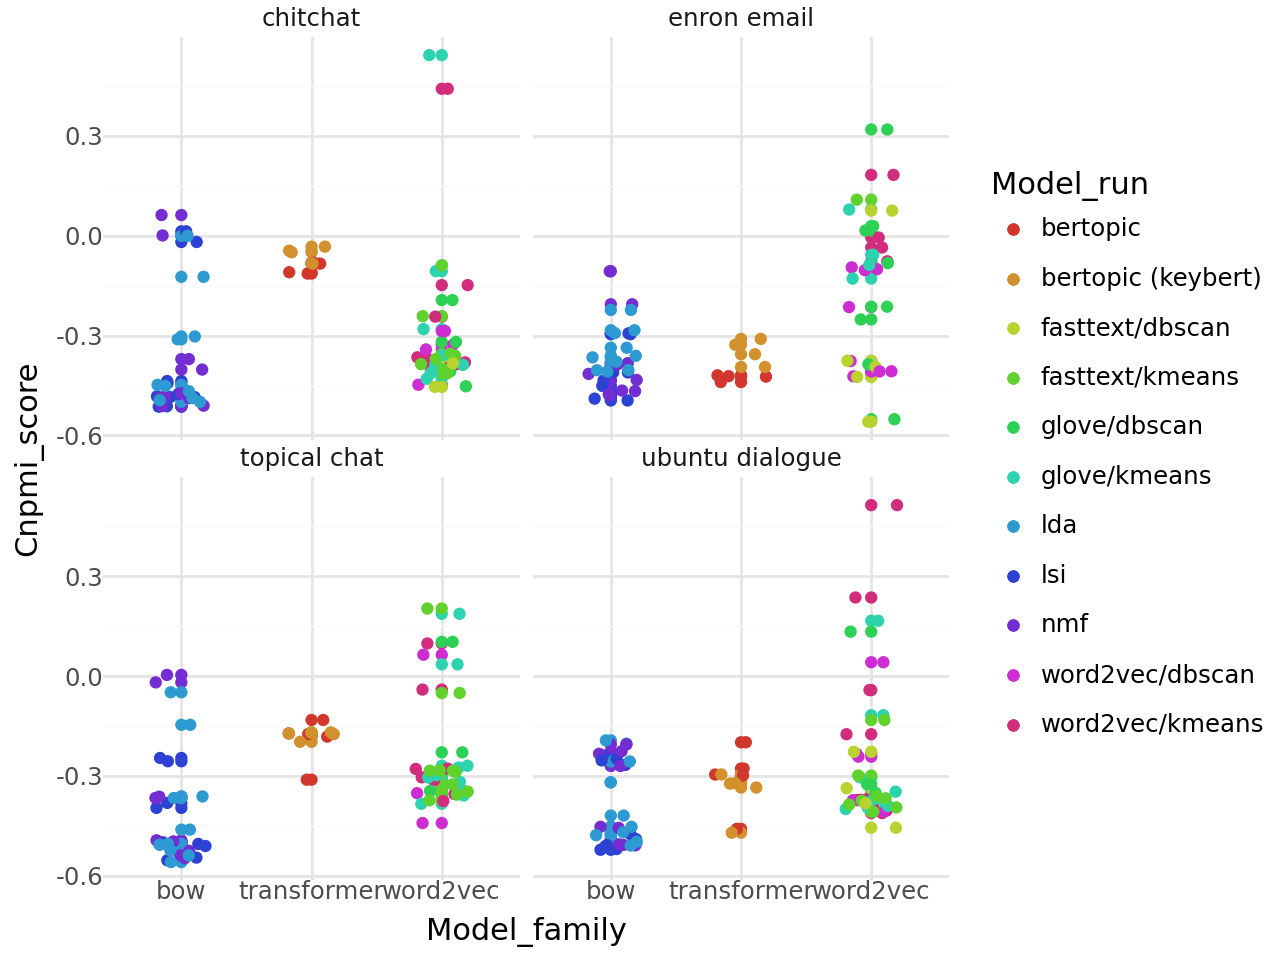

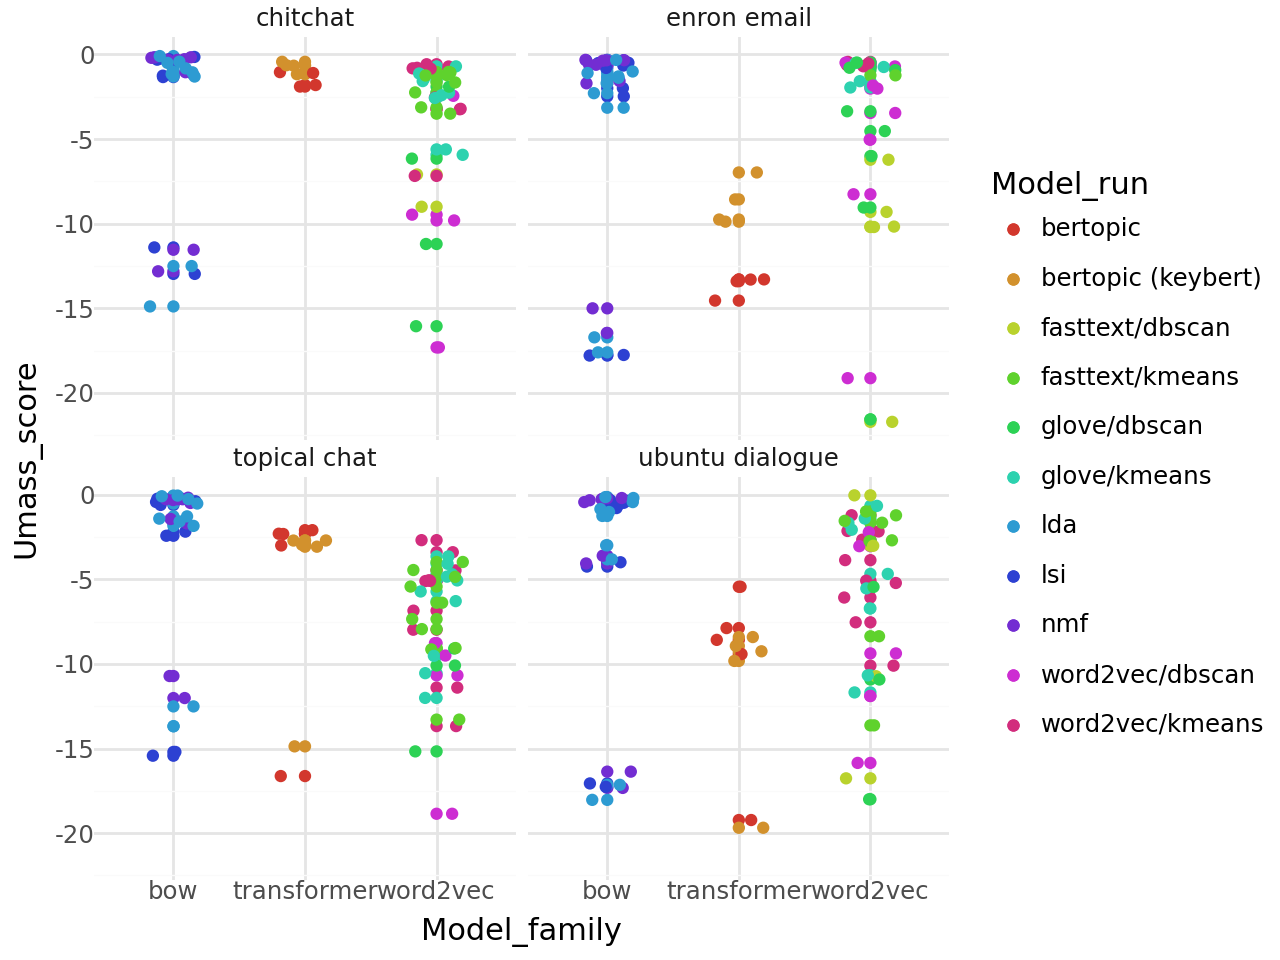

In [482]:
# Plot coh scores by dataset & model
display(plot_coh('Cv_score'))
display(plot_coh('Cuci_score'))
display(plot_coh('Cnpmi_score'))
display(plot_coh('Umass_score'))


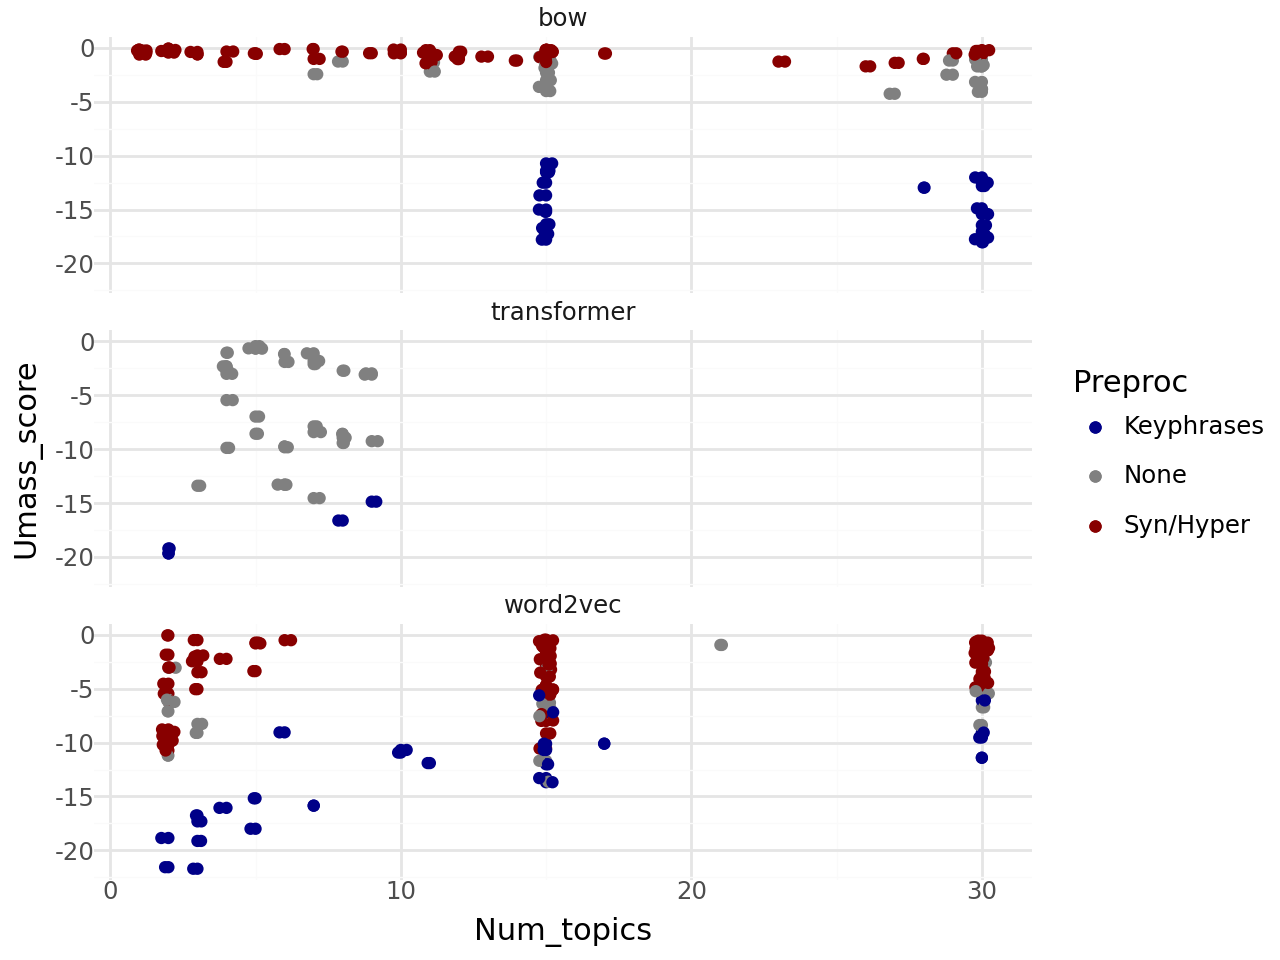

In [14]:
# Umass vs num topics
ggplot(dfr[~pd.isna(dfr['Umass_score'])]) + \
    aes(x='Num_topics', y='Umass_score', color='Preproc') + \
    geom_point(stat='identity') + \
    geom_jitter(width=0.25) + \
    theme_minimal() + \
    scale_colour_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    facet_wrap('Model_family', ncol=1)


In [611]:
# Function to display box plot
def show_boxplot(score_fld):
    """
    Purpose:                  To display a boxplot based on which coherence metric is specified.
    Parameters:
        score_fld             The name of the column containing the coherence metric.
    Returns:
        p                     The ggplot object.
    """
    p = ggplot(dfr[~pd.isna(dfr[score_fld])]) + \
        aes(x='Model_family', y=score_fld, color='Preproc') + \
        geom_boxplot(width=0.4) + \
        theme_minimal() + \
        theme(figure_size=(9, 5)) + \
        scale_colour_hue(l=0.4) + \
        facet_wrap('Dataset', ncol=2)
    return p


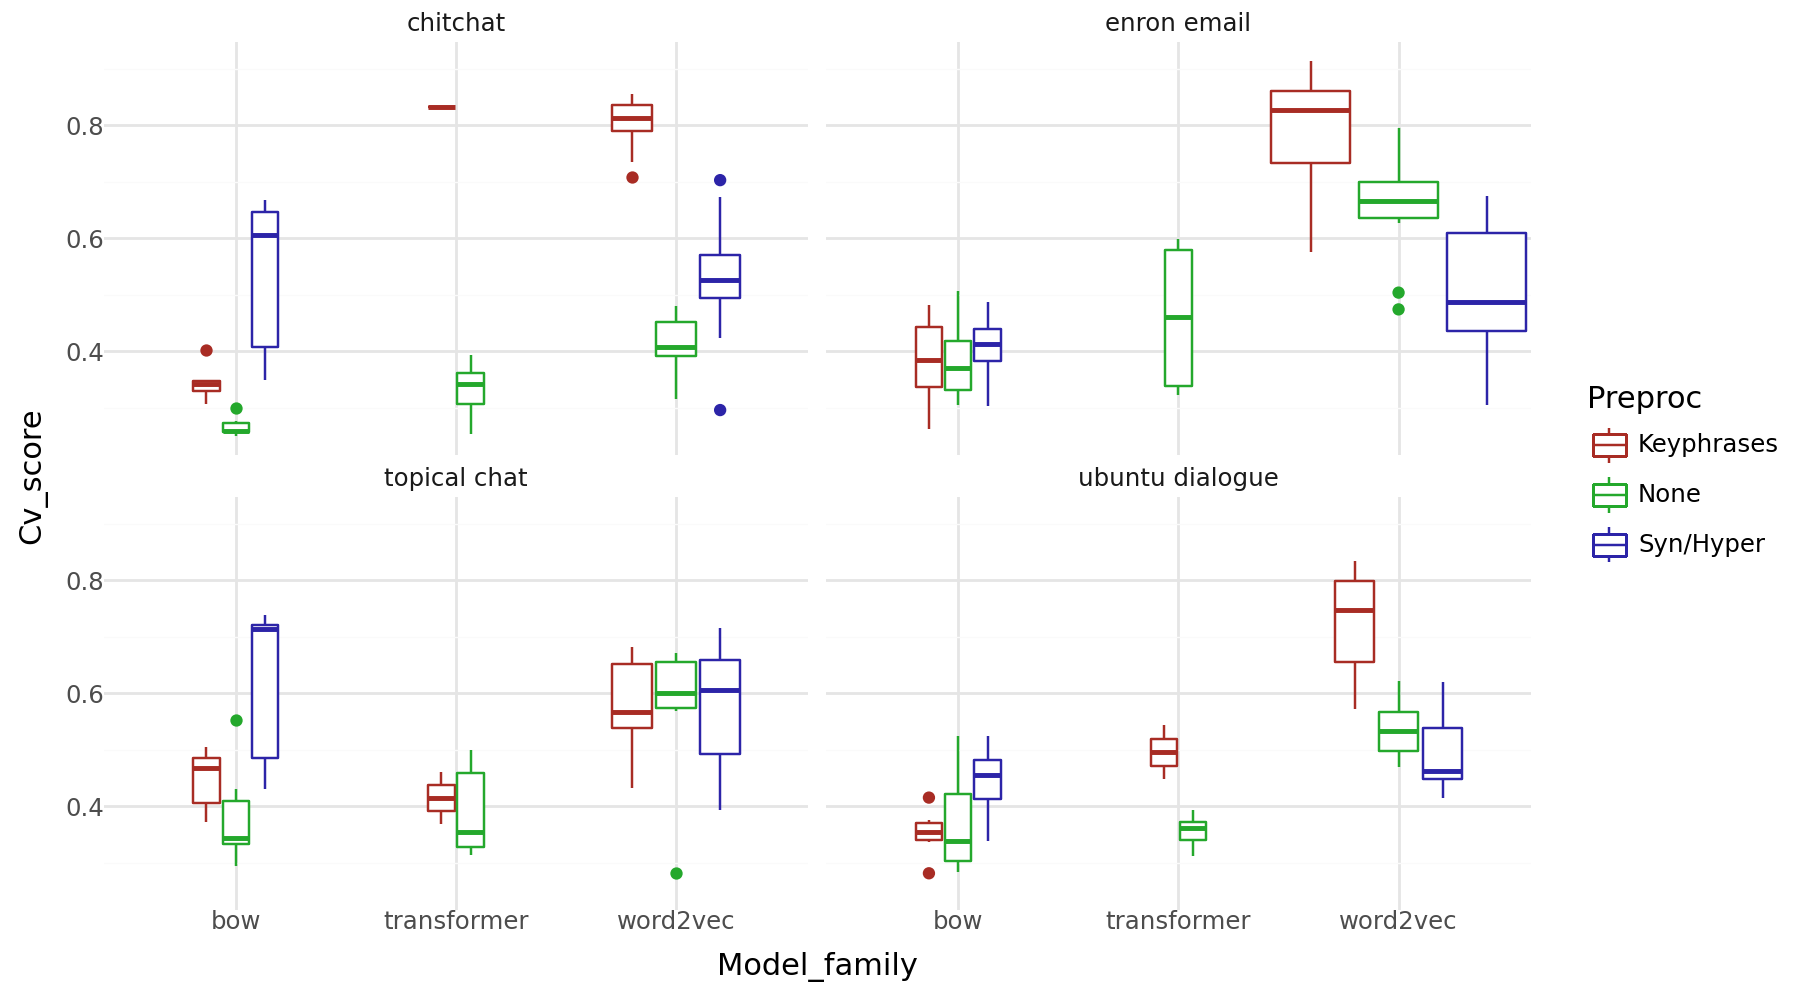

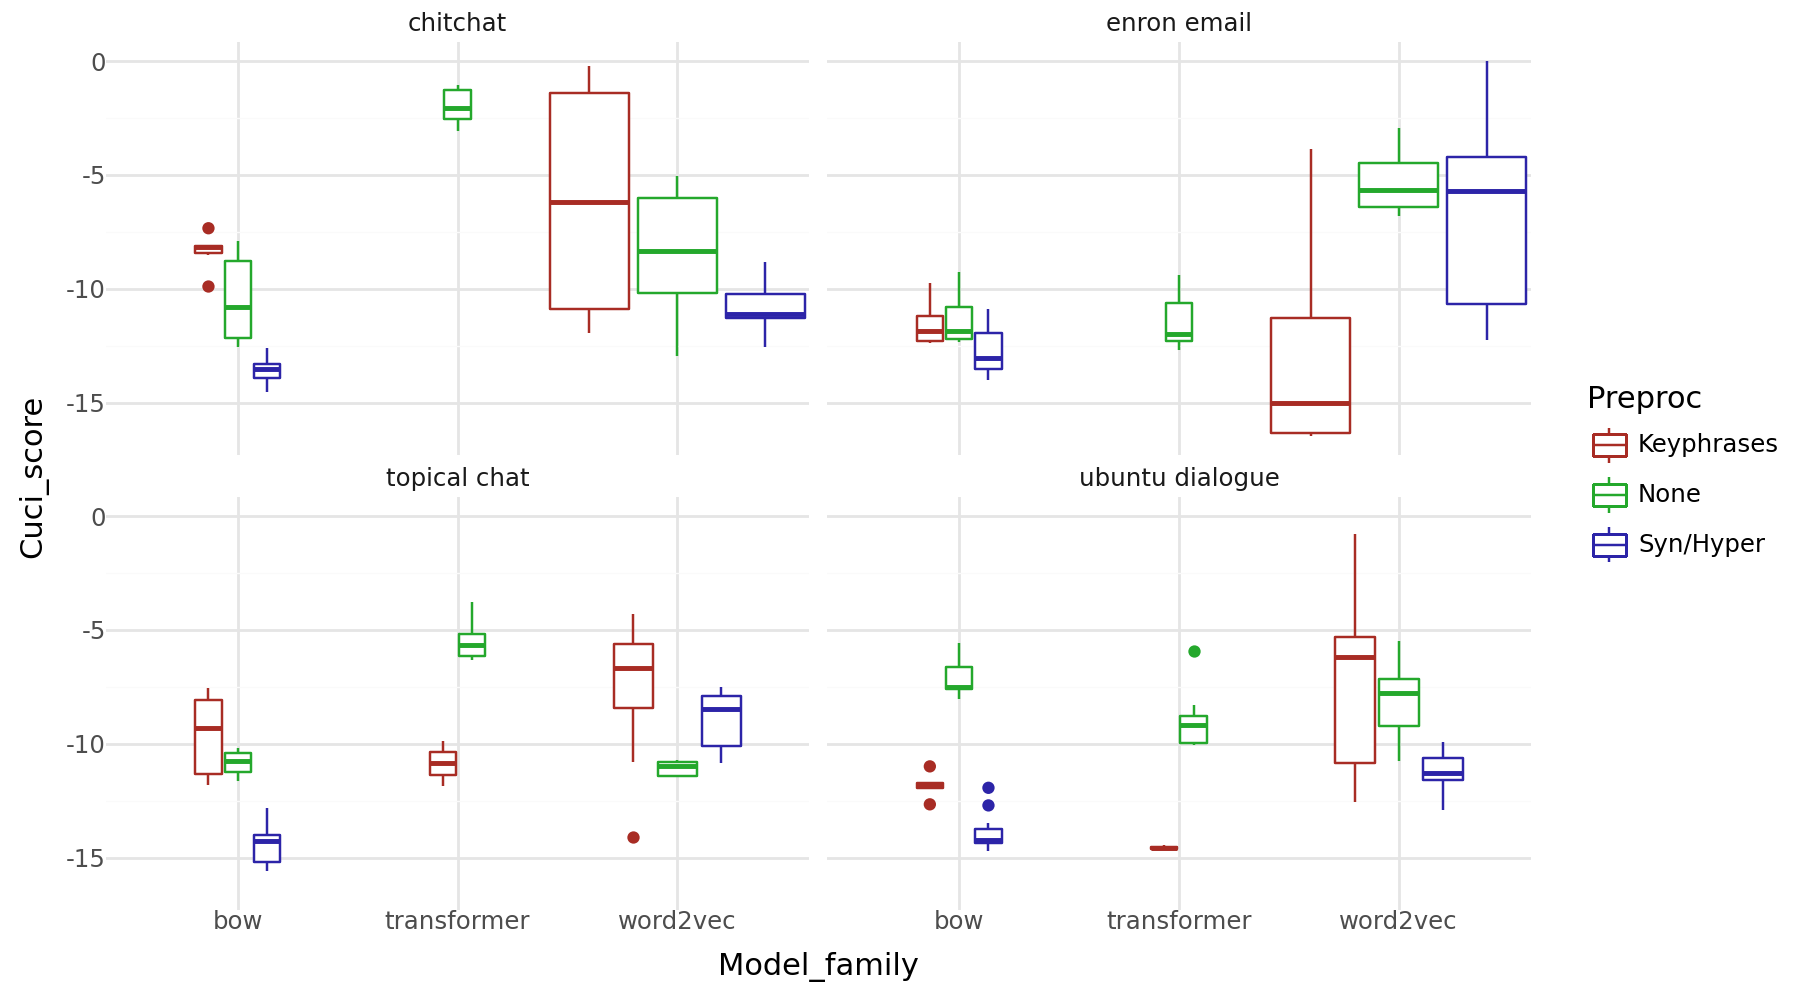

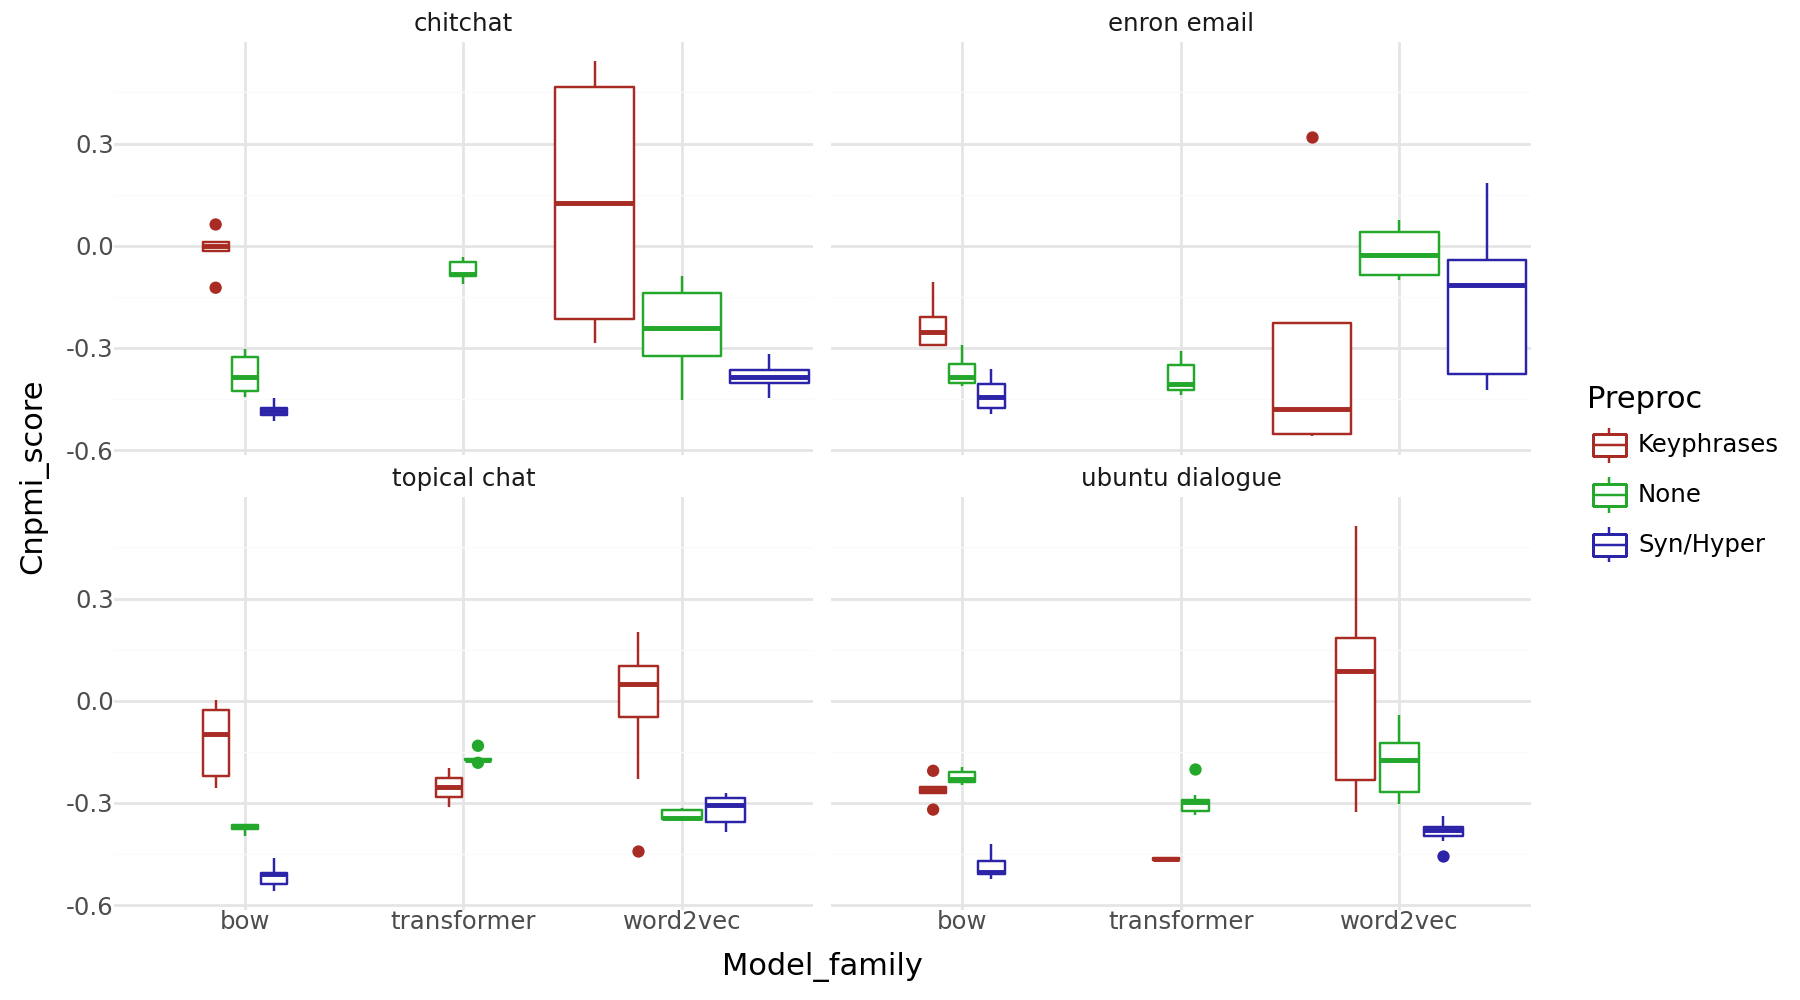

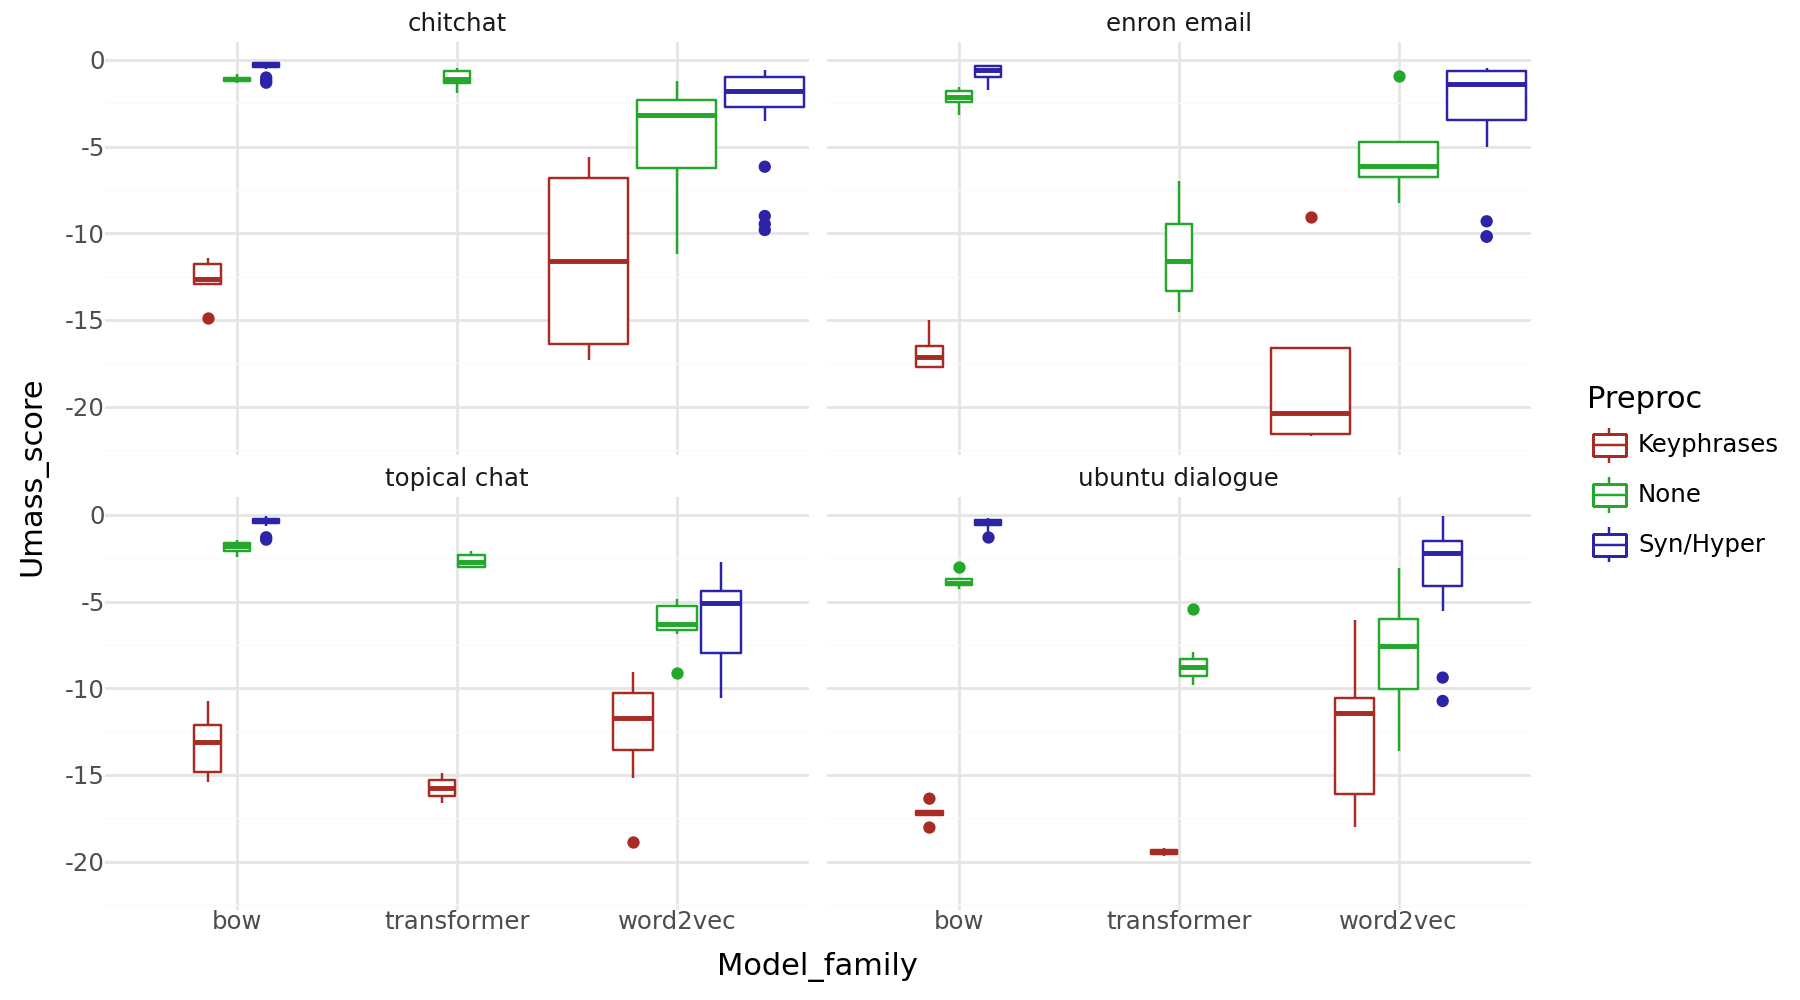

In [612]:
# Show boxplots by model family and preprocessing
display(show_boxplot('Cv_score'))
display(show_boxplot('Cuci_score'))
display(show_boxplot('Cnpmi_score'))
display(show_boxplot('Umass_score'))


### Topic relevance

This section performs modeling to predict topic relevance.


In [17]:
################################################################
# Modeling to predict relevance
################################################################

# Function to get cosine sim between a doc and a list of keywords
def get_cos_sim(row):

    # Get the topic words as  a space-separated list
    topic_words = row['Topic_words'].replace(',', ' ')

    # Calculate the cosine similarity between the document text and the topic words.
    # util.cos_sim takes two lists and calculates the cos similarity between all combinations of each item in both lists.
    # So if you have 2 elements in the first list and 3 in the second, you will get a 2x3 tensor returned.
    # Since we are only passing a single topic in the first list and a list of documents in the second, the cos_sim will return
    # a 1x[num_docs] tensor, and we only need the first element in the outer list since there is only one element. Hence, the [0] below.
    embeddings1 = sentence_model.encode(topic_words)
    embeddings2 = sentence_model.encode(row['Conv'])
    cos_scores = util.cos_sim(embeddings1, embeddings2).tolist()[0]
    #print(row['Row_id'], cos_scores[0])
    return cos_scores[0]


In [18]:
# Function to get the topic number from a list or dict of topics
def get_topic_num(all_topics, docnum):
    """
    Purpose:                     To look up the topic number assigned to a specified document number.
    Parameters:
        all_topics               The list of document numbers keyed on topic number.
        docnum                   The document number to look up.
    Returns:
        topicnum                 The topic number associated with the specified document number.
    """

    # all_topics can either look like this:
    # {0: [2, 10, 24, 25, 55, 66, 74, 80, 83, 92, 10...
    # or like this:
    # [{-1: [0, 1, 2, 3, 4, 5, 10, 11, 16, 17, 18, 2...
    
    # See if it's a list or a dict
    if type(all_topics) == list:  # bertopic Doc_topics will be a list of dicts, with each dict having a single entry having a key equal to the topic number
        tmp = {}
        for d in all_topics:
            for k in d.keys():
                tmp[k] = d[k]
        all_topics = tmp
    topicnum = [topicnum for topicnum in all_topics.keys() if docnum in all_topics[topicnum]][0]
    return topicnum


In [19]:
# Function to get topic representations
def get_topic_repr(all_topics, colname, topicid):
    """
    Purpose:                     To return the topic representation given a certain topic number.
    Parameters:
        all_topics               The list of all topic representations keyed on topic number.
        colname                  The name of the column containing the topic representation to look up.
        topicid                  The topic number for which to return the topic representations.
    Returns:
        topic                    The topic representation to return given the specified topic number.
    """

    # See if we're looking for the standard topic words or the flan topic word
    if colname == 'Topic_words':
        topic = [word[0] for word in [topic_tuple[1][:num_topic_words] for topic_tuple in all_topics if topic_tuple[0] == topicid][0]]
        topic = ', '.join(topic)
    elif colname == 'Flan_topic' or colname == 'Flan_topic2':
        all_topics = json.loads(all_topics)
        try:
            topic = [topic[1] for topic in all_topics if topic[0] == topicid][0]
        except Exception as ex:
            print(ex)
            print(colname, topicid)
            print(all_topics)
            topic = ''

    # Return
    if type(topic) == list and len(topic) == 0:
        topic = ''
    return topic


In [485]:
# Get cosin similarity for flan, flan2, and human friendly topics - this was already done and saved to pickle file
print(np.unique(dfrel['Set_id']))

"""
# Correct cos sim of flan_topic and flan_topic2 rows
dfrel.loc[dfrel['Set_id'].isin(['Flan_topic', 'Flan_topic2', 'Human_friendly_topic']), 'Cosine_similarity'] = pd.NA
dfrel.loc[dfrel['Set_id'] == 'Human_keywords', 'Cosine_similarity'] = dfrel[dfrel['Set_id'] == 'Human_keywords'].apply(get_cos_sim, axis=1)
dfrel.loc[dfrel['Set_id'] == 'Flan_topic', 'Cosine_similarity'] = dfrel[dfrel['Set_id'] == 'Flan_topic'].apply(get_cos_sim, axis=1)
dfrel.loc[dfrel['Set_id'] == 'Flan_topic2', 'Cosine_similarity'] = dfrel[dfrel['Set_id'] == 'Flan_topic2'].apply(get_cos_sim, axis=1)
dfrel.loc[dfrel['Set_id'] == 'Human_friendly_topic', 'Cosine_similarity'] = dfrel[dfrel['Set_id'] == 'Human_friendly_topic'].apply(get_cos_sim, axis=1)

# Save to pickle
timestamp = str(pd.Timestamp.now())[:19].replace('-', '').replace(' ', '_').replace(':', '')
dfrel.to_pickle('C:\\tmp\\pickles\\relevance\\dfrel_' + timestamp + '.pkl')
"""


['Flan_topic' 'Flan_topic2' 'Human_friendly_topic' 'Human_keywords'
 'Topic_words']


"\n# Correct cos sim of flan_topic and flan_topic2 rows\ndfrel.loc[dfrel['Set_id'].isin(['Flan_topic', 'Flan_topic2', 'Human_friendly_topic']), 'Cosine_similarity'] = pd.NA\ndfrel.loc[dfrel['Set_id'] == 'Human_keywords', 'Cosine_similarity'] = dfrel[dfrel['Set_id'] == 'Human_keywords'].apply(get_cos_sim, axis=1)\ndfrel.loc[dfrel['Set_id'] == 'Flan_topic', 'Cosine_similarity'] = dfrel[dfrel['Set_id'] == 'Flan_topic'].apply(get_cos_sim, axis=1)\ndfrel.loc[dfrel['Set_id'] == 'Flan_topic2', 'Cosine_similarity'] = dfrel[dfrel['Set_id'] == 'Flan_topic2'].apply(get_cos_sim, axis=1)\ndfrel.loc[dfrel['Set_id'] == 'Human_friendly_topic', 'Cosine_similarity'] = dfrel[dfrel['Set_id'] == 'Human_friendly_topic'].apply(get_cos_sim, axis=1)\n\n# Save to pickle\ntimestamp = str(pd.Timestamp.now())[:19].replace('-', '').replace(' ', '_').replace(':', '')\ndfrel.to_pickle('C:\\tmp\\pickles\\relevance\\dfrel_' + timestamp + '.pkl')\n"

In [563]:
display(dfrel)


,Dataset,Doc_num,Row_id,Set_id,Quality,Source,Doc_id,Relevant,Topic_words,Cosine_similarity,Conv
0,ee,70.0,72,Topic_words,3,Author,287.0,1.0,"HOU,forward,iSubject,ECT,John,Enron,Phillip,te...",0.251097,"Tim,\nmike grigsby is having problems with acc..."
1,ee,70.0,72,Flan_topic,1,Author,287.0,0.0,iSubject,0.016811,"Tim,\nmike grigsby is having problems with acc..."
2,ee,70.0,72,Flan_topic2,1,Author,287.0,0.0,Electrical healing,0.062604,"Tim,\nmike grigsby is having problems with acc..."
3,ee,235.0,242,Topic_words,1,Author,1881.0,0.0,"pass,realise,realize,sustain,catch,bear,genera...",0.055758,"Phillip,\nBarry had said that you were asking ..."
4,ee,235.0,242,Flan_topic,1,Author,1881.0,0.0,Science/Tech,-0.000527,"Phillip,\nBarry had said that you were asking ..."
...,...,...,...,...,...,...,...,...,...,...,...
1342,ud,249.0,396,Flan_topic,3,MTurk,6584.0,1.0,Linux,0.208897,"aanonymouss: In order to run VNC (like vino, r..."
1343,ud,249.0,396,Flan_topic,5,MTurk,6584.0,1.0,Linux,0.208897,"aanonymouss: In order to run VNC (like vino, r..."
1344,ud,249.0,396,Flan_topic2,3,MTurk,6584.0,1.0,Science/Tech,-0.093504,"aanonymouss: In order to run VNC (like vino, r..."
1345,ud,249.0,396,Flan_topic2,4,MTurk,6584.0,1.0,Science/Tech,-0.093504,"aanonymouss: In order to run VNC (like vino, r..."


In [819]:
# Quick look
print(np.unique(dfrel['Set_id']))
print(dfrel.columns)
print(dfr.columns)
display(dfrel.head())
print()

# Merge the modeling result set with the relevance df
dfr2 = dfr.copy()
dfr2.rename(columns={'index': 'Row_id'}, inplace=True)
dfr2.drop(columns=['Dataset', 'Num_docs', 'Rnd_seed', 'Cv_score', 'Cuci_score', 'Cnpmi_score', 'Umass_score', 'Runtime', 'Timestamp', 'Topic_words', 'Doc_topics', \
                   'Flan_topic', 'Cosine_similarity', 'Topic_words2', 'Flan_topic2', 'Model_params', 'Cosine_similarity_flan', 'Cosine_similarity_flan2'], inplace=True)
dfm = dfrel.merge(dfr2, on=['Row_id'], how='left').drop(columns=['Row_id', 'Doc_id', 'Quality', 'Preproc', 'Doc_num', 'Topic_words', 'Conv'])

# Rename Set_id
dfm.rename(columns={'Set_id': 'Representation'}, inplace=True)

# Fill in values for rows with human keyword
#dfm.loc[dfm['Representation'].str.startswith('Human'), 'Preproc'] = 'None'
dfm.loc[dfm['Representation'].str.startswith('Human'), 'Model_family'] = 'Human'
dfm.loc[dfm['Representation'].str.startswith('Human'), 'Model_run'] = dfm['Representation']
dfm.loc[dfm['Representation'].str.startswith('Human'), 'Model'] = dfm['Representation']
dfm.loc[dfm['Representation']=='Human_keywords', 'Num_topics'] = 1
dfm.loc[dfm['Representation']=='Human_friendly_topic', 'Num_topics'] = 1
dfm.loc[dfm['Representation'].str.startswith('Human'), 'Spell_checked'] = False
dfm.loc[dfm['Representation'].str.startswith('Human'), 'Text_speak'] = False
dfm.loc[dfm['Representation'].str.startswith('Human'), 'Synonyms'] = False
dfm.loc[dfm['Representation'].str.startswith('Human'), 'Hypernyms'] = False
dfm.loc[dfm['Representation'].str.startswith('Human'), 'Keyphrases'] = False

# Display
print(dfm.shape)
display(dfm.head(8))
print()

# Counts
print(dfrel.shape)
print(dfr.shape)
print(dfm.shape)
print(dfm.columns)
print()
print(Counter(dfm['Source']))
print()
print(Counter(dfm['Relevant']))
print()

# Check for NAs
print('NAs:')
print(dfm.isna().sum())


['Flan_topic' 'Flan_topic2' 'Human_friendly_topic' 'Human_keywords'
 'Topic_words']
Index(['Dataset', 'Doc_num', 'Row_id', 'Set_id', 'Quality', 'Source', 'Doc_id',
       'Relevant', 'Topic_words', 'Cosine_similarity', 'Conv'],
      dtype='object')
Index(['Row_id', 'Dataset', 'Num_docs', 'Rnd_seed', 'Model', 'Num_topics',
       'Model_params', 'Cv_score', 'Cuci_score', 'Cnpmi_score', 'Umass_score',
       'Spell_checked', 'Text_speak', 'Synonyms', 'Hypernyms', 'Runtime',
       'Timestamp', 'Topic_words', 'Doc_topics', 'Flan_topic',
       'Cosine_similarity', 'Model_family', 'Topic_words2', 'Flan_topic2',
       'Keyphrases', 'Cosine_similarity_flan', 'Cosine_similarity_flan2',
       'Preproc', 'Model_run'],
      dtype='object')


,Dataset,Doc_num,Row_id,Set_id,Quality,Source,Doc_id,Relevant,Topic_words,Cosine_similarity,Conv
0,ee,70.0,72,Topic_words,3,Author,287.0,1.0,"HOU,forward,iSubject,ECT,John,Enron,Phillip,te...",0.251097,"Tim,\nmike grigsby is having problems with acc..."
1,ee,70.0,72,Flan_topic,1,Author,287.0,0.0,iSubject,0.016811,"Tim,\nmike grigsby is having problems with acc..."
2,ee,70.0,72,Flan_topic2,1,Author,287.0,0.0,Electrical healing,0.062604,"Tim,\nmike grigsby is having problems with acc..."
3,ee,235.0,242,Topic_words,1,Author,1881.0,0.0,"pass,realise,realize,sustain,catch,bear,genera...",0.055758,"Phillip,\nBarry had said that you were asking ..."
4,ee,235.0,242,Flan_topic,1,Author,1881.0,0.0,Science/Tech,-0.000527,"Phillip,\nBarry had said that you were asking ..."



(1347, 14)


,Dataset,Representation,Source,Relevant,Cosine_similarity,Model,Num_topics,Spell_checked,Text_speak,Synonyms,Hypernyms,Model_family,Keyphrases,Model_run
0,ee,Topic_words,Author,1.0,0.251097,lsi,15.0,True,True,False,False,bow,False,lsi
1,ee,Flan_topic,Author,0.0,0.016811,lsi,15.0,True,True,False,False,bow,False,lsi
2,ee,Flan_topic2,Author,0.0,0.062604,lsi,15.0,True,True,False,False,bow,False,lsi
3,ee,Topic_words,Author,0.0,0.055758,word2vec,15.0,True,True,True,False,word2vec,False,word2vec/kmeans
4,ee,Flan_topic,Author,0.0,-0.000527,word2vec,15.0,True,True,True,False,word2vec,False,word2vec/kmeans
5,ee,Flan_topic2,Author,1.0,-0.055280,word2vec,15.0,True,True,True,False,word2vec,False,word2vec/kmeans
6,ee,Topic_words,Author,0.0,0.108371,lsi,8.0,True,True,True,True,bow,False,lsi
7,ee,Flan_topic,Author,0.0,-0.024265,lsi,8.0,True,True,True,True,bow,False,lsi



(1347, 11)
(400, 29)
(1347, 14)
Index(['Dataset', 'Representation', 'Source', 'Relevant', 'Cosine_similarity',
       'Model', 'Num_topics', 'Spell_checked', 'Text_speak', 'Synonyms',
       'Hypernyms', 'Model_family', 'Keyphrases', 'Model_run'],
      dtype='object')

Counter({'MTurk': 891, 'Author': 456})

Counter({1.0: 689, 0.0: 658})

NAs:
Dataset              0
Representation       0
Source               0
Relevant             0
Cosine_similarity    0
Model                0
Num_topics           0
Spell_checked        0
Text_speak           0
Synonyms             0
Hypernyms            0
Model_family         0
Keyphrases           0
Model_run            0
dtype: int64


Counter({1.0: 689, 0.0: 658})


,tmprel,Source,Dataset,Representation,Cosine_similarity,Model,Num_topics,Spell_checked,Text_speak,Synonyms,Hypernyms,Model_family,Keyphrases,Model_run,Relevant
0,0.0,Author,414,414,414,414,414,414,414,414,414,414,414,414,no
1,0.0,MTurk,244,244,244,244,244,244,244,244,244,244,244,244,no
2,1.0,Author,42,42,42,42,42,42,42,42,42,42,42,42,yes
3,1.0,MTurk,647,647,647,647,647,647,647,647,647,647,647,647,yes


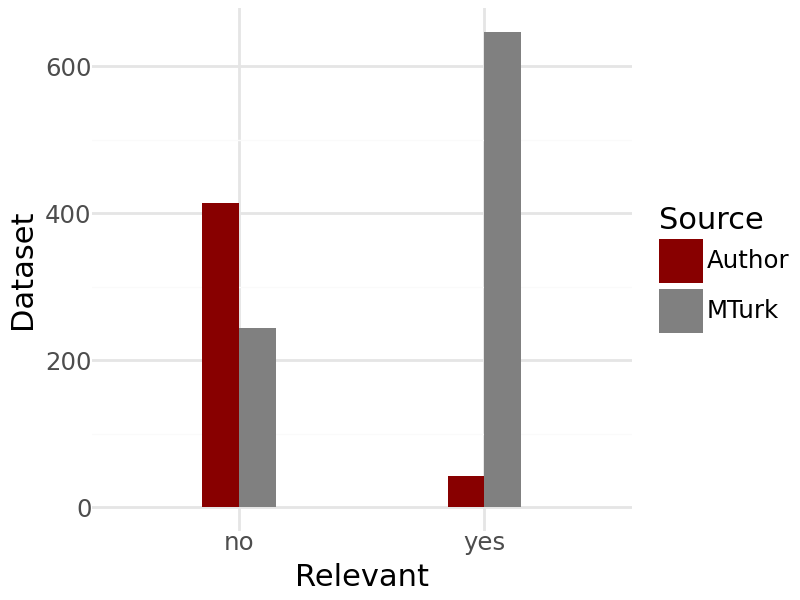

(1347, 37)


,Relevant,Cosine_similarity,Num_topics,Dataset_ee,Dataset_tc,Dataset_ud,Representation_Flan_topic2,Representation_Human_friendly_topic,Representation_Human_keywords,Representation_Topic_words,...,Model_run_bertopic (keybert),Model_run_fasttext/dbscan,Model_run_fasttext/kmeans,Model_run_glove/dbscan,Model_run_glove/kmeans,Model_run_lda,Model_run_lsi,Model_run_nmf,Model_run_word2vec/dbscan,Model_run_word2vec/kmeans
0,1.0,0.251097,15.0,True,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
1,0.0,0.016811,15.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,0.0,0.062604,15.0,True,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0.0,0.055758,15.0,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
4,0.0,-0.000527,15.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,1.0,0.208897,2.0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1343,1.0,0.208897,2.0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1344,1.0,-0.093504,2.0,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1345,1.0,-0.093504,2.0,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Counter({1.0: 482, 0.0: 460})


,Relevant,Cosine_similarity,Num_topics,Dataset_ee,Dataset_tc,Dataset_ud,Representation_Flan_topic2,Representation_Human_friendly_topic,Representation_Human_keywords,Representation_Topic_words,...,Model_run_bertopic (keybert),Model_run_fasttext/dbscan,Model_run_fasttext/kmeans,Model_run_glove/dbscan,Model_run_glove/kmeans,Model_run_lda,Model_run_lsi,Model_run_nmf,Model_run_word2vec/dbscan,Model_run_word2vec/kmeans
870,1.0,0.481403,1.0,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
48,0.0,0.317398,30.0,True,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
620,1.0,0.310013,7.0,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1031,1.0,0.653852,1.0,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
887,0.0,0.098247,4.0,False,True,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False


Index(['Relevant', 'Cosine_similarity', 'Num_topics', 'Dataset_ee',
       'Dataset_tc', 'Dataset_ud', 'Representation_Flan_topic2',
       'Representation_Human_friendly_topic', 'Representation_Human_keywords',
       'Representation_Topic_words', 'Source_MTurk', 'Model_Human_keywords',
       'Model_bertopic', 'Model_lda', 'Model_lsi', 'Model_nmf',
       'Model_word2vec', 'Spell_checked_True', 'Text_speak_True',
       'Synonyms_True', 'Hypernyms_True', 'Model_family_bow',
       'Model_family_transformer', 'Model_family_word2vec', 'Keyphrases_True',
       'Model_run_Human_keywords', 'Model_run_bertopic',
       'Model_run_bertopic (keybert)', 'Model_run_fasttext/dbscan',
       'Model_run_fasttext/kmeans', 'Model_run_glove/dbscan',
       'Model_run_glove/kmeans', 'Model_run_lda', 'Model_run_lsi',
       'Model_run_nmf', 'Model_run_word2vec/dbscan',
       'Model_run_word2vec/kmeans'],
      dtype='object')
942
405
942
405


In [820]:
# Evaluate how balanced our training data is
print(Counter(dfm['Relevant']))
dfg = dfm.groupby(['Relevant', 'Source']).count().reset_index()
dfg.rename(columns={'Relevant': 'tmprel'}, inplace=True)
dfg.loc[dfg['tmprel'] == 1, 'Relevant'] = 'yes'
dfg.loc[dfg['tmprel'] == 0, 'Relevant'] = 'no'
display(dfg)
p = ggplot(dfg) + \
    aes(x='Relevant', y='Dataset', fill='Source') + \
    geom_bar(stat='identity', width=0.3, position='dodge') + \
    scale_fill_manual({'Author': '#880000', 'MTurk': '#808080'}) + \
    theme_minimal() + \
    theme(figure_size=(4, 3))
display(p)

# Dummies
dfm2 = pd.get_dummies(dfm, prefix_sep='_', drop_first=True)
print(dfm2.shape)
display(dfm2)

# Partition the data
(dftrainset, dftestset) = train_test_split(dfm2, test_size=0.3, random_state=77, shuffle=True, stratify=dfm2['Relevant'])
print(Counter(dftrainset['Relevant']))
display(dftrainset.head())
print(dftrainset.columns)

# Convert to numpy arrays to fit into model
y_train = np.array(dftrainset['Relevant'])
y_test = np.array(dftestset['Relevant'])

# Drop y value
dftrainset.drop(columns=['Relevant'], inplace=True)
dftestset.drop(columns=['Relevant'], inplace=True)

# Convert to numpy array
x_train = np.array(dftrainset)
x_test = np.array(dftestset)

# Summary
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))


In [ ]:
# Logistic regression
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None]
}
print(param_grid)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=77)
grid_log = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=cv, verbose=2, n_jobs=-1)
grid_log.fit(x_train, y_train)
print(grid_log.best_params_, grid_log.best_score_)


In [489]:
# Score training and test sets
train_score_log = grid_log.score(x_train, y_train)
test_score_log = grid_log.score(x_test, y_test)
print('training score:', train_score_log)
print('test score:', test_score_log)


training score: 0.7749469214437368
test score: 0.7975308641975308


In [490]:
# Categorical naive bayes
param_grid = {
    'alpha': np.linspace(0.0001, 1, 10),
    'force_alpha': [True, False]
}
print(param_grid)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=77)
grid_cnb = GridSearchCV(CategoricalNB(), param_grid=param_grid, cv=cv, verbose=2, n_jobs=-1)
grid_cnb.fit(x_train, y_train)
print(grid_cnb.best_params_, grid_cnb.best_score_)


{'alpha': array([1.000e-04, 1.112e-01, 2.223e-01, 3.334e-01, 4.445e-01, 5.556e-01,
       6.667e-01, 7.778e-01, 8.889e-01, 1.000e+00]), 'force_alpha': [True, False]}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'alpha': 0.0001, 'force_alpha': True} 0.7328621908127209


In [491]:
# Score training and test sets
train_score_cnb = grid_cnb.score(x_train, y_train)
test_score_cnb = grid_cnb.score(x_test, y_test)
print('training score:', train_score_cnb)
print('test score:', test_score_cnb)


training score: 0.7377919320594479
test score: 0.7753086419753087


In [492]:
# Linear discriminant analysis
param_grid = {
    'shrinkage': np.linspace(0.0001, 1.0, 10),
    'solver': ['lsqr', 'eigen']
}
print(param_grid)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=77)
grid_lda = GridSearchCV(LinearDiscriminantAnalysis(), param_grid=param_grid, cv=cv, verbose=2, n_jobs=-1)
grid_lda.fit(x_train, y_train)
print(grid_lda.best_params_, grid_lda.best_score_)


{'shrinkage': array([1.000e-04, 1.112e-01, 2.223e-01, 3.334e-01, 4.445e-01, 5.556e-01,
       6.667e-01, 7.778e-01, 8.889e-01, 1.000e+00]), 'solver': ['lsqr', 'eigen']}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'shrinkage': 0.0001, 'solver': 'lsqr'} 0.7745583038869258


In [493]:
# Score training and test sets
train_score_lda = grid_lda.score(x_train, y_train)
test_score_lda = grid_lda.score(x_test, y_test)
print('training score:', train_score_lda)
print('test score:', test_score_lda)


training score: 0.7760084925690022
test score: 0.8098765432098766


In [227]:
# KNN classifier
param_grid = {
    'n_neighbors': np.linspace(1, 16, num=16, dtype=int)
}
print(param_grid)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=77)
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv, verbose=2, n_jobs=-1)
grid_knn.fit(x_train, y_train)
print(grid_knn.best_params_, grid_knn.best_score_)


{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'n_neighbors': 15} 0.7250883392226148


In [228]:
# Score training and test sets
train_score_knn = grid_knn.score(x_train, y_train)
test_score_knn = grid_knn.score(x_test, y_test)
print('training score:', train_score_knn)
print('test score:', test_score_knn)


training score: 0.7569002123142251
test score: 0.7679012345679013


In [229]:
# SVM classifier
param_grid = {
    'gamma': np.logspace(-2, 9, 6),
    'C': np.logspace(-8, 3, 6)
}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=77)
grid_svm = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv, verbose=2, n_jobs=-1)
grid_svm.fit(x_train, y_train)
print(grid_svm.best_params_, grid_svm.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'C': 6.309573444801943, 'gamma': 0.01} 0.7837455830388692


In [230]:
# Score training and test sets
train_score_svm = grid_svm.score(x_train, y_train)
test_score_svm = grid_svm.score(x_test, y_test)
print('training score:', train_score_svm)
print('test score:', test_score_svm)


training score: 0.778131634819533
test score: 0.8098765432098766


In [749]:
# Decision tree classifier
param_grid = {
    'max_depth': np.linspace(1, 16, num=16, dtype=int),
    'ccp_alpha': np.logspace(0.0001, 100, num=6),
    'min_samples_split': np.linspace(2, 5, num=4, dtype=int),
    'min_samples_leaf': np.linspace(1, 4, num=4, dtype=int)
}
print(param_grid)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=7)
grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=cv, verbose=2, n_jobs=-1)
grid_tree.fit(x_train, y_train)
print(grid_tree.best_params_, grid_tree.best_score_)


{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'ccp_alpha': array([1.00023029e+000, 1.00018422e+020, 1.00013816e+040, 1.00009211e+060,
       1.00004605e+080, 1.00000000e+100]), 'min_samples_split': array([2, 3, 4, 5]), 'min_samples_leaf': array([1, 2, 3, 4])}
Fitting 5 folds for each of 1536 candidates, totalling 7680 fits
{'ccp_alpha': 1.0002302850208247, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2} 0.5123674911660777


In [750]:
# Score training and test sets
train_score_tree = grid_tree.score(x_train, y_train)
test_score_tree = grid_tree.score(x_test, y_test)
print('training score:', train_score_tree)
print('test score:', test_score_tree)


training score: 0.5116772823779193
test score: 0.5111111111111111


In [242]:
# Random forest classifier
param_grid = {
    'n_estimators': [100, 1000],
    'max_depth': np.linspace(1, 8, num=4, dtype=int),
    'ccp_alpha': np.logspace(0.0001, 100, num=4),
    'min_samples_split': np.linspace(2, 5, num=4, dtype=int),
    'min_samples_leaf': np.linspace(1, 4, num=4, dtype=int)
}
print(param_grid)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=7)
grid_forest = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=cv, verbose=2, n_jobs=-1)
grid_forest.fit(x_train, y_train)
print(grid_forest.best_params_, grid_forest.best_score_)


{'n_estimators': [100, 1000], 'max_depth': array([1, 3, 5, 8]), 'ccp_alpha': array([1.00023029e+000, 2.15476543e+033, 4.64194510e+066, 1.00000000e+100]), 'min_samples_split': array([2, 3, 4, 5]), 'min_samples_leaf': array([1, 2, 3, 4])}
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
{'ccp_alpha': 1.0002302850208247, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} 0.5123674911660777


In [243]:
# Score training and test sets
train_score_forest = grid_forest.score(x_train, y_train)
test_score_forest = grid_forest.score(x_test, y_test)
print('training score:', train_score_forest)
print('test score:', test_score_forest)


training score: 0.5116772823779193
test score: 0.5111111111111111


In [244]:
# Gradient bosting classifier
param_grid = {
    'n_estimators': [100, 1000],
    'learning_rate': np.linspace(0, 10000, num=4, dtype=float),
    'subsample': np.linspace(0.1, 1.0, num=4),
    'max_depth': np.linspace(1, 8, num=4, dtype=int),
    'ccp_alpha': np.logspace(0.0001, 100, num=4),
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
print(param_grid)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=7)
grid_boost = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, cv=cv, verbose=3, n_jobs=-1)
grid_boost.fit(x_train, y_train)
print(grid_boost.best_params_, grid_boost.best_score_)


{'n_estimators': [100, 1000], 'learning_rate': array([    0.        ,  3333.33333333,  6666.66666667, 10000.        ]), 'subsample': array([0.1, 0.4, 0.7, 1. ]), 'max_depth': array([1, 3, 5, 8]), 'ccp_alpha': array([1.00023029e+000, 2.15476543e+033, 4.64194510e+066, 1.00000000e+100]), 'min_samples_split': [2], 'min_samples_leaf': [1]}
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
{'ccp_alpha': 1.0002302850208247, 'learning_rate': 0.0, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.1} 0.5123674911660777


In [245]:
# Score training and test sets
train_score_boost = grid_boost.score(x_train, y_train)
test_score_boost = grid_boost.score(x_test, y_test)
print('training score:', train_score_boost)
print('test score:', test_score_boost)


training score: 0.5116772823779193
test score: 0.5111111111111111


In [790]:
# Create df with modeling scores
dfscore = pd.DataFrame({
    'Model': ['logistic', 'naive_bayes', 'lda', 'knn', 'svm', 'tree', 'random_forest', 'gradient_boost'],
    'Best_params': [
        grid_log.best_params_, grid_cnb.best_params_, grid_lda.best_params_, grid_knn.best_params_, grid_svm.best_params_, \
        grid_tree.best_params_, grid_forest.best_params_, grid_boost.best_params_
    ],
    'Train_accuracy': [
        train_score_log, train_score_cnb, train_score_lda, train_score_knn, train_score_svm, \
        train_score_tree, train_score_forest, train_score_boost, 
    ],
    'Test_accuracy': [
        test_score_log, test_score_cnb, test_score_lda, test_score_knn, test_score_svm, \
        test_score_tree, test_score_forest, test_score_boost, 
    ]
})
dfscore['Best_params'] = dfscore['Best_params'].astype(str).str.wrap(60)
display(HTML(dfscore.sort_values(['Test_accuracy'], ascending=False).to_html().replace('\\n', '<br />')))


,Model,Best_params,Train_accuracy,Test_accuracy
2,lda,"{'shrinkage': 0.0001, 'solver': 'lsqr'}",0.776008,0.809877
4,svm,"{'C': 6.309573444801943, 'gamma': 0.01}",0.778132,0.809877
0,logistic,{'penalty': 'l2'},0.774947,0.797531
1,naive_bayes,"{'alpha': 0.0001, 'force_alpha': True}",0.737792,0.775309
3,knn,{'n_neighbors': 15},0.756900,0.767901
5,tree,"{'ccp_alpha': 1.0002302850208247, 'max_depth': 1,'min_samples_leaf': 1, 'min_samples_split': 2}",0.511677,0.511111
6,random_forest,"{'ccp_alpha': 1.0002302850208247, 'max_depth': 1,'min_samples_leaf': 1, 'min_samples_split': 2,'n_estimators': 100}",0.511677,0.511111
7,gradient_boost,"{'ccp_alpha': 1.0002302850208247, 'learning_rate': 0.0,'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split':2, 'n_estimators': 100, 'subsample': 0.1}",0.511677,0.511111


405 405


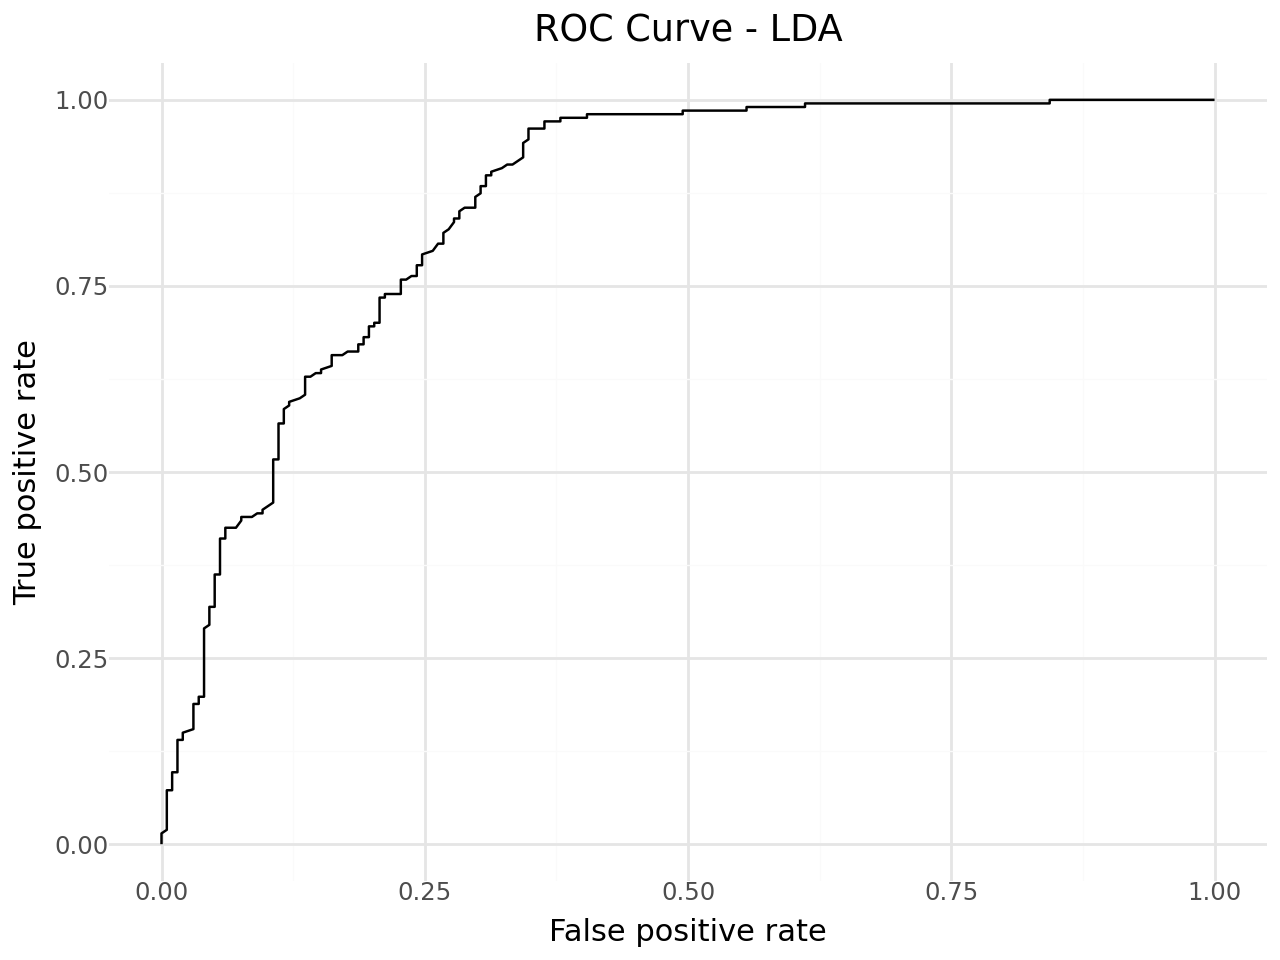

ROC AUC score=0.859598399453472

TPR:
[0.         0.00483092 0.01449275 0.01932367 0.02415459 0.03381643
 0.03864734 0.05797101 0.06280193 0.07246377 0.07246377 0.0821256
 0.09178744 0.09661836 0.09661836 0.11111111 0.12077295 0.12560386
 0.1352657  0.14009662 0.14009662 0.14975845 0.15458937 0.16908213
 0.1884058  0.1884058  0.19806763 0.19806763 0.23188406 0.24154589
 0.24637681 0.26570048 0.27536232 0.28502415 0.28985507 0.29468599
 0.30917874 0.31884058 0.31884058 0.33333333 0.34299517 0.36231884
 0.36231884 0.36714976 0.37681159 0.39130435 0.41062802 0.41062802
 0.41545894 0.42512077 0.42512077 0.43478261 0.43961353 0.43961353
 0.44444444 0.44444444 0.44927536 0.4589372  0.47826087 0.50724638
 0.51690821 0.51690821 0.53623188 0.54589372 0.56521739 0.56521739
 0.57004831 0.57971014 0.58454106 0.58937198 0.5942029  0.59903382
 0.60386473 0.62801932 0.62801932 0.63285024 0.63285024 0.63768116
 0.64251208 0.65217391 0.65700483 0.65700483 0.66183575 0.66183575
 0.67149758 0.67149758 0.

In [791]:
# ROC curve
y_pred = grid_lda.predict_proba(x_test)
print(len(y_test), len(y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1], pos_label=1.0)
p = ggplot() + \
        aes(x=fpr, y=tpr) + \
        geom_line() + \
        theme_minimal() + \
        ggtitle('ROC Curve') + \
        xlab('False positive rate') + \
        ylab('True positive rate') + \
        ggtitle('ROC Curve - LDA')
display(p)

# AUC
print(f"ROC AUC score={roc_auc_score(y_test, y_pred[:, 1])}")
print()

# Thresholds
print('TPR:')
print(tpr)
print()
print('Probability thresholds:')
print(thresholds)
print()


In [498]:
# These next few blocks will predict the relevance of the entire data set based on the results of the best model

# Look at columns used for training; dfm hold the non-dummy columns
print(dfm.columns)

# These are the columns that we'll need to gather into long table format
print(np.unique(dfm['Representation']))

# Compare to the resultset
print(dfr.columns)

print(np.unique(dfr['Model_run']))
print(np.unique(dfm['Model_run']))
print(dfm2.columns)


Index(['Dataset', 'Representation', 'Source', 'Relevant', 'Cosine_similarity',
       'Model', 'Num_topics', 'Spell_checked', 'Text_speak', 'Synonyms',
       'Hypernyms', 'Model_family', 'Keyphrases', 'Model_run'],
      dtype='object')
['Flan_topic' 'Flan_topic2' 'Human_friendly_topic' 'Human_keywords'
 'Topic_words']
Index(['index', 'Dataset', 'Num_docs', 'Rnd_seed', 'Model', 'Num_topics',
       'Model_params', 'Cv_score', 'Cuci_score', 'Cnpmi_score', 'Umass_score',
       'Spell_checked', 'Text_speak', 'Synonyms', 'Hypernyms', 'Runtime',
       'Timestamp', 'Topic_words', 'Doc_topics', 'Flan_topic',
       'Cosine_similarity', 'Model_family', 'Topic_words2', 'Flan_topic2',
       'Keyphrases', 'Cosine_similarity_flan', 'Cosine_similarity_flan2',
       'Preproc', 'Model_run'],
      dtype='object')
['bertopic' 'bertopic (keybert)' 'fasttext/dbscan' 'fasttext/kmeans'
 'glove/dbscan' 'glove/kmeans' 'lda' 'lsi' 'nmf' 'word2vec/dbscan'
 'word2vec/kmeans']
['Human_friendly_topic' 'Huma

In [847]:
# Prepare dataset to match the training set features

# Dataset maps
datasetmap = {'cc': 'chitchat', 'tc': 'topical chat', 'ud': 'ubuntu dialogue', 'ee': 'enron email'}
rev_datasetmap = {'chitchat': 'cc', 'topical chat': 'tc', 'ubuntu dialogue': 'ud', 'enron email': 'ee'}

# Init result dict, add other columns
d = {}
for k in dfr.columns:
    d[k] = []

# Remove columns we can't use in the model
del_cols = [
    'index',
    'Num_docs',
    'Rnd_seed',
    'Model_params',
    'Cv_score',
    'Cuci_score',
    'Cnpmi_score',
    'Umass_score',
    'Runtime',
    'Timestamp',
    'Topic_words',
    'Topic_words2',
    'Doc_topics',
    'Flan_topic',
    'Flan_topic2',
    'Preproc',
    'Cosine_similarity',
    'Cosine_similarity_flan',
    'Cosine_similarity_flan2'
]
for k in d.copy().keys():
    if k in del_cols:
        d.pop(k, None)

# Re-add additional columns needed
d['Cosine_similarity'] = []
d['Representation'] = []

# Iterate through resultset
for i, row in dfr.iterrows():

    # Do this three times, once for non-postprocessed cos sims, once for flan-postprocessed cos sims, and once for syn/hyper-flan-postprocessed sims
    for cos_fld in ['Cosine_similarity', 'Cosine_similarity_flan', 'Cosine_similarity_flan2']:

        # Get handle to doc-topic map
        all_cos_sim = row[cos_fld]
        if pd.isna(all_cos_sim):
            all_cos_sim = {}
        else:
            all_cos_sim = json.loads(all_cos_sim)

        # Iterate through each topic in this row
        for topic in all_cos_sim.keys():

            # Iterate through each document represented by this topic
            for doc in all_cos_sim[topic]:
                
                # Add every column from this row into the dict, except the ones we want to exclude
                for col in row.keys():
                    if col not in del_cols:
                        d[col].append(row[col])

                # Set the remaining fields for this specific document/topic
                d['Cosine_similarity'].append(doc[1])
                if cos_fld == 'Cosine_similarity_flan':
                    d['Representation'].append('Flan_topic')
                elif cos_fld == 'Cosine_similarity_flan2':
                    d['Representation'].append('Flan_topic2')
                else:
                    d['Representation'].append('Topic_words')

print('done')


done


In [907]:
# Create dataframe from result dict
dfr3 = pd.DataFrame(d)
print(dfr3.shape)
display(dfr3.head())
print(dfr3.columns)

# Check for NAs
print('NAs:')
print(dfr3.isna().sum())
print()

# Convert dataset name
dfr3['Dataset'] = dfr3['Dataset'].apply(lambda x: rev_datasetmap[x])

# Get friendly model run name
#dfr3['Model_run'] = dfr3['Dataset'].apply(friendly_model, opt=0)

# Assume source is mturk
dfr3['Source'] = 'MTurk'

# Rename columns
#dfr3.rename(columns={'index': 'Row_id'}, inplace=True)
dfr3 = dfr3[['Dataset', 'Representation', 'Source', 'Cosine_similarity', \
             'Model', 'Num_topics', 'Spell_checked', 'Text_speak', 'Synonyms',\
             'Hypernyms', 'Model_family', 'Keyphrases', 'Model_run']]
print(dfr3.columns)
print(np.unique(dfr3['Representation']))
print(np.unique(dfr3['Model_run']))
print(np.unique(dfr3['Source']))
print(dfr3.shape)


(298932, 13)


,Row_id,Dataset,Model,Num_topics,Spell_checked,Text_speak,Synonyms,Hypernyms,Model_family,Keyphrases,Model_run,Cosine_similarity,Representation
0,0,chitchat,lsi,8,True,True,False,False,bow,False,lsi,0.192913,Topic_words
1,0,chitchat,lsi,8,True,True,False,False,bow,False,lsi,0.075951,Topic_words
2,0,chitchat,lsi,8,True,True,False,False,bow,False,lsi,0.169443,Topic_words
3,0,chitchat,lsi,8,True,True,False,False,bow,False,lsi,0.189649,Topic_words
4,0,chitchat,lsi,8,True,True,False,False,bow,False,lsi,0.221626,Topic_words


Index(['Row_id', 'Dataset', 'Model', 'Num_topics', 'Spell_checked',
       'Text_speak', 'Synonyms', 'Hypernyms', 'Model_family', 'Keyphrases',
       'Model_run', 'Cosine_similarity', 'Representation'],
      dtype='object')
NAs:
Row_id               0
Dataset              0
Model                0
Num_topics           0
Spell_checked        0
Text_speak           0
Synonyms             0
Hypernyms            0
Model_family         0
Keyphrases           0
Model_run            0
Cosine_similarity    0
Representation       0
dtype: int64

Index(['Dataset', 'Representation', 'Source', 'Cosine_similarity', 'Model',
       'Num_topics', 'Spell_checked', 'Text_speak', 'Synonyms', 'Hypernyms',
       'Model_family', 'Keyphrases', 'Model_run'],
      dtype='object')
['Flan_topic' 'Flan_topic2' 'Topic_words']
['bertopic' 'bertopic (keybert)' 'fasttext/dbscan' 'fasttext/kmeans'
 'glove/dbscan' 'glove/kmeans' 'lda' 'lsi' 'nmf' 'word2vec/dbscan'
 'word2vec/kmeans']
['MTurk']
(298932, 13)


In [908]:
# Show model columns needed
print(dfm2.columns)

# Create dummies
dfr4 = pd.get_dummies(dfr3, prefix_sep='_', drop_first=True)

# Add additional dummies not in the dfr dataframe
dfr4['Representation_Human_friendly_topic'] = False
dfr4['Representation_Human_keywords'] = False
dfr4['Source_MTurk'] = True
dfr4['Model_Human_keywords'] = False
dfr4['Model_bertopic'] = False
dfr4.loc[
    (dfr4['Model_lda']==False) & \
    (dfr4['Model_lsi']==False) & \
    (dfr4['Model_nmf']==False) & \
    (dfr4['Model_word2vec']==False), 'Model_bertopic'] = True
dfr4['Model_family_bow'] = False
dfr4.loc[(dfr4['Model_family_transformer']==False) & (dfr4['Model_family_word2vec']==False), 'Model_family_bow'] = True
dfr4['Model_run_Human_keywords'] = False
dfr4['Model_run_bertopic'] = False
dfr4.loc[
    (dfr4['Model_run_bertopic (keybert)']==False) & \
    (dfr4['Model_run_fasttext/dbscan']==False) & \
    (dfr4['Model_run_fasttext/kmeans']==False) & \
    (dfr4['Model_run_glove/dbscan']==False) & \
    (dfr4['Model_run_glove/kmeans']==False) & \
    (dfr4['Model_run_lda']==False) & \
    (dfr4['Model_run_lsi']==False) & \
    (dfr4['Model_run_nmf']==False) & \
    (dfr4['Model_run_word2vec/dbscan']==False) & \
    (dfr4['Model_run_word2vec/kmeans']==False), 'Model_run_bertopic'] = True
dfr4.rename(columns={
    'Synonyms': 'Synonyms_True', 
    'Hypernyms': 'Hypernyms_True', 
    'Keyphrases': 'Keyphrases_True', 
    'Spell_checked': 'Spell_checked_True',
    'Text_speak': 'Text_speak_True'
}, inplace=True)
print(dfr4.shape)
display(dfr4.head())
print(dfr4.columns)
print()

# Reorder columns to match training set
dfr4 = dfr4[['Cosine_similarity', 'Num_topics', 'Dataset_ee',
       'Dataset_tc', 'Dataset_ud', 'Representation_Flan_topic2',
       'Representation_Human_friendly_topic', 'Representation_Human_keywords',
       'Representation_Topic_words', 'Source_MTurk', 'Model_Human_keywords',
       'Model_bertopic', 'Model_lda', 'Model_lsi', 'Model_nmf',
       'Model_word2vec', 'Spell_checked_True', 'Text_speak_True',
       'Synonyms_True', 'Hypernyms_True', 'Model_family_bow',
       'Model_family_transformer', 'Model_family_word2vec', 'Keyphrases_True',
       'Model_run_Human_keywords', 'Model_run_bertopic',
       'Model_run_bertopic (keybert)', 'Model_run_fasttext/dbscan',
       'Model_run_fasttext/kmeans', 'Model_run_glove/dbscan',
       'Model_run_glove/kmeans', 'Model_run_lda', 'Model_run_lsi',
       'Model_run_nmf', 'Model_run_word2vec/dbscan',
       'Model_run_word2vec/kmeans']]

# Check for NAs
print('NAs:')
print(dfr4.isna().sum())
print()

# Convert to numpy array
x_pred = np.array(dfr4)

# Predict y values
y_pred = grid_lda.predict_proba(x_pred)
print('len of y_pred:', len(y_pred))
print('len of dfr3 original dataset:', dfr3.shape)


Index(['Relevant', 'Cosine_similarity', 'Num_topics', 'Dataset_ee',
       'Dataset_tc', 'Dataset_ud', 'Representation_Flan_topic2',
       'Representation_Human_friendly_topic', 'Representation_Human_keywords',
       'Representation_Topic_words', 'Source_MTurk', 'Model_Human_keywords',
       'Model_bertopic', 'Model_lda', 'Model_lsi', 'Model_nmf',
       'Model_word2vec', 'Spell_checked_True', 'Text_speak_True',
       'Synonyms_True', 'Hypernyms_True', 'Model_family_bow',
       'Model_family_transformer', 'Model_family_word2vec', 'Keyphrases_True',
       'Model_run_Human_keywords', 'Model_run_bertopic',
       'Model_run_bertopic (keybert)', 'Model_run_fasttext/dbscan',
       'Model_run_fasttext/kmeans', 'Model_run_glove/dbscan',
       'Model_run_glove/kmeans', 'Model_run_lda', 'Model_run_lsi',
       'Model_run_nmf', 'Model_run_word2vec/dbscan',
       'Model_run_word2vec/kmeans'],
      dtype='object')
(298932, 36)


,Cosine_similarity,Num_topics,Spell_checked_True,Text_speak_True,Synonyms_True,Hypernyms_True,Keyphrases_True,Dataset_ee,Dataset_tc,Dataset_ud,...,Model_run_word2vec/dbscan,Model_run_word2vec/kmeans,Representation_Human_friendly_topic,Representation_Human_keywords,Source_MTurk,Model_Human_keywords,Model_bertopic,Model_family_bow,Model_run_Human_keywords,Model_run_bertopic
0,0.192913,8,True,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
1,0.075951,8,True,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
2,0.169443,8,True,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
3,0.189649,8,True,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
4,0.221626,8,True,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False


Index(['Cosine_similarity', 'Num_topics', 'Spell_checked_True',
       'Text_speak_True', 'Synonyms_True', 'Hypernyms_True', 'Keyphrases_True',
       'Dataset_ee', 'Dataset_tc', 'Dataset_ud', 'Representation_Flan_topic2',
       'Representation_Topic_words', 'Model_lda', 'Model_lsi', 'Model_nmf',
       'Model_word2vec', 'Model_family_transformer', 'Model_family_word2vec',
       'Model_run_bertopic (keybert)', 'Model_run_fasttext/dbscan',
       'Model_run_fasttext/kmeans', 'Model_run_glove/dbscan',
       'Model_run_glove/kmeans', 'Model_run_lda', 'Model_run_lsi',
       'Model_run_nmf', 'Model_run_word2vec/dbscan',
       'Model_run_word2vec/kmeans', 'Representation_Human_friendly_topic',
       'Representation_Human_keywords', 'Source_MTurk', 'Model_Human_keywords',
       'Model_bertopic', 'Model_family_bow', 'Model_run_Human_keywords',
       'Model_run_bertopic'],
      dtype='object')

NAs:
Cosine_similarity                      0
Num_topics                             0
Datas

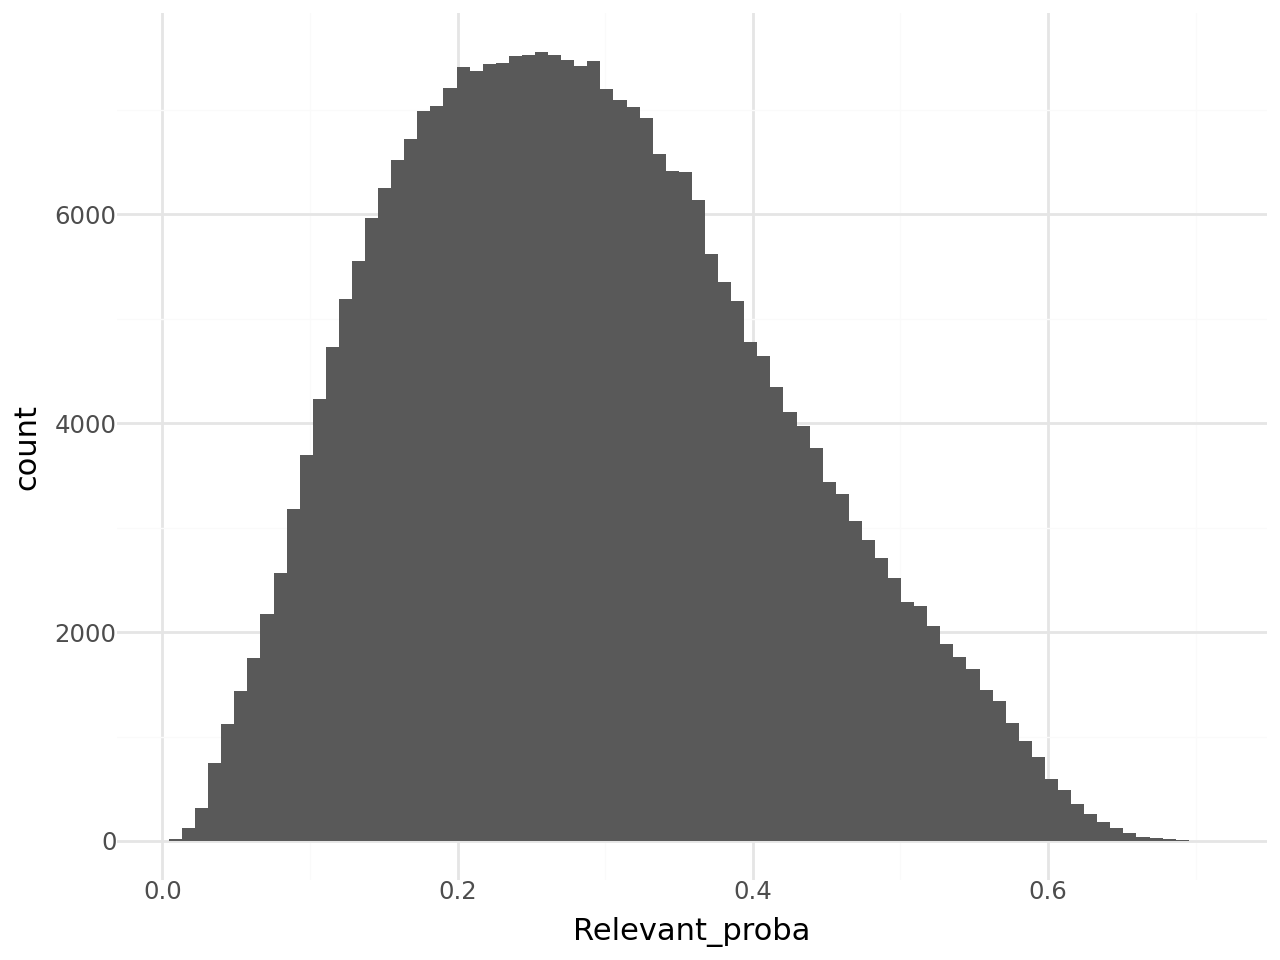

In [862]:
# Add relevance values to the X dataframe
dfr5 = dfr3.copy()
dfr5['Relevant_proba'] = [y[0] for y in y_pred]

# Plot histogram of relevance probabilities
p = ggplot(dfr5) + \
    aes(x='Relevant_proba') + \
    geom_histogram(bins=80) + \
    theme_minimal()
display(p)


In [863]:
# Function to plot graph showing pct of relevant topics against probability threshold
def plot_probs(start, end, num_points, xint):
    dfthresh = {
        'thresh': [],
        'ct_rel': [],
        'ct_irrel': [],
        'pct_rel': []
    }
    for rel_pct in np.linspace(start, end, num_points):
        ct_rel = dfr5[dfr5['Relevant_proba']>=rel_pct].shape[0]
        ct_irrel = dfr5.shape[0] - ct_rel
        pct_rel = ct_rel / (ct_rel + ct_irrel)
        dfthresh['thresh'].append(rel_pct)
        dfthresh['ct_rel'].append(ct_rel)
        dfthresh['ct_irrel'].append(ct_irrel)
        dfthresh['pct_rel'].append(pct_rel)
        #print(rel_pct, ct_rel, ct_irrel, pct_rel)
    dfthresh = pd.DataFrame(dfthresh)
    p = ggplot(dfthresh) + \
        aes(x='thresh', y='pct_rel') + \
        geom_point() + \
        geom_vline(xintercept=xint, color='#880000', linetype='dashed', size=1) + \
        xlab('Probability threshold') + \
        ylab('Percent relevant observations') + \
        theme_minimal()
    display(p)


tpr: 0.8, fpr: 0.263, thresh: 0.679, relevant: 25, irrelevant: 298907
tpr: 0.81, fpr: 0.268, thresh: 0.669, relevant: 54, irrelevant: 298878
tpr: 0.82, fpr: 0.268, thresh: 0.668, relevant: 56, irrelevant: 298876
tpr: 0.83, fpr: 0.278, thresh: 0.658, relevant: 109, irrelevant: 298823
tpr: 0.84, fpr: 0.278, thresh: 0.657, relevant: 114, irrelevant: 298818
tpr: 0.85, fpr: 0.283, thresh: 0.65, relevant: 180, irrelevant: 298752
tpr: 0.86, fpr: 0.298, thresh: 0.639, relevant: 341, irrelevant: 298591
tpr: 0.87, fpr: 0.303, thresh: 0.639, relevant: 356, irrelevant: 298576
tpr: 0.88, fpr: 0.303, thresh: 0.637, relevant: 394, irrelevant: 298538
tpr: 0.89, fpr: 0.308, thresh: 0.632, relevant: 503, irrelevant: 298429
tpr: 0.9, fpr: 0.313, thresh: 0.615, relevant: 1098, irrelevant: 297834
tpr: 0.91, fpr: 0.328, thresh: 0.614, relevant: 1183, irrelevant: 297749
tpr: 0.92, fpr: 0.343, thresh: 0.58, relevant: 3893, irrelevant: 295039
tpr: 0.93, fpr: 0.343, thresh: 0.548, relevant: 8760, irrelevant: 29

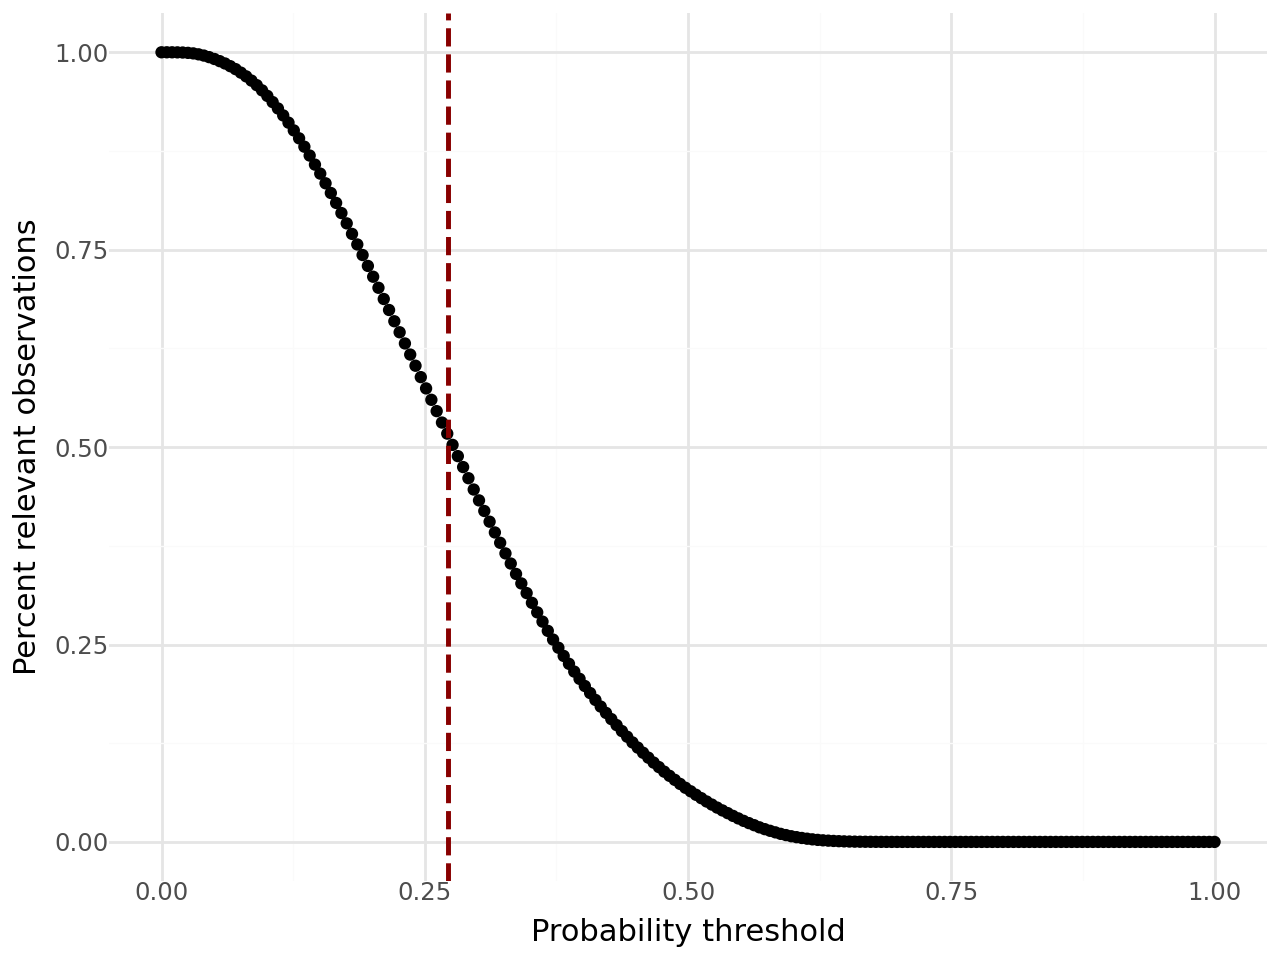

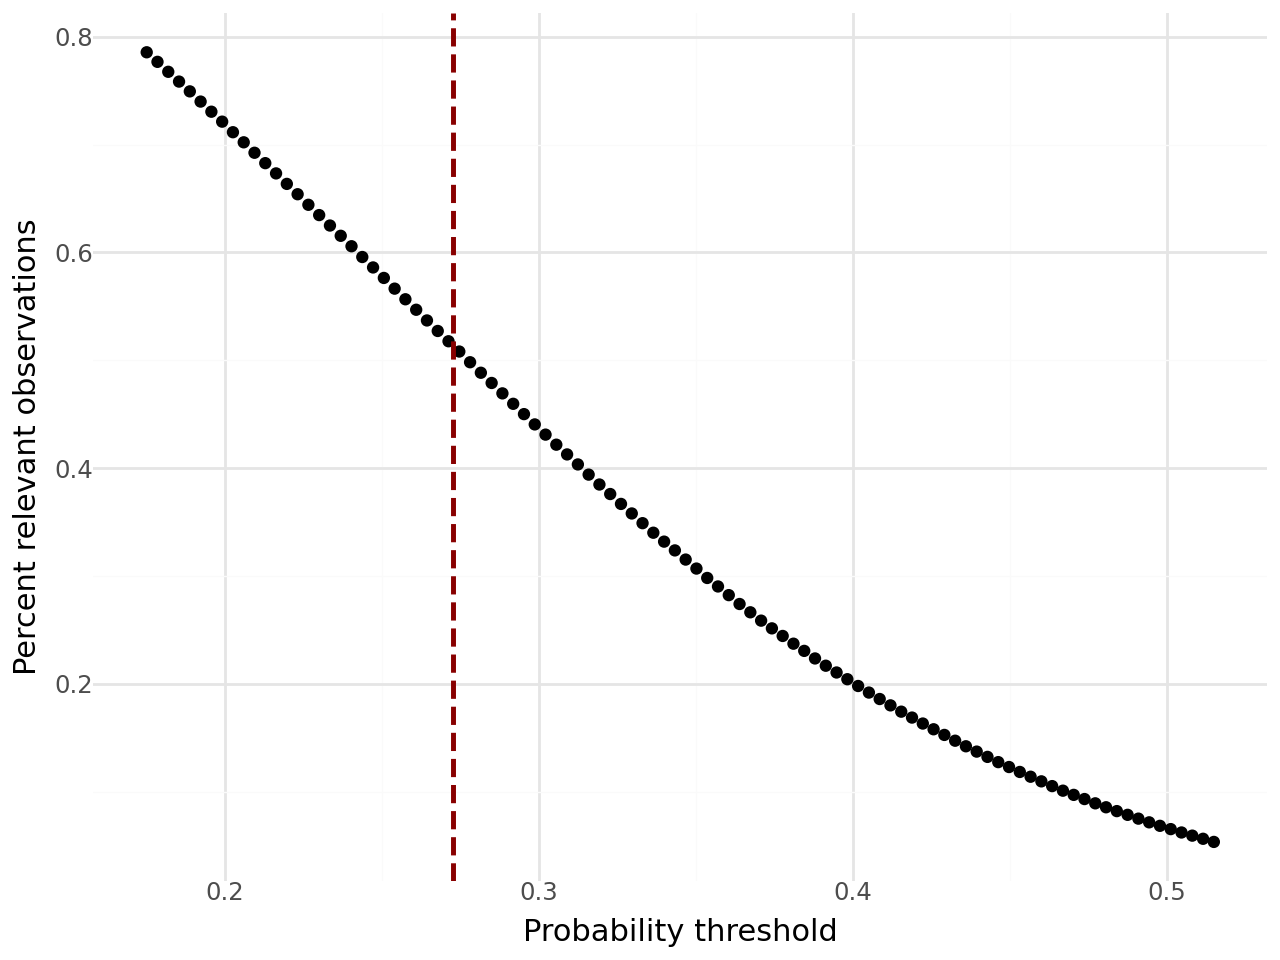

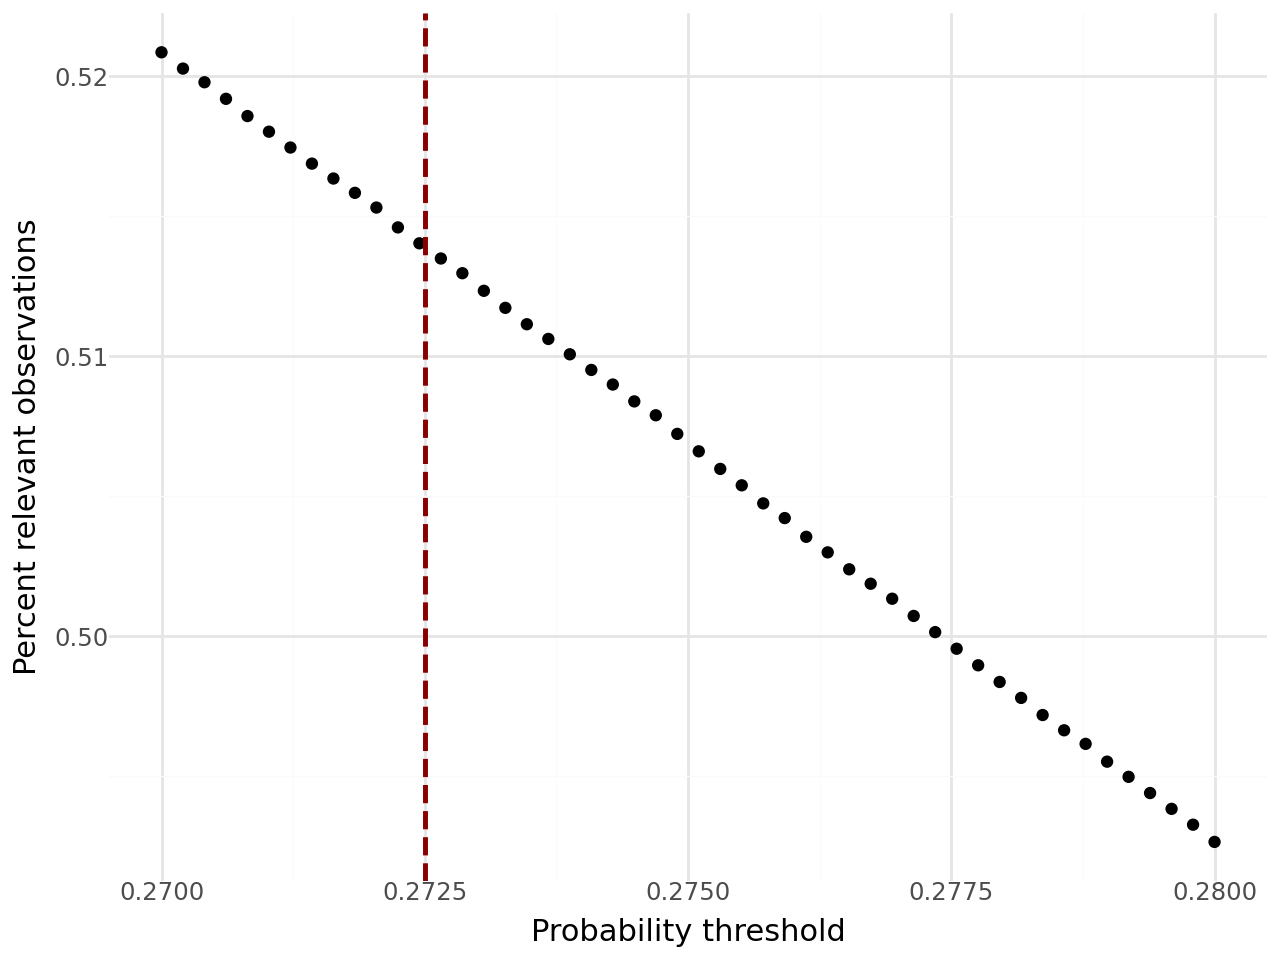

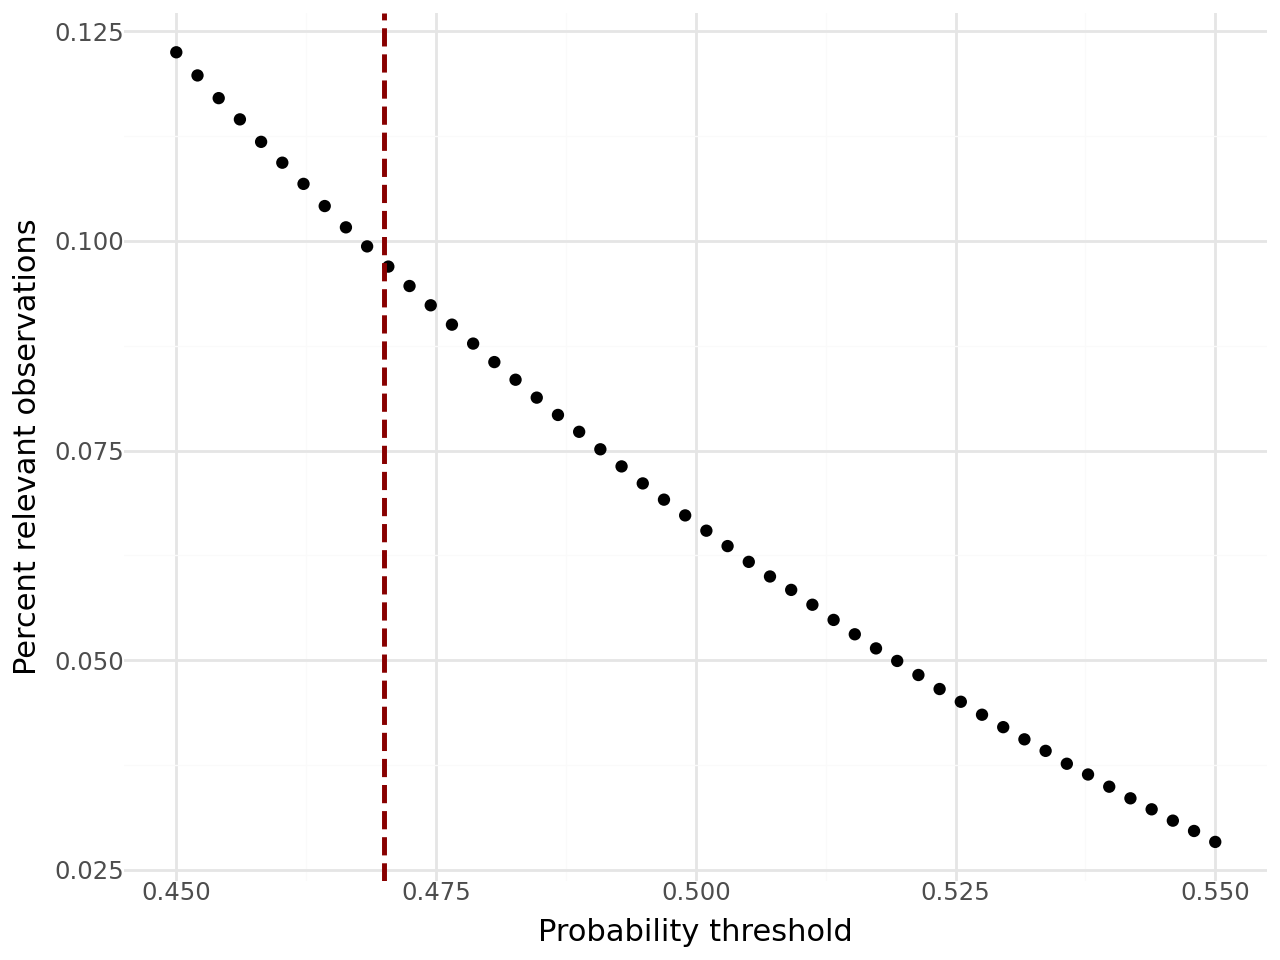

In [864]:
# Explore thresholds - iterate over range of TPRs to see the counts of relevant vs irrelevant for various TPRs
for rel_pct in range(80, 100):
    tmp_thresh_index = [ii for ii, rt in enumerate(tpr) if rt > (rel_pct/100)][0]  # the index of the probability threshold
    tmp_thresh = thresholds[tmp_thresh_index]
    ct_rel = dfr5[dfr5['Relevant_proba']>=tmp_thresh].shape[0]
    ct_irrel = dfr5.shape[0] - ct_rel
    print(f"tpr: {np.round(rel_pct/100, 3)}, fpr: {np.round(fpr[tmp_thresh_index], 3)}, thresh: {np.round(tmp_thresh, 3)}, relevant: {ct_rel}, irrelevant: {ct_irrel}")
print()

# Different approach -- the training set had these counts for relevance: {1.0: 689, 0.0: 658} (51.2% relevant)
# choose a probability threshold on the ROC curve such that the proportions are roughly equal to the training data
for i, rel_pct in enumerate(thresholds):
    ct_rel = dfr5[dfr5['Relevant_proba']>=rel_pct].shape[0]
    if (ct_rel / dfr5.shape[0]) >= 0.512:
        ct_irrel = dfr5.shape[0] - ct_rel
        print(f"tpr: {np.round(tpr[i], 3)}, fpr: {np.round(fpr[i], 3)}, thresh: {np.round(rel_pct, 3)}, relevant: {ct_rel}, irrelevant: {ct_irrel}")
        break
print()

# Fine-tune threhold choice
plot_probs(0, 1, 200, 0.2725)
plot_probs(0.175, 0.515, 100, 0.2725)
plot_probs(0.27, 0.28, 50, 0.2725)
plot_probs(0.45, 0.55, 50, 0.47)
print()


In [869]:
# Choose threshold
proba_thresh = 0.2725
#proba_thresh = 0.47
#proba_thres = 0.15
print(f'choose probability threshold of {proba_thresh}')

# Set relevance based on threshold chosen from ROC
dfr5['Relevant'] = 'no'
dfr5.loc[dfr5['Relevant_proba'] >= proba_thresh, 'Relevant'] = 'yes'

# Set preprocessing indicator
dfr5['Preproc'] = pd.NA
dfr5.loc[dfr5['Keyphrases'] == True, 'Preproc'] = 'Keyphrases'
dfr5.loc[((dfr5['Synonyms'] == True) | (dfr5['Hypernyms'] == True)) & (dfr5['Keyphrases'] == False), 'Preproc'] = 'Syn/Hyper'
dfr5.loc[(dfr5['Synonyms'] == False) & (dfr5['Hypernyms'] == False) & (dfr5['Keyphrases'] == False), 'Preproc'] = 'None'

# Display
display(dfr5.head())
print(list(dfr5.columns))
print(Counter(dfr5['Relevant']))

# Check for NAs
print('NAs:')
print(dfr5.isna().sum())
print()


choose probability threshold of 0.2725


,Dataset,Representation,Source,Cosine_similarity,Model,Num_topics,Spell_checked,Text_speak,Synonyms,Hypernyms,Model_family,Keyphrases,Model_run,Relevant_proba,Relevant,Preproc
0,cc,Topic_words,MTurk,0.192913,lsi,8,True,True,False,False,bow,False,lsi,0.144264,no,None
1,cc,Topic_words,MTurk,0.075951,lsi,8,True,True,False,False,bow,False,lsi,0.199833,no,None
2,cc,Topic_words,MTurk,0.169443,lsi,8,True,True,False,False,bow,False,lsi,0.154274,no,None
3,cc,Topic_words,MTurk,0.189649,lsi,8,True,True,False,False,bow,False,lsi,0.145623,no,None
4,cc,Topic_words,MTurk,0.221626,lsi,8,True,True,False,False,bow,False,lsi,0.132758,no,None


['Dataset', 'Representation', 'Source', 'Cosine_similarity', 'Model', 'Num_topics', 'Spell_checked', 'Text_speak', 'Synonyms', 'Hypernyms', 'Model_family', 'Keyphrases', 'Model_run', 'Relevant_proba', 'Relevant', 'Preproc']
Counter({'yes': 153614, 'no': 145318})
NAs:
Dataset              0
Representation       0
Source               0
Cosine_similarity    0
Model                0
Num_topics           0
Spell_checked        0
Text_speak           0
Synonyms             0
Hypernyms            0
Model_family         0
Keyphrases           0
Model_run            0
Relevant_proba       0
Relevant             0
Preproc              0
dtype: int64



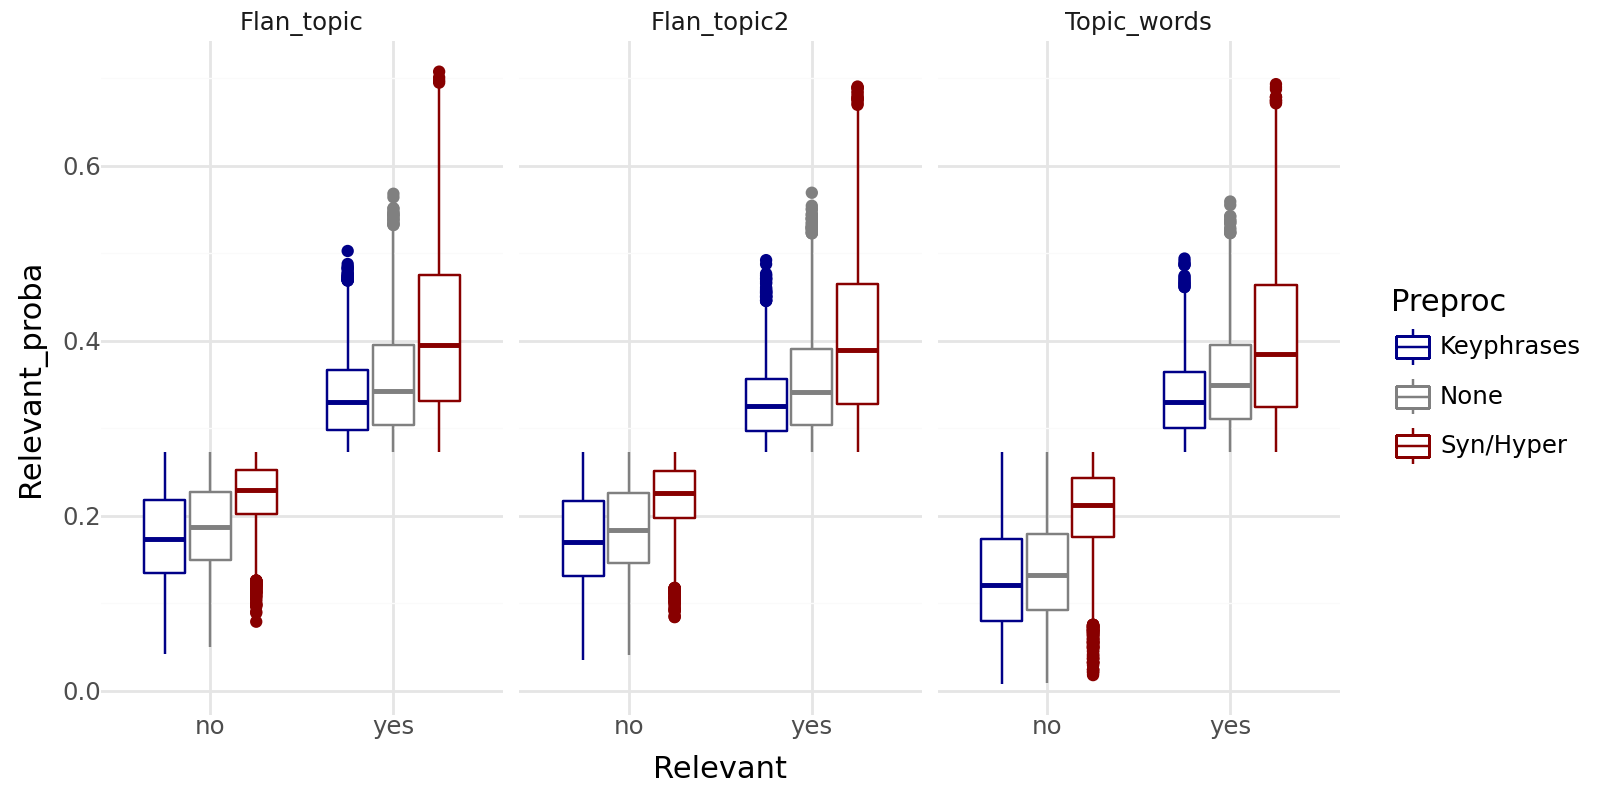

In [886]:
# Plot relevance by topic representation
p = ggplot(dfr5) + \
    aes(y='Relevant_proba', x='Relevant', color='Preproc') + \
    geom_boxplot() + \
    scale_colour_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    facet_wrap('Representation', ncol=3) + \
    theme_minimal() + \
    theme(figure_size=(8, 4))
display(p)


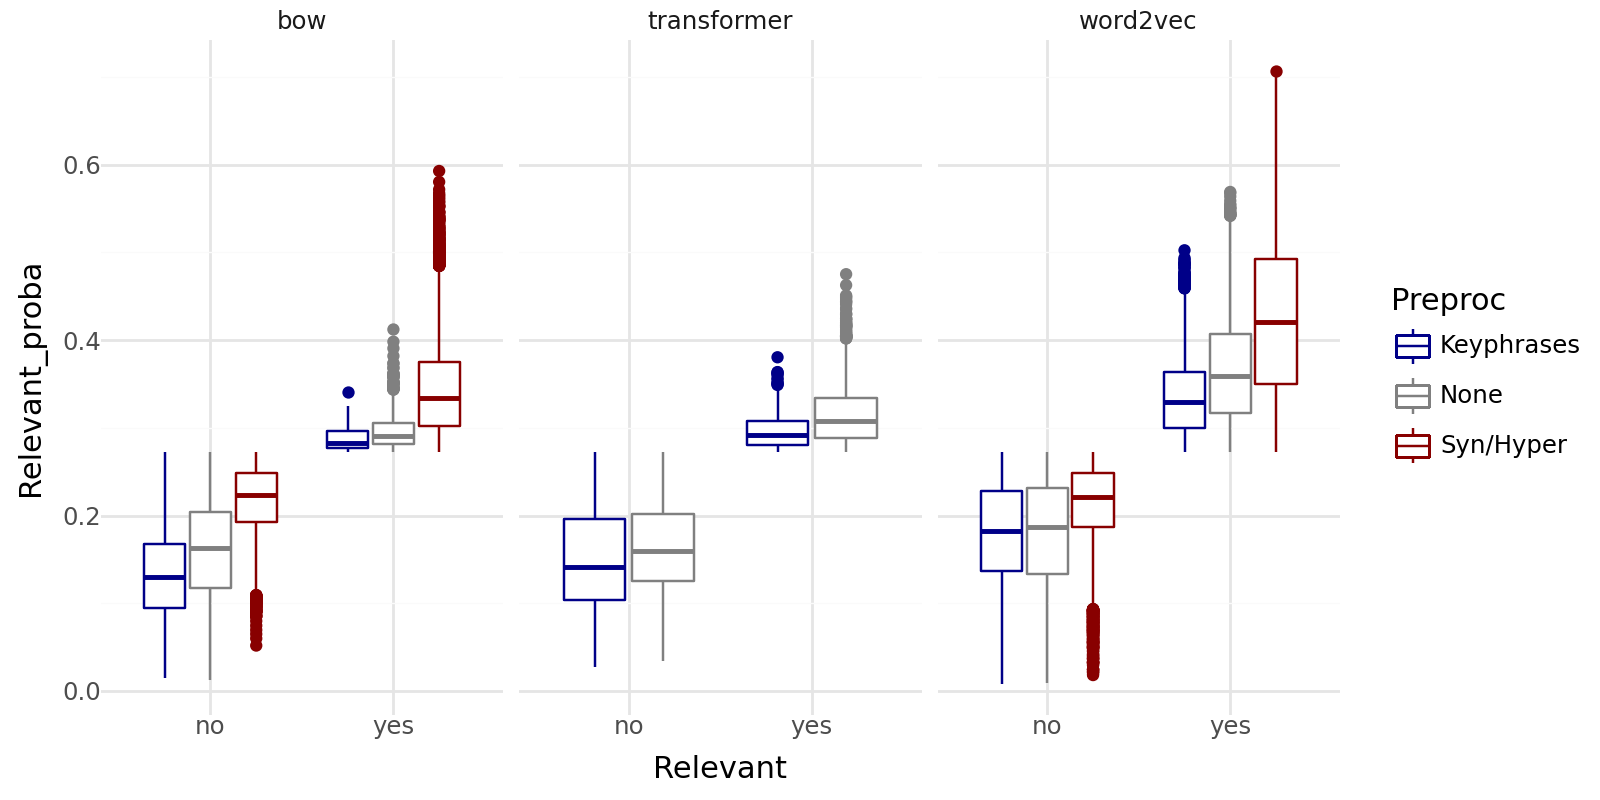

In [887]:
# Plot relevance by model family
p = ggplot(dfr5) + \
    aes(y='Relevant_proba', x='Relevant', color='Preproc') + \
    geom_boxplot() + \
    scale_colour_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    facet_wrap('Model_family', ncol=3) + \
    theme_minimal() + \
    theme(figure_size=(8, 4))
display(p)


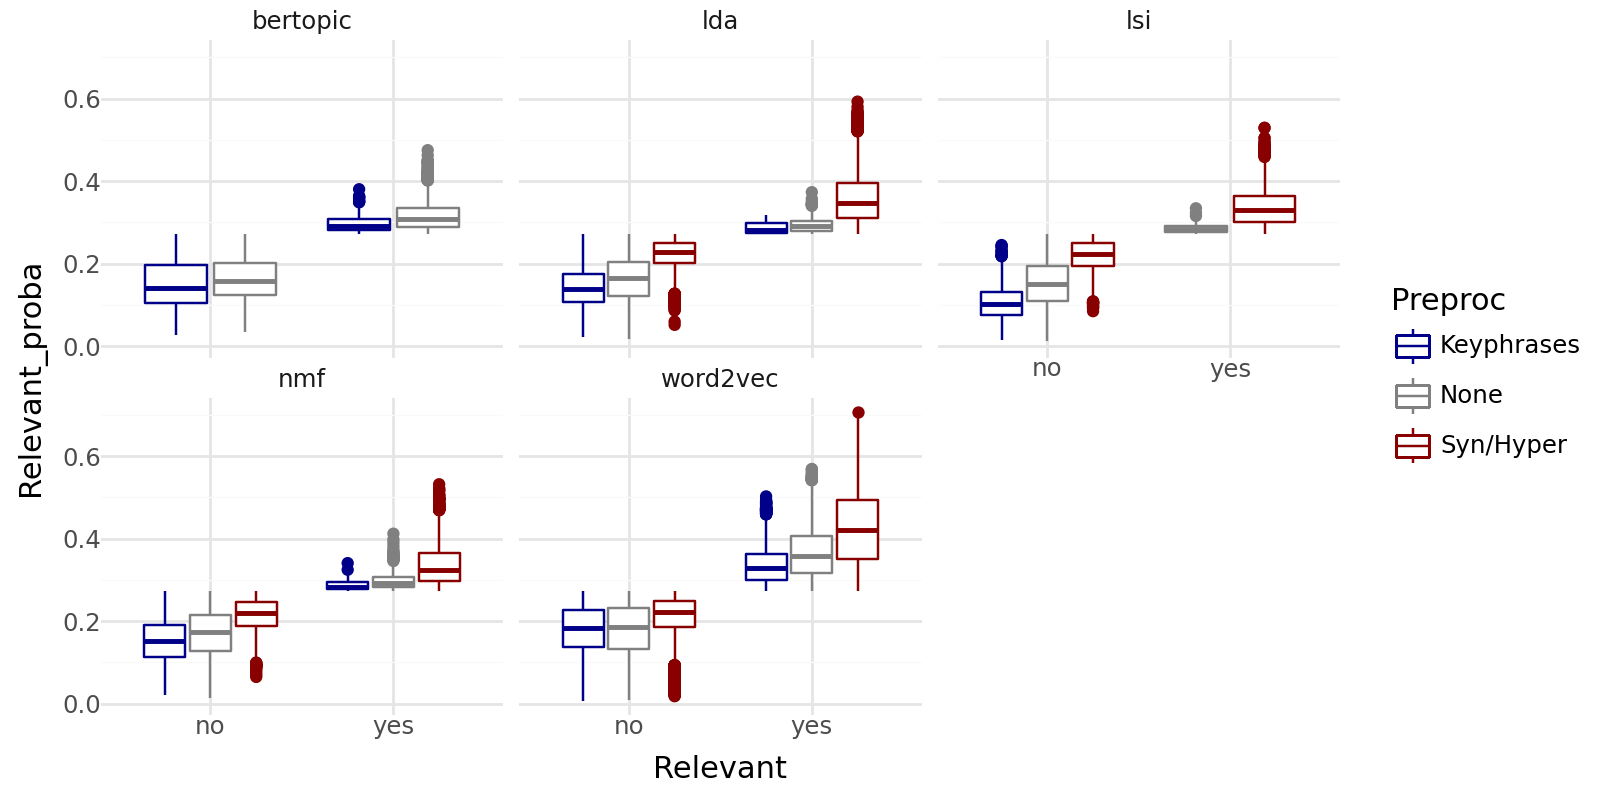

In [892]:
# Plot relevance by model
p = ggplot(dfr5) + \
    aes(y='Relevant_proba', x='Relevant', color='Preproc') + \
    geom_boxplot() + \
    scale_colour_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    facet_wrap('Model', ncol=3) + \
    theme_minimal() + \
    theme(figure_size=(8, 4))
display(p)


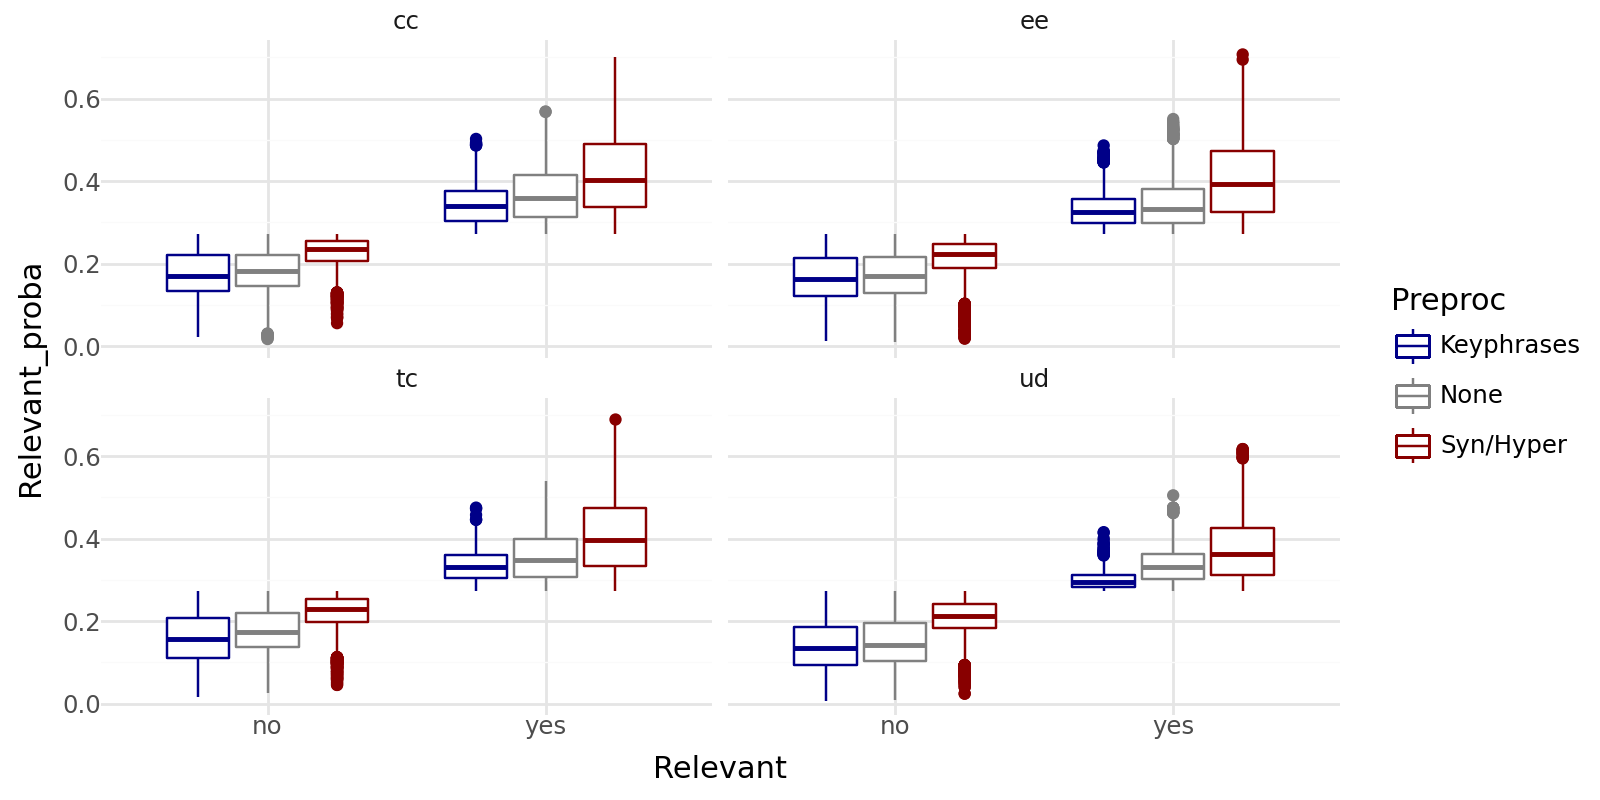

In [893]:
# Plot relevance by dataset
p = ggplot(dfr5) + \
    aes(y='Relevant_proba', x='Relevant', color='Preproc') + \
    geom_boxplot() + \
    scale_colour_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    facet_wrap('Dataset', ncol=2) + \
    theme_minimal() + \
    theme(figure_size=(8, 4))
display(p)


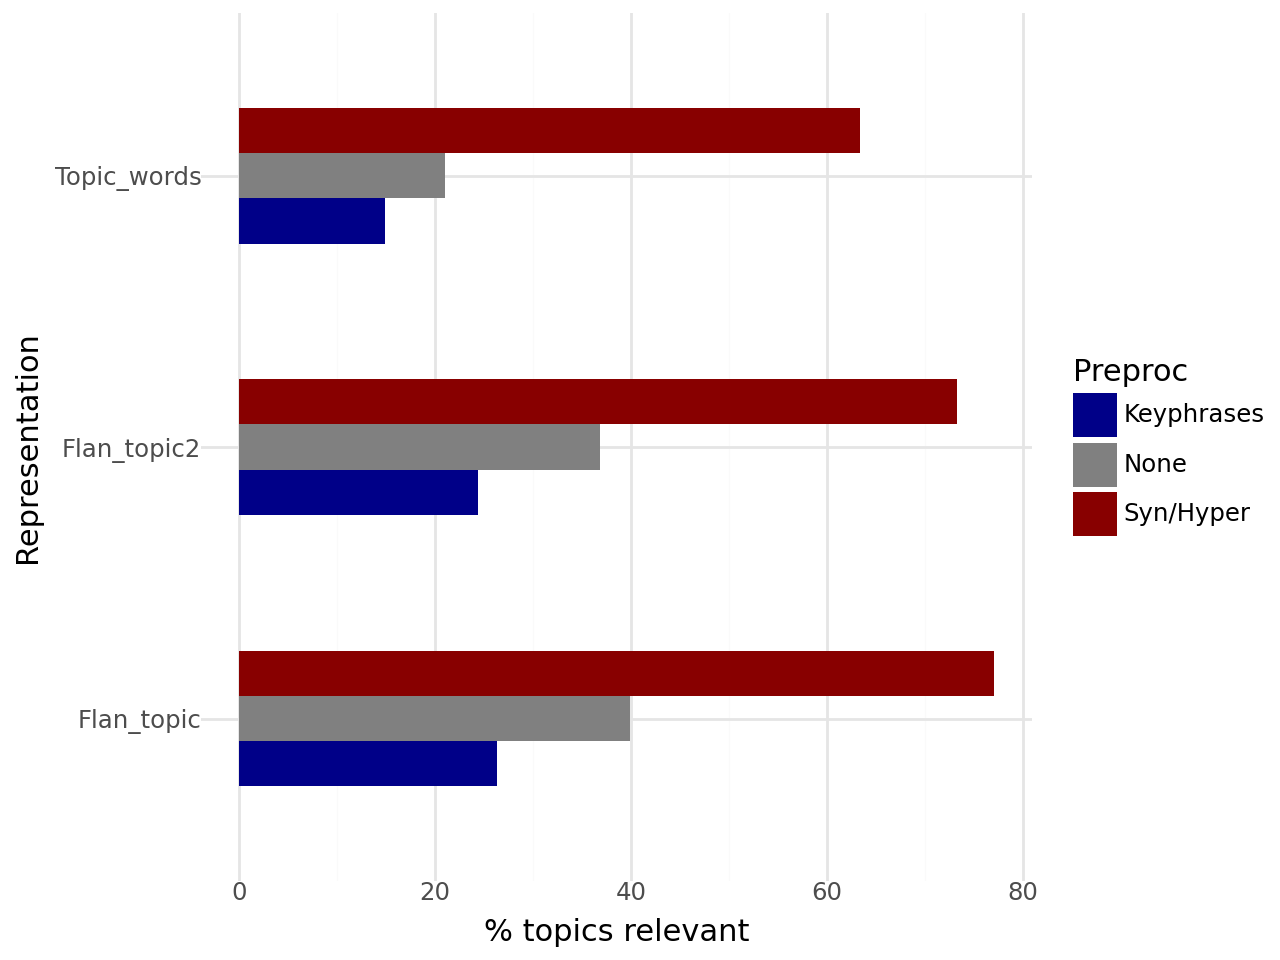

In [857]:
# Relevance by topic representation
dfg1 = dfr5[dfr5['Relevant'] == 'yes'].groupby(['Representation', 'Preproc']).agg({'Relevant': 'count'}).reset_index()
dfg2 = dfr5[dfr5['Relevant'] == 'no'].groupby(['Representation', 'Preproc']).agg({'Relevant': 'count'}).reset_index().rename(columns={'Relevant': 'Irrelevant'})
dfg = dfg1.merge(dfg2, on=['Representation', 'Preproc'], how='outer')
dfg['Relevant_pct'] = 100 * dfg['Relevant'] / (dfg['Relevant'] + dfg['Irrelevant'])
#display(dfg)
p = ggplot(dfg) + \
    aes(x='Representation', y='Relevant_pct', fill='Preproc') + \
    geom_bar(stat='identity', width=0.5, position='dodge') + \
    scale_fill_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    coord_flip() + \
    ylab('% topics relevant') + \
    theme_minimal()
display(p)


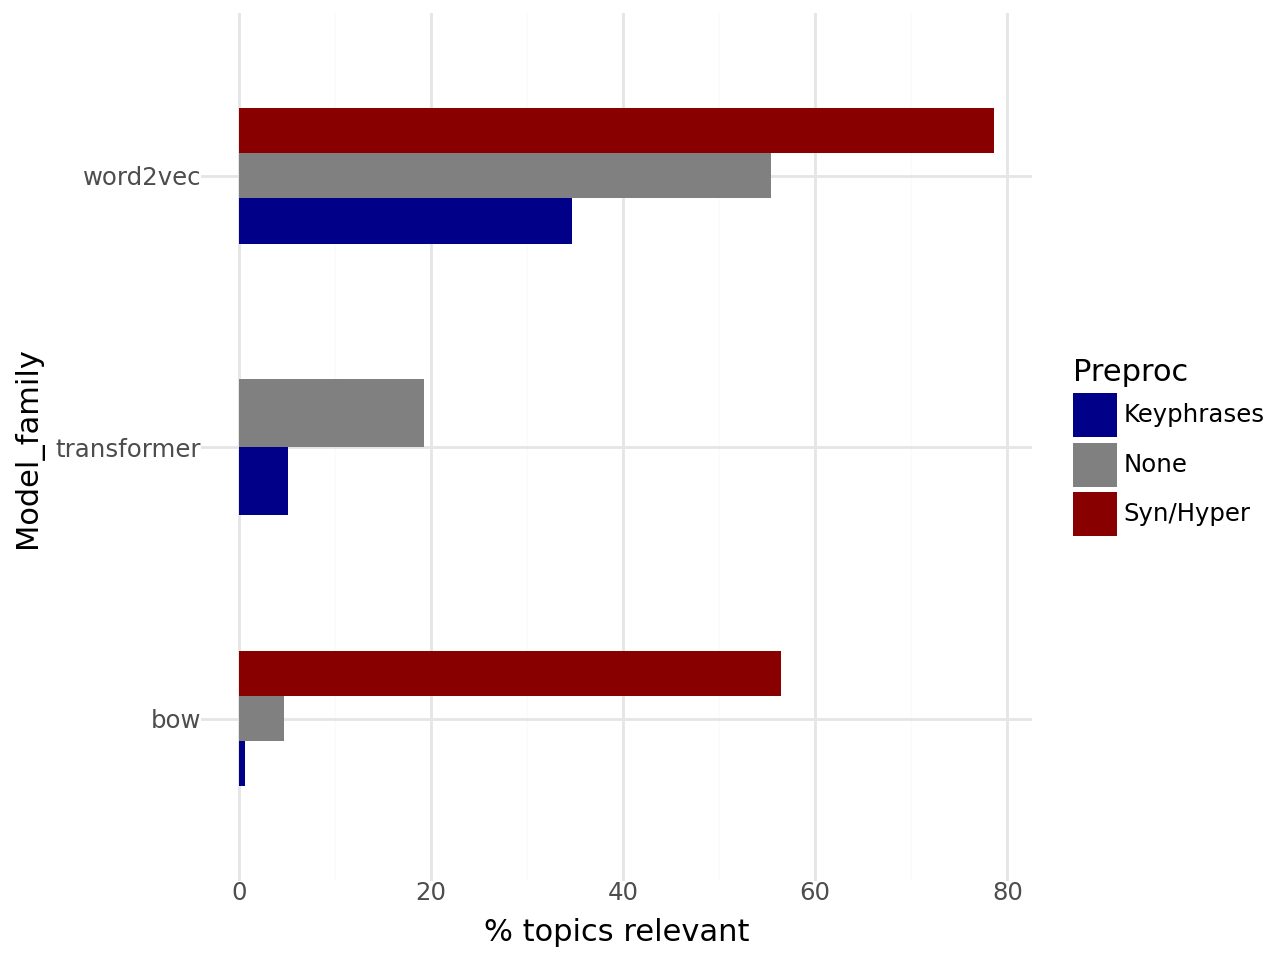

In [858]:
# Relevance by model family
dfg1 = dfr5[dfr5['Relevant'] == 'yes'].groupby(['Model_family', 'Preproc']).agg({'Relevant': 'count'}).reset_index()
dfg2 = dfr5[dfr5['Relevant'] == 'no'].groupby(['Model_family', 'Preproc']).agg({'Relevant': 'count'}).reset_index().rename(columns={'Relevant': 'Irrelevant'})
dfg = dfg1.merge(dfg2, on=['Model_family', 'Preproc'], how='outer')
dfg['Relevant_pct'] = 100 * dfg['Relevant'] / (dfg['Relevant'] + dfg['Irrelevant'])
#display(dfg)
p = ggplot(dfg) + \
    aes(x='Model_family', y='Relevant_pct', fill='Preproc') + \
    geom_bar(stat='identity', width=0.5, position='dodge') + \
    scale_fill_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    coord_flip() + \
    ylab('% topics relevant') + \
    theme_minimal()
display(p)


c:\tmp\p312\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_bar : Removed 2 rows containing missing values.


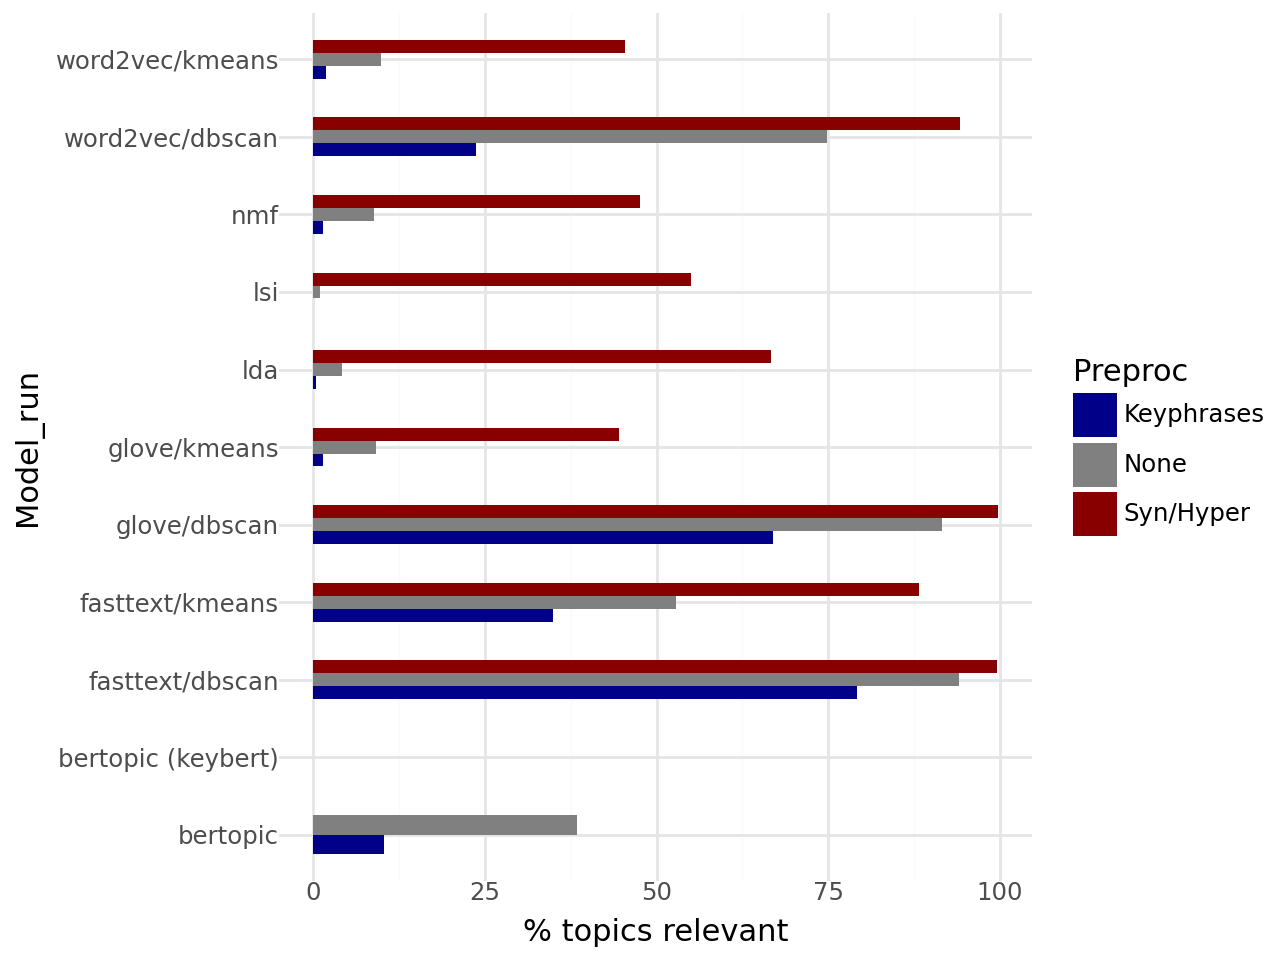

In [859]:
# Relevance by model run
dfg1 = dfr5[dfr5['Relevant'] == 'yes'].groupby(['Model_run', 'Preproc']).agg({'Relevant': 'count'}).reset_index()
dfg2 = dfr5[dfr5['Relevant'] == 'no'].groupby(['Model_run', 'Preproc']).agg({'Relevant': 'count'}).reset_index().rename(columns={'Relevant': 'Irrelevant'})
dfg = dfg1.merge(dfg2, on=['Model_run', 'Preproc'], how='outer')
dfg['Relevant_pct'] = 100 * dfg['Relevant'] / (dfg['Relevant'] + dfg['Irrelevant'])
p = ggplot(dfg) + \
    aes(x='Model_run', y='Relevant_pct', fill='Preproc') + \
    geom_bar(stat='identity', width=0.5, position='dodge') + \
    scale_fill_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    coord_flip() + \
    ylab('% topics relevant') + \
    theme_minimal()
display(p)


In [841]:
"""
# Relevance by num topics - this needs some work
p = ggplot(dfr5) + \
    aes(x='Num_topics', y='Relevant', color='Preproc') + \
    geom_point() + \
    geom_jitter(width=0.3) + \
    scale_colour_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    ylab('% topics relevant') + \
    theme_minimal()
display(p)
"""

"\n# Relevance by num topics - this needs some work\np = ggplot(dfr5) +     aes(x='Num_topics', y='Relevant', color='Preproc') +     geom_point() +     geom_jitter(width=0.3) +     scale_colour_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) +     ylab('% topics relevant') +     theme_minimal()\ndisplay(p)\n"

### Semantic quality evaluation

This section evaluates the semantic quality of data returned from the Mechanical Turk survey as well as the data I hand labeled.


In [614]:
#########################################
# Semantic quality
#########################################

# Quick look
print(np.unique(dfrel['Set_id']))
display(dfrel.head())

# Merge the modeling result set with the relevance df
dfr.rename(columns={'index': 'Row_id'}, inplace=True)
dfm = dfrel.merge(dfr, on='Row_id', how='left')

# Rename Set_id
dfm.rename(columns={'Set_id': 'Representation'}, inplace=True)

# Fill in NAs for human keywords
dfm.loc[dfm['Representation'].str.startswith('Human'), 'Preproc'] = 'None'
dfm.loc[dfm['Representation'].str.startswith('Human'), 'Model_family'] = 'Human'
dfm.loc[dfm['Representation'].str.startswith('Human'), 'Model_run'] = dfm['Representation']

# Display
print(dfm.shape)
display(dfm.head(1))

# Counts
print(dfrel.shape)
print(dfr.shape)
print(dfm.shape)


['Flan_topic' 'Flan_topic2' 'Human_friendly_topic' 'Human_keywords'
 'Topic_words']


,Dataset,Doc_num,Row_id,Set_id,Quality,Source,Doc_id,Relevant,Topic_words,Cosine_similarity,Conv
0,ee,70.0,72,Topic_words,3,Author,287.0,1.0,"HOU,forward,iSubject,ECT,John,Enron,Phillip,te...",0.251097,"Tim,\nmike grigsby is having problems with acc..."
1,ee,70.0,72,Flan_topic,1,Author,287.0,0.0,iSubject,0.016811,"Tim,\nmike grigsby is having problems with acc..."
2,ee,70.0,72,Flan_topic2,1,Author,287.0,0.0,Electrical healing,0.062604,"Tim,\nmike grigsby is having problems with acc..."
3,ee,235.0,242,Topic_words,1,Author,1881.0,0.0,"pass,realise,realize,sustain,catch,bear,genera...",0.055758,"Phillip,\nBarry had said that you were asking ..."
4,ee,235.0,242,Flan_topic,1,Author,1881.0,0.0,Science/Tech,-0.000527,"Phillip,\nBarry had said that you were asking ..."


(1347, 39)


,Dataset_x,Doc_num,Row_id,Representation,Quality,Source,Doc_id,Relevant,Topic_words_x,Cosine_similarity_x,...,Flan_topic,Cosine_similarity_y,Model_family,Topic_words2,Flan_topic2,Keyphrases,Cosine_similarity_flan,Cosine_similarity_flan2,Preproc,Model_run
0,ee,70.0,72,Topic_words,3,Author,287.0,1.0,"HOU,forward,iSubject,ECT,John,Enron,Phillip,te...",0.251097,...,"[[0, ""iSubject""], [1, ""iSubject: iSubject: iSu...","{""10"": [[0, 0.19630371034145355], [141, 0.1981...",bow,"[[0, [[""receptor"", 0], [""galvanism"", 0], [""rac...","[[0, ""Electrical healing""], [1, ""Electricity h...",False,"{""10"": [[0, 0.09792318195104599], [141, 0.1347...","{""10"": [[0, 0.16237114369869232], [141, 0.0923...",None,lsi


(1347, 11)
(400, 29)
(1347, 39)


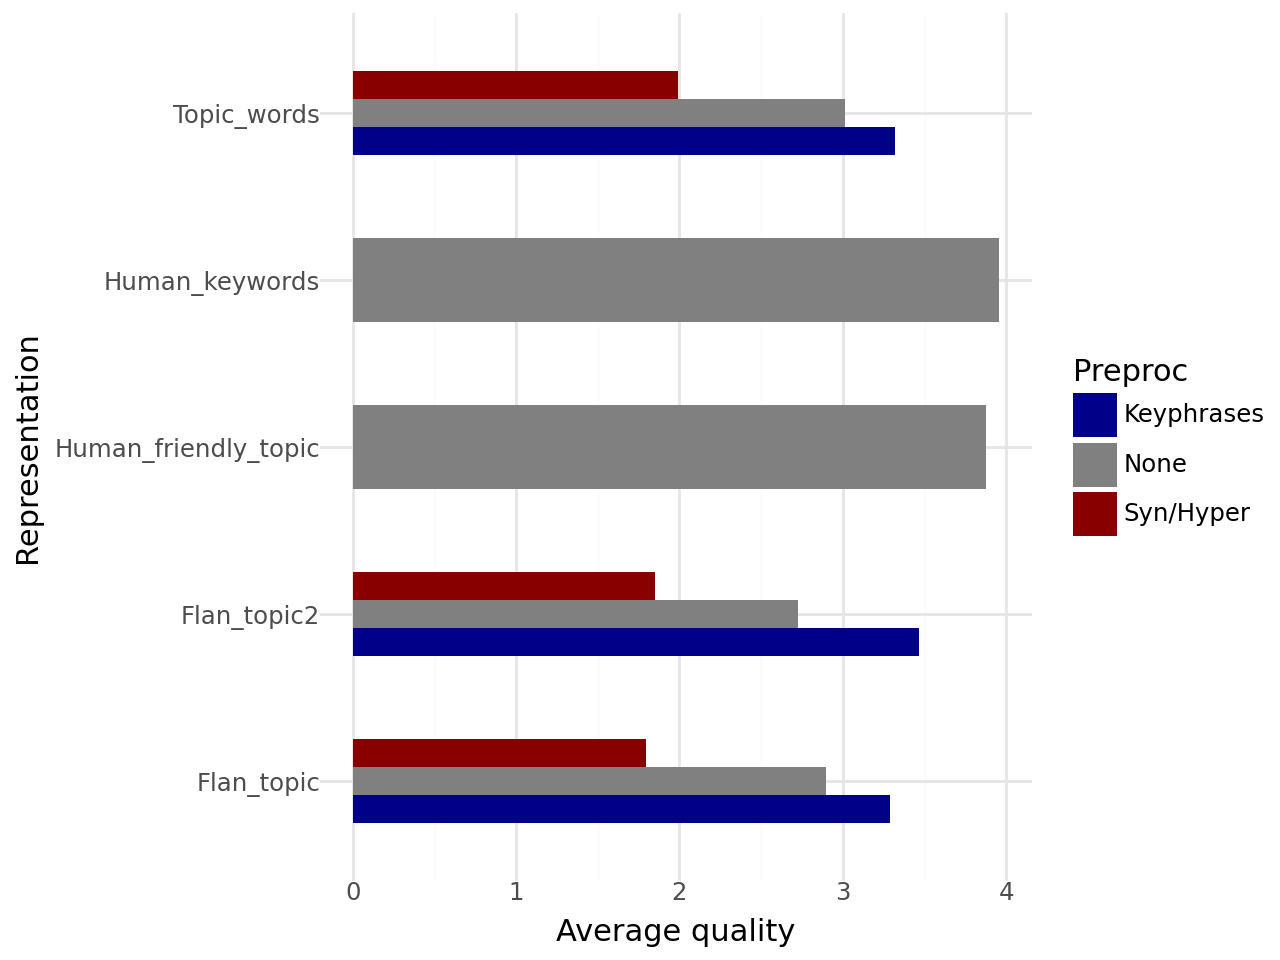

Flan_topic
<class 'list'> 3 F_onewayResult(statistic=45.67731846006577, pvalue=1.0463276185233645e-18)
Flan_topic2
<class 'list'> 3 F_onewayResult(statistic=46.65383375806384, pvalue=4.560618011896462e-19)
Topic_words
<class 'list'> 3 F_onewayResult(statistic=37.62331493958414, pvalue=8.705815321084807e-16)


,Representation,Test_statistic,p-value
0,Flan_topic,45.677318,1.046328e-18
1,Flan_topic2,46.653834,4.560618e-19
2,Topic_words,37.623315,8.705815e-16


In [738]:
# Avg quality by set
dfg = dfm.groupby(['Representation', 'Preproc']).agg({'Quality': 'mean'}).reset_index()
p = ggplot(dfg) + \
    aes(x='Representation', y='Quality', fill='Preproc') + \
    geom_bar(stat='identity', width=0.5, position='dodge') + \
    scale_fill_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    coord_flip() + \
    ylab('Average quality') + \
    theme_minimal()
display(p)

# ANOVA
d = {'Representation': [], 'Test_statistic': [], 'p-value': []}
for r in list(np.unique(dfm.loc[~dfm['Representation'].str.startswith('Human'), 'Representation'])):
    print(r)
    q = []
    for p in list(np.unique(dfm['Preproc'])):
        q.append(list(dfm.loc[(~dfm['Representation'].str.startswith('Human')) & \
                              (dfm['Representation'] == r) & \
                              (dfm['Preproc'] == p), 'Quality'].values))
    run_anova('Representation', q)
dfo = pd.DataFrame(d)
display(dfo)


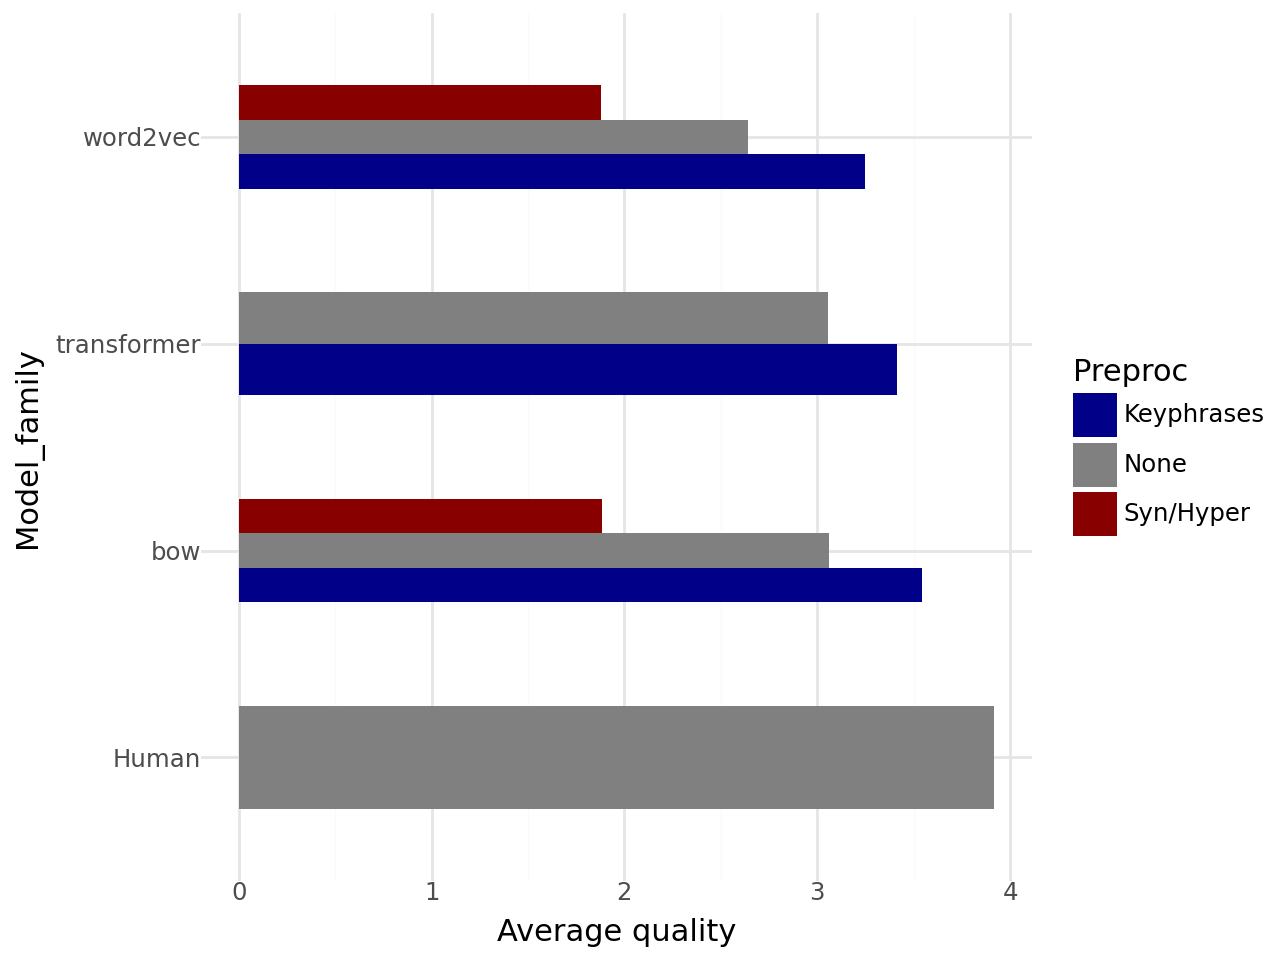

bow
<class 'list'> 3 F_onewayResult(statistic=46.69261440733276, pvalue=1.3912629631284645e-18)
transformer
<class 'list'> 3 F_onewayResult(statistic=2.840189088218974, pvalue=0.09324405039819648)
word2vec
<class 'list'> 3 F_onewayResult(statistic=58.97402836967564, pvalue=1.881217595483365e-24)


,Model_family,Test_statistic,p-value
0,bow,46.692614,1.391263e-18
1,transformer,2.840189,9.324405e-02
2,word2vec,58.974028,1.881218e-24


In [737]:
# Avg quality by model family
dfg = dfm.groupby(['Model_family', 'Preproc']).agg({'Quality': 'mean'}).reset_index()
p = ggplot(dfg) + \
    aes(x='Model_family', y='Quality', fill='Preproc') + \
    geom_bar(stat='identity', width=0.5, position='dodge') + \
    scale_fill_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    coord_flip() + \
    ylab('Average quality') + \
    theme_minimal()
display(p)

# ANOVA
d = {'Model_family': [], 'Test_statistic': [], 'p-value': []}
for r in list(np.unique(dfm.loc[~dfm['Model_family'].str.startswith('Human'), 'Model_family'])):
    print(r)
    q = []
    for p in list(np.unique(dfm['Preproc'])):
        q.append(list(dfm.loc[(~dfm['Model_family'].str.startswith('Human')) & \
                              (dfm['Model_family'] == r) & \
                              (dfm['Preproc'] == p), 'Quality'].values))
    run_anova('Model_family', q)
dfo = pd.DataFrame(d)
display(dfo)


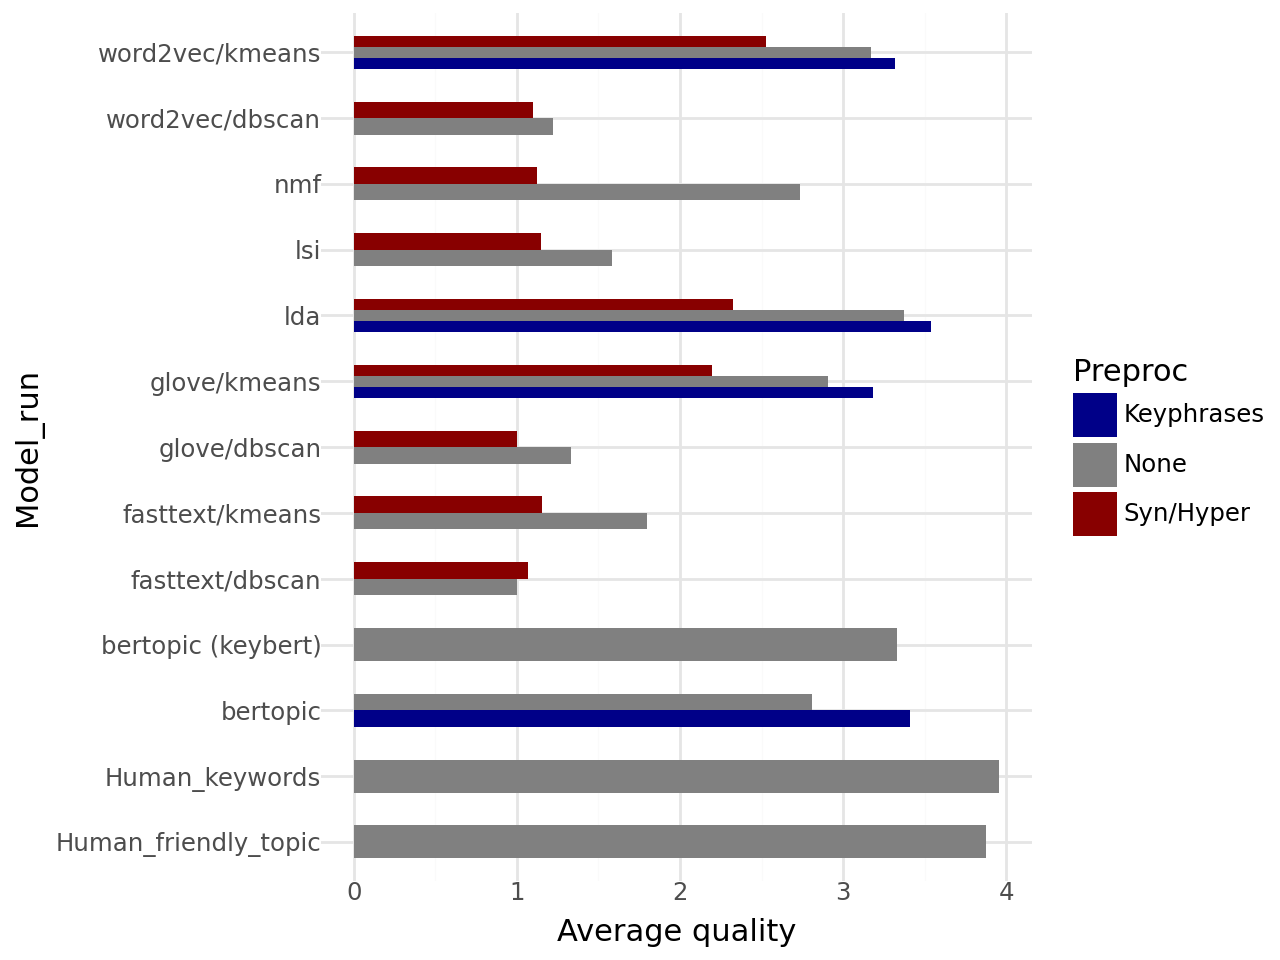

bertopic
<class 'list'> 3 F_onewayResult(statistic=6.990564236786358, pvalue=0.009077359470054903)
bertopic (keybert)
	only one array of values, can't run ANOVA on a single array
fasttext/dbscan
<class 'list'> 3 F_onewayResult(statistic=0.816326530612245, pvalue=0.37166568666316047)
fasttext/kmeans
<class 'list'> 3 F_onewayResult(statistic=7.8979922279792785, pvalue=0.0067373405597874)
glove/dbscan
<class 'list'> 3 F_onewayResult(statistic=14.166666666666664, pvalue=0.00063358546496922)
glove/kmeans
<class 'list'> 3 F_onewayResult(statistic=13.372173473034412, pvalue=2.8125089901784995e-06)
lda
<class 'list'> 3 F_onewayResult(statistic=20.43654075097072, pvalue=6.259944261626859e-09)
lsi
<class 'list'> 3 F_onewayResult(statistic=4.064094276763963, pvalue=0.05110891110260388)
nmf
<class 'list'> 3 F_onewayResult(statistic=43.33691947166595, pvalue=3.853563059149093e-08)
word2vec/dbscan
<class 'list'> 3 F_onewayResult(statistic=0.7879388448471121, pvalue=0.3793419971635106)
word2vec/kmean

,Model_run,Test_statistic,p-value
0,bertopic,6.990564,9.077359e-03
1,fasttext/dbscan,0.816327,3.716657e-01
2,fasttext/kmeans,7.897992,6.737341e-03
3,glove/dbscan,14.166667,6.335855e-04
4,glove/kmeans,13.372173,2.812509e-06
5,lda,20.436541,6.259944e-09
6,lsi,4.064094,5.110891e-02
7,nmf,43.336919,3.853563e-08
8,word2vec/dbscan,0.787939,3.793420e-01
9,word2vec/kmeans,8.651889,2.329921e-04


In [734]:
# Avg quality by model run
dfg = dfm.groupby(['Model_run', 'Preproc']).agg({'Quality': 'mean'}).reset_index()
p = ggplot(dfg) + \
    aes(x='Model_run', y='Quality', fill='Preproc') + \
    geom_bar(stat='identity', width=0.5, position='dodge') + \
    scale_fill_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    coord_flip() + \
    ylab('Average quality') + \
    theme_minimal()
display(p)

# ANOVA
d = {'Model_run': [], 'Test_statistic': [], 'p-value': []}
for r in list(np.unique(dfm.loc[~dfm['Model_run'].str.startswith('Human'), 'Model_run'])):
    print(r)
    q = []
    for p in list(np.unique(dfm['Preproc'])):
        q.append(list(dfm.loc[(~dfm['Model_run'].str.startswith('Human')) & \
                              (dfm['Model_run'] == r) & \
                              (dfm['Preproc'] == p), 'Quality'].values))
    run_anova('Model_run', q)
dfo = pd.DataFrame(d)
display(dfo)


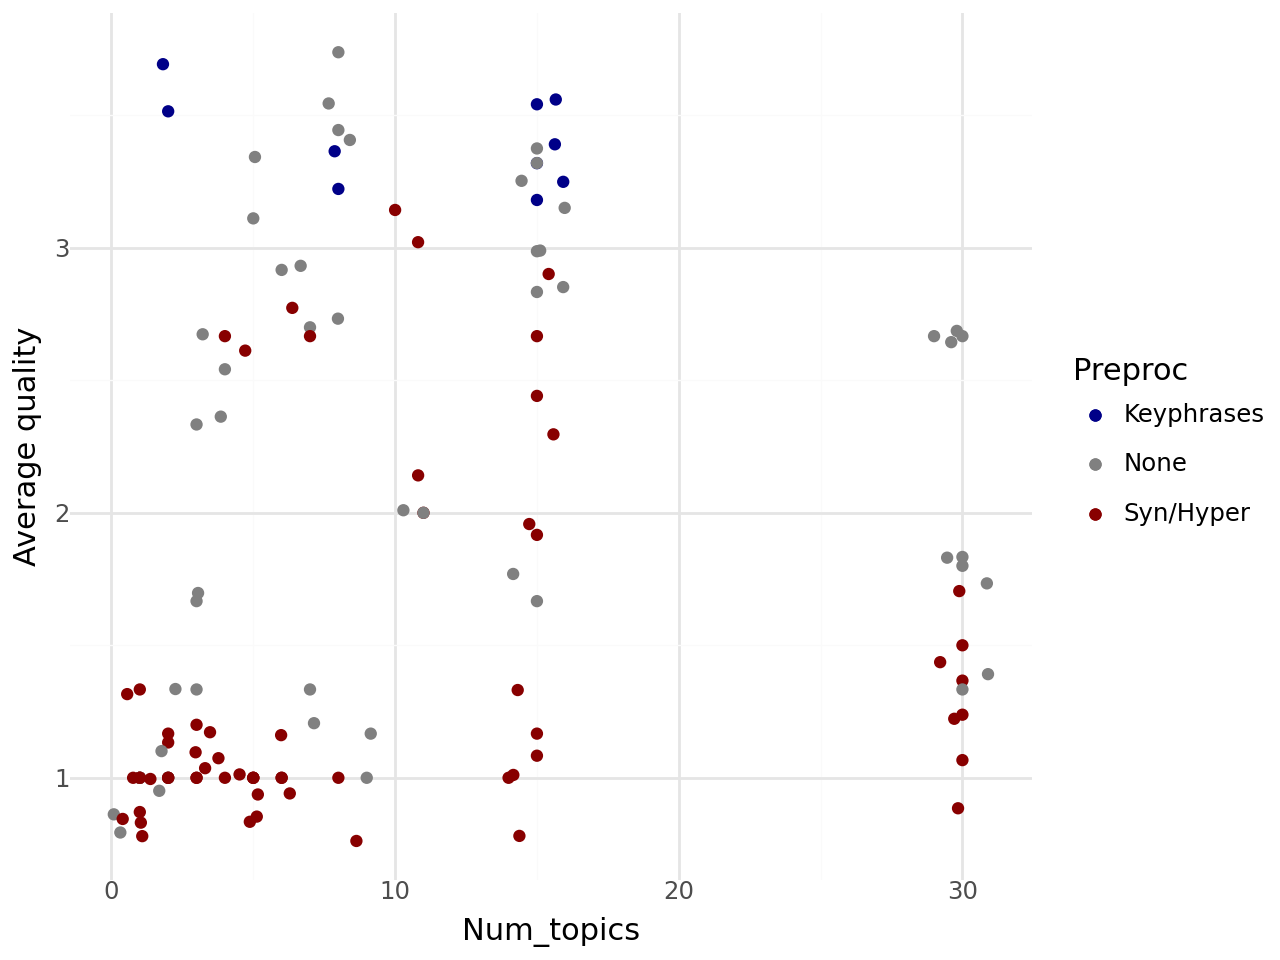

In [742]:
# Avg quality by num topics
dfg = dfm[~dfm['Representation'].str.startswith('Human')].groupby(['Model_run', 'Preproc', 'Num_topics']).agg({'Quality': 'mean'}).reset_index()
p = ggplot(dfg) + \
    aes(x='Num_topics', y='Quality', color='Preproc') + \
    geom_point() + \
    geom_jitter(width=1, height=0.25) + \
    scale_colour_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    ylab('Average quality') + \
    theme_minimal()
display(p)


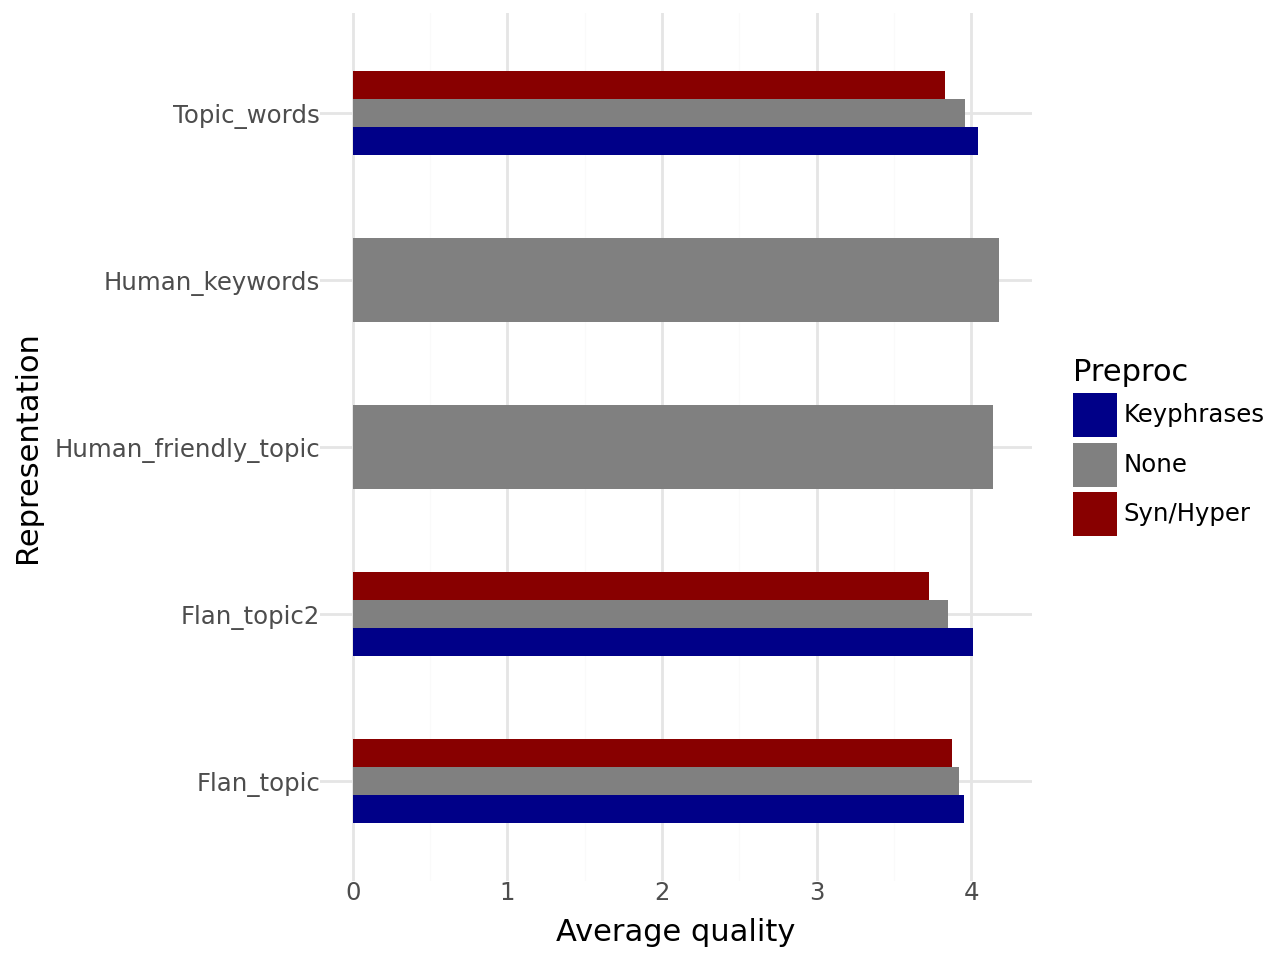

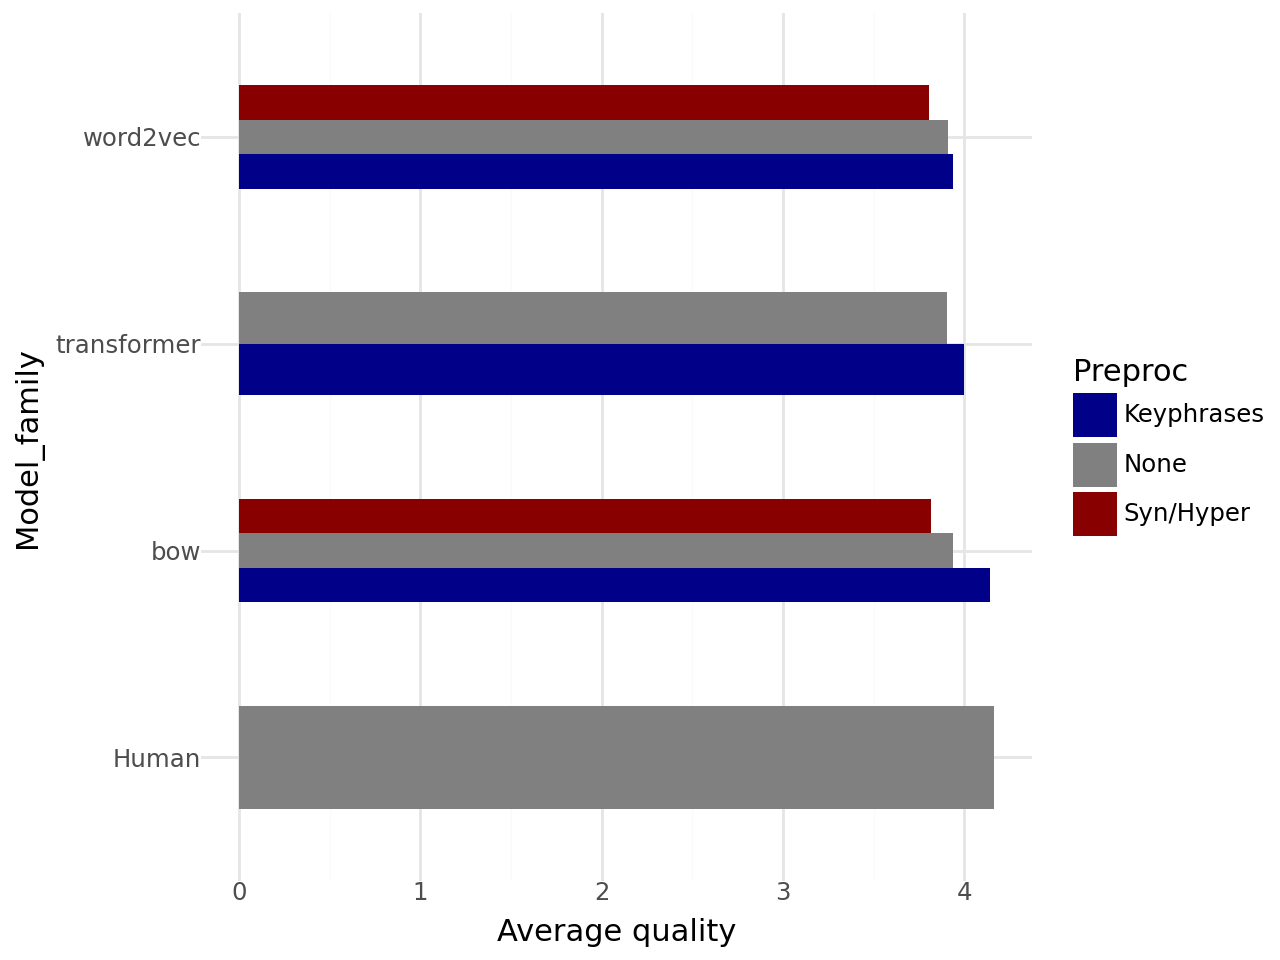

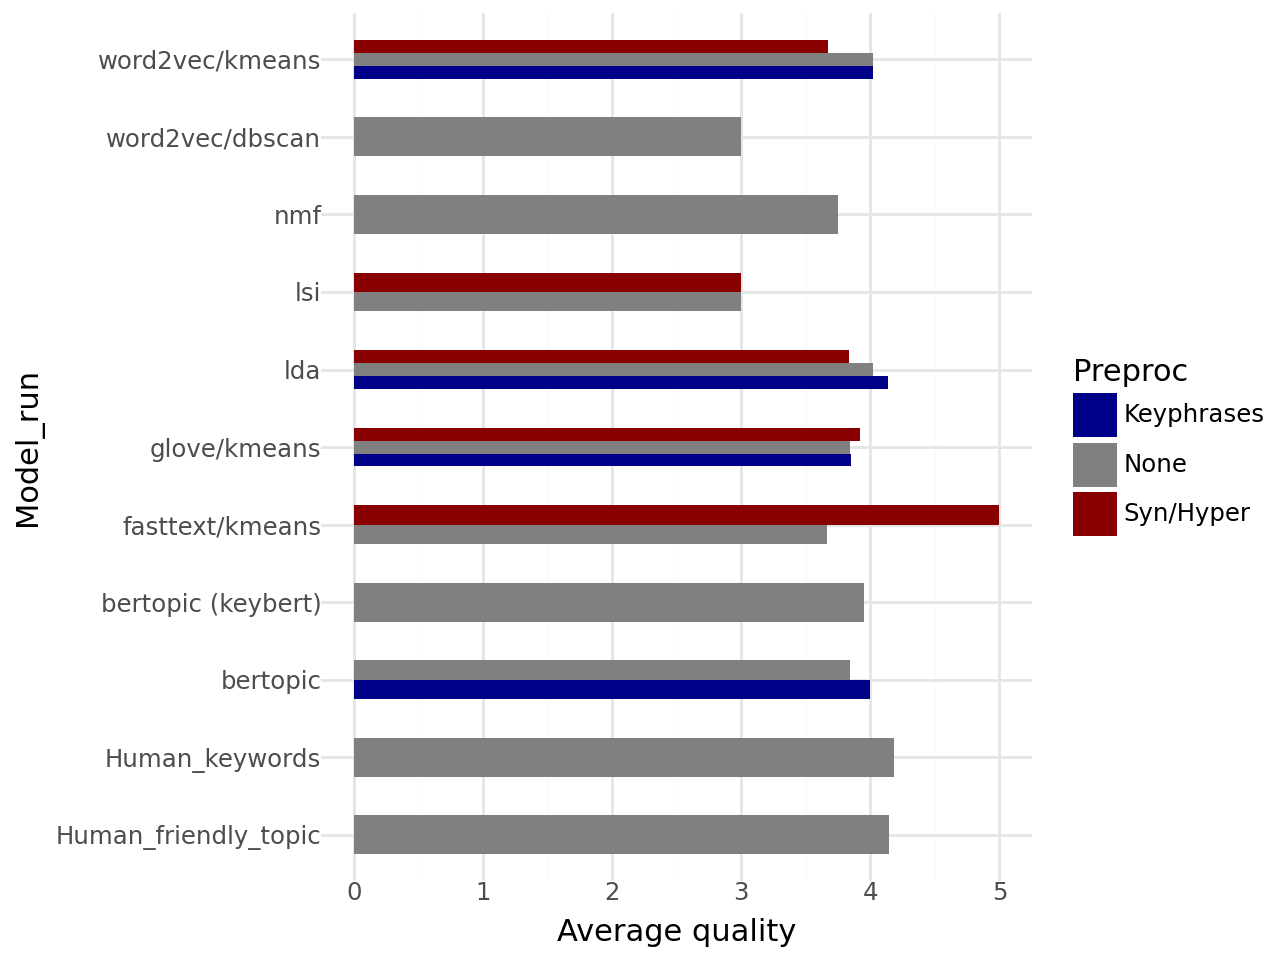

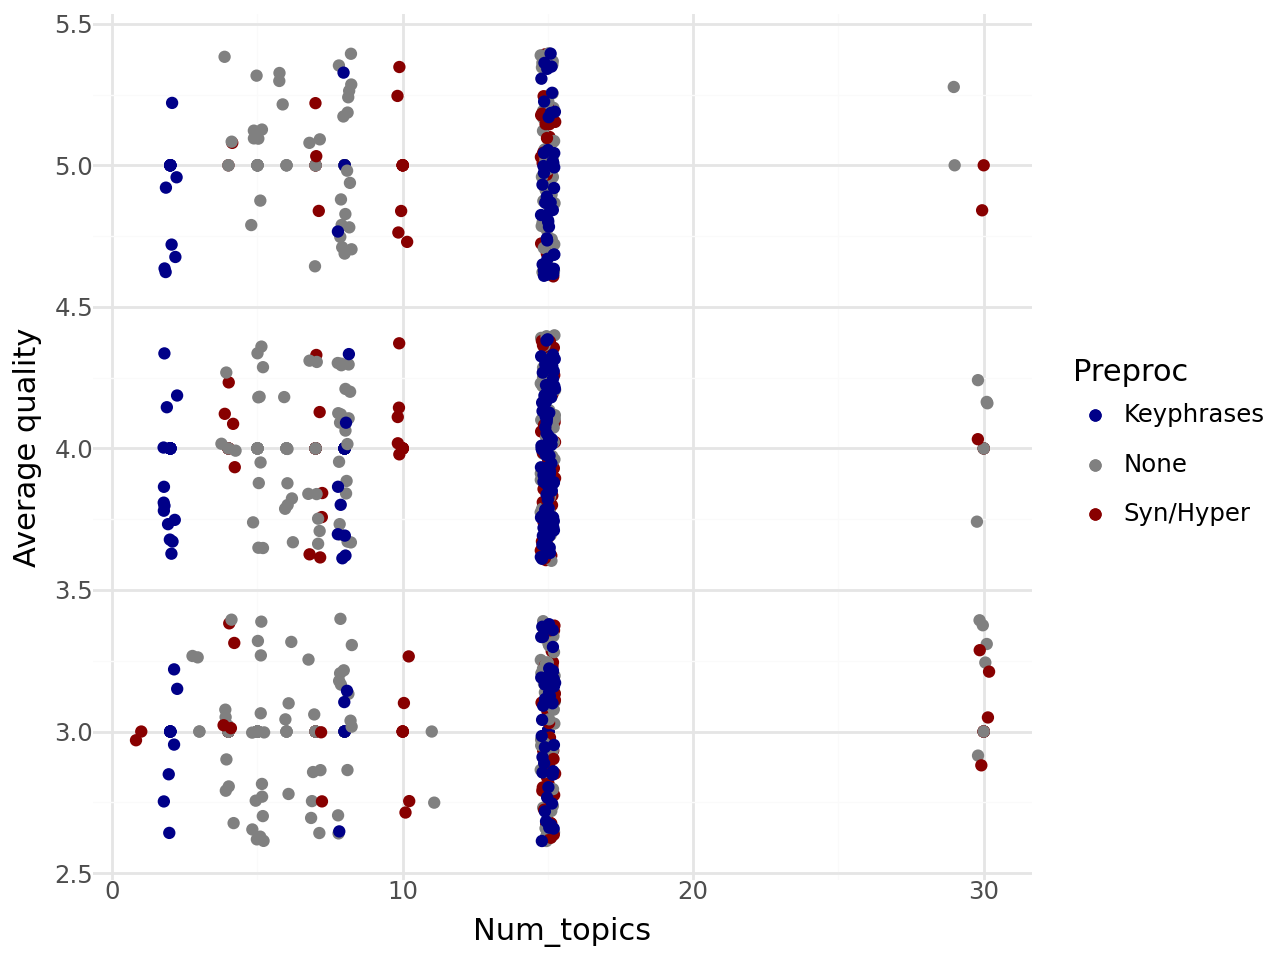

In [525]:
# Same, but only relevant topics
dfm2 = dfm[dfm['Relevant'] == 1].copy()

# Avg quality by set
dfg = dfm2.groupby(['Representation', 'Preproc']).agg({'Quality': 'mean'}).reset_index()
p = ggplot(dfg) + \
    aes(x='Representation', y='Quality', fill='Preproc') + \
    geom_bar(stat='identity', width=0.5, position='dodge') + \
    scale_fill_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    coord_flip() + \
    ylab('Average quality') + \
    theme_minimal()
display(p)

# Avg quality by model family
dfg = dfm2.groupby(['Model_family', 'Preproc']).agg({'Quality': 'mean'}).reset_index()
p = ggplot(dfg) + \
    aes(x='Model_family', y='Quality', fill='Preproc') + \
    geom_bar(stat='identity', width=0.5, position='dodge') + \
    scale_fill_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    coord_flip() + \
    ylab('Average quality') + \
    theme_minimal()
display(p)

# Avg quality by model run
dfg = dfm2.groupby(['Model_run', 'Preproc']).agg({'Quality': 'mean'}).reset_index().sort_values(['Quality'], ascending=False)
p = ggplot(dfg) + \
    aes(x='Model_run', y='Quality', fill='Preproc') + \
    geom_bar(stat='identity', width=0.5, position='dodge') + \
    scale_fill_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    coord_flip() + \
    ylab('Average quality') + \
    theme_minimal()
display(p)


# Avg quality by num topics
p = ggplot(dfm2[~dfm2['Representation'].str.startswith('Human')]) + \
    aes(x='Num_topics', y='Quality', color='Preproc') + \
    geom_point() + \
    scale_colour_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    ylab('Average quality') + \
    geom_jitter(width=0.25) + \
    theme_minimal()
display(p)


### Runtime Evaluation

This section compares how long it took to run each model.


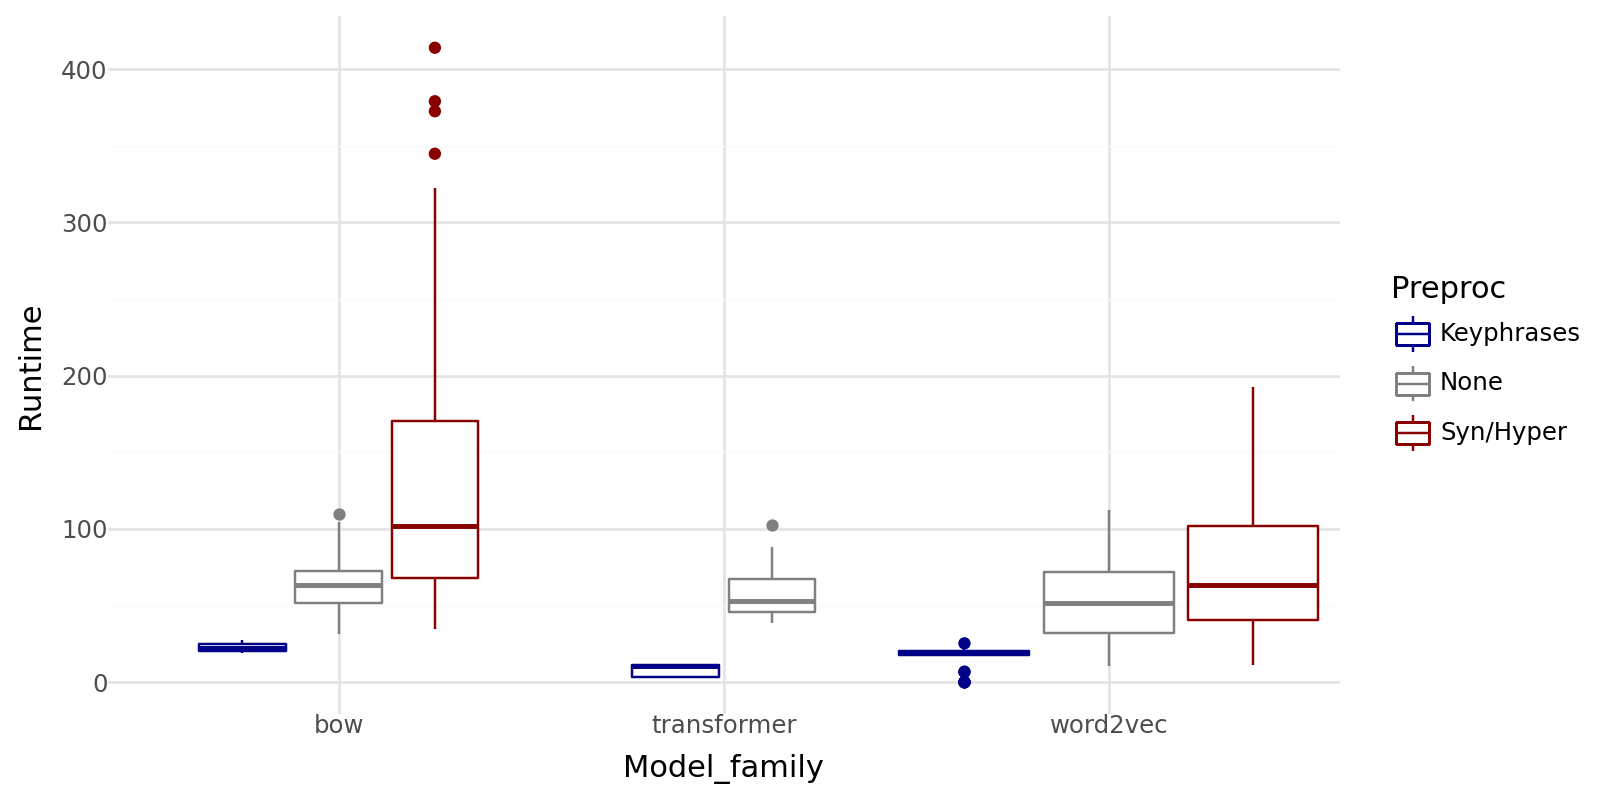

In [913]:
#########################
# Runtime evaluation
#########################

# Plot runtime by model family
p = ggplot(dfr) + \
    aes(y='Runtime', x='Model_family', color='Preproc') + \
    geom_boxplot() + \
    scale_colour_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    theme_minimal() + \
    theme(figure_size=(8, 4))
display(p)


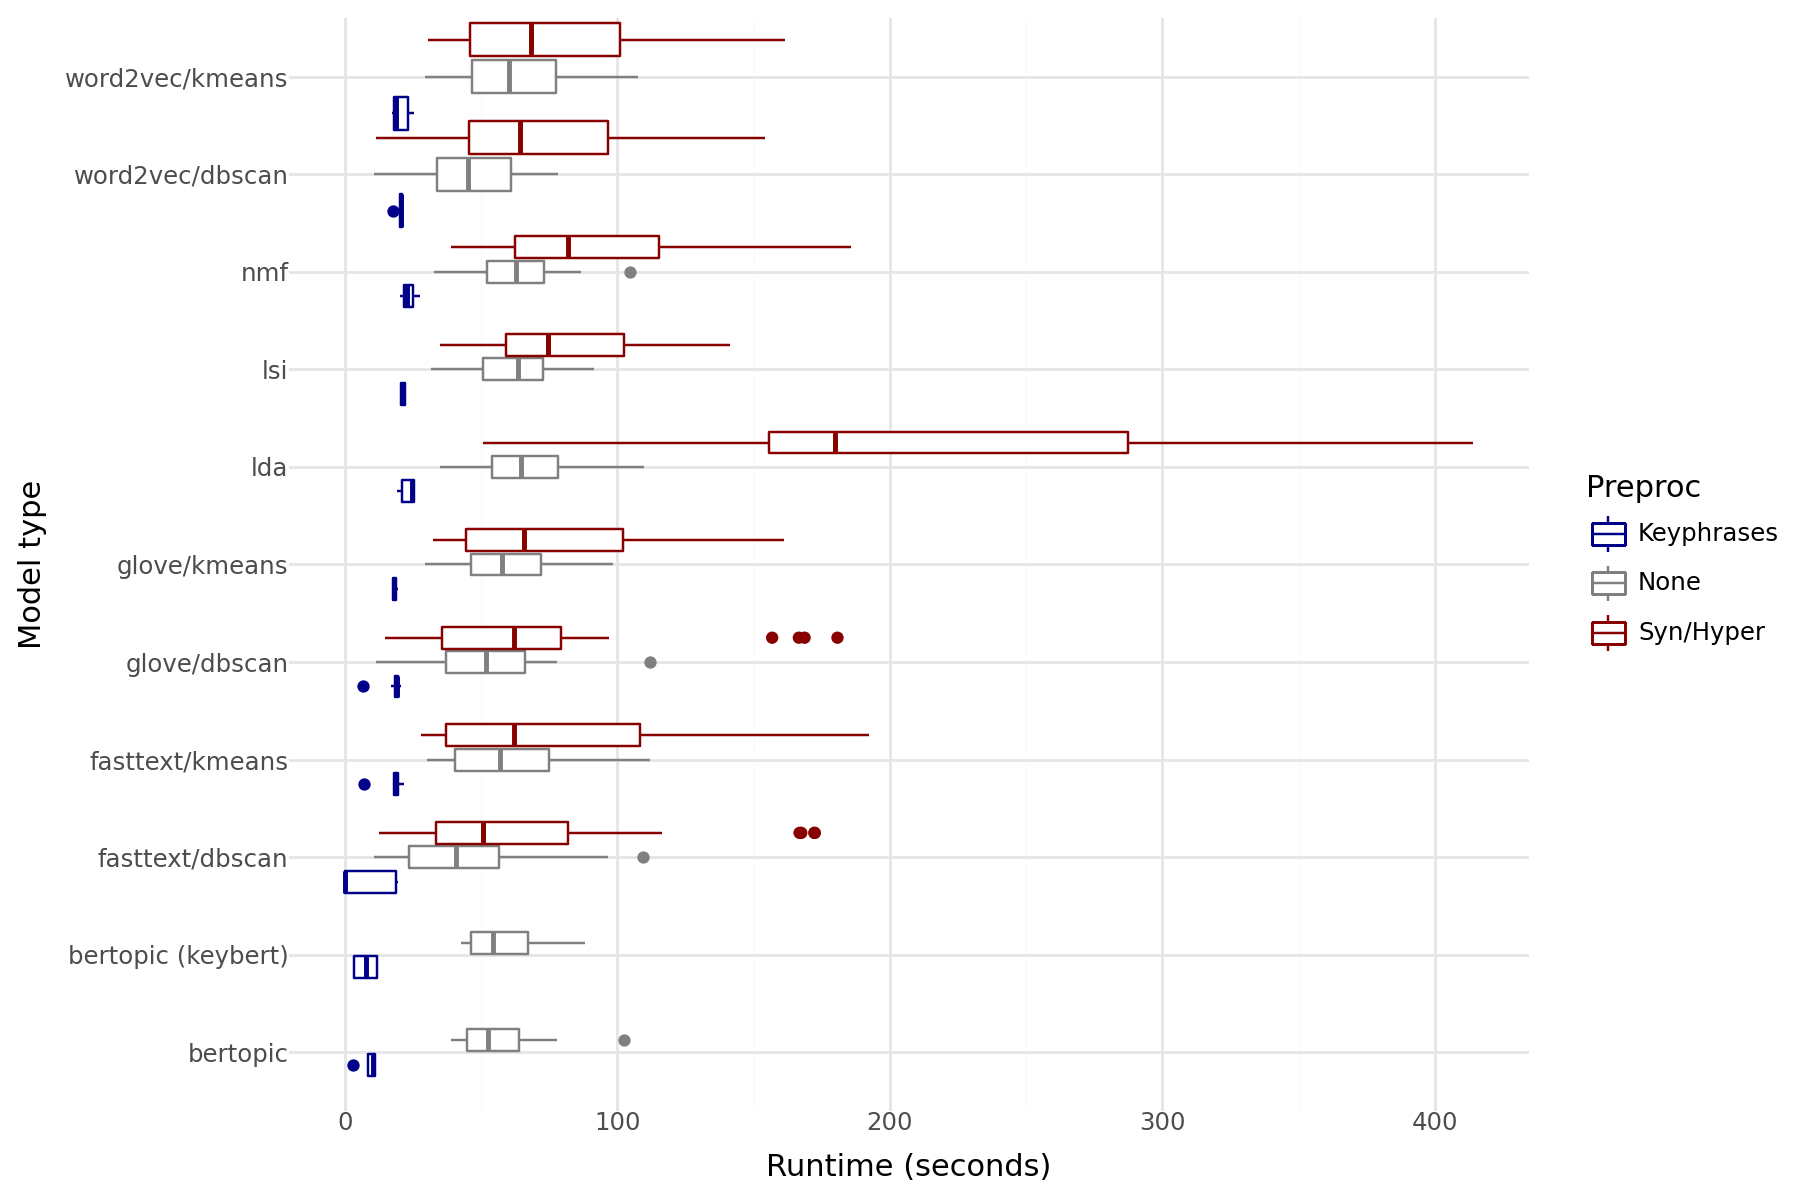

In [938]:
# Plot runtime by model type
p = ggplot(dfr) + \
    aes(y='Runtime', x='Model_run', color='Preproc') + \
    geom_boxplot() + \
    scale_colour_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    theme_minimal() + \
    coord_flip() + \
    xlab('Model type') + \
    ylab('Runtime (seconds)') + \
    theme(figure_size=(9, 6))
display(p)


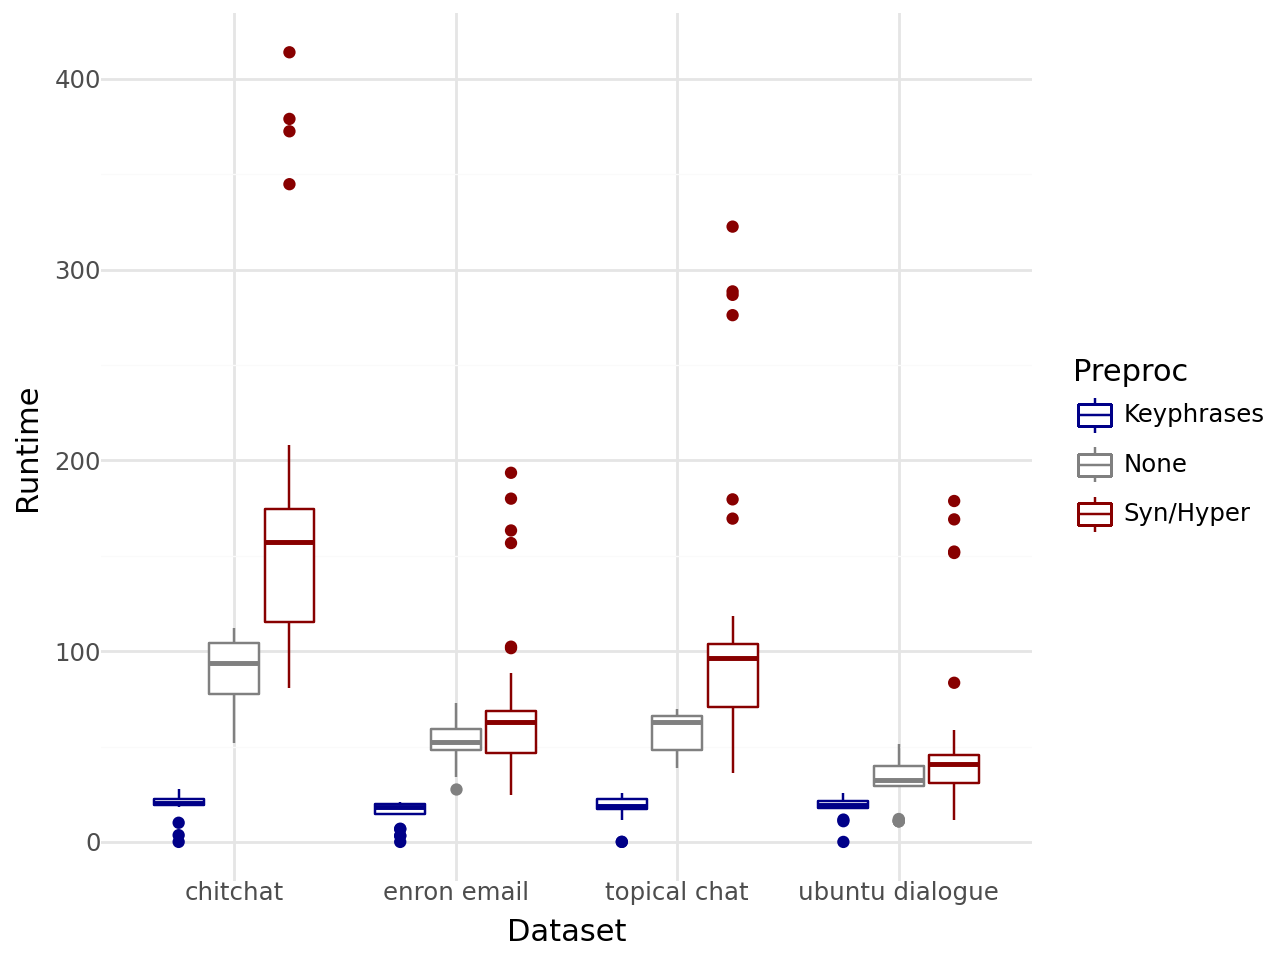

In [936]:
# Plot runtime by dataset
p = ggplot(dfr) + \
    aes(y='Runtime', x='Dataset', color='Preproc') + \
    geom_boxplot() + \
    scale_colour_manual({'Syn/Hyper': '#880000', 'Keyphrases': '#000088', 'None': '#808080'}) + \
    theme_minimal() + \
display(p)
